# DEG analysis between bcd-RNAi vs WT

In [1]:
library(Seurat)
library(ggplot2)
library(viridis)
library(magrittr)
library(data.table)
library(reshape2)
library(Matrix)
library(dplyr)
library(tibble)
library(MAST)
library(scales)

Loading required package: viridisLite


Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt



Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, c

In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] ja_JP.UTF-8/ja_JP.UTF-8/ja_JP.UTF-8/C/ja_JP.UTF-8/ja_JP.UTF-8

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scales_1.1.1                MAST_1.16.0                
 [3] SingleCellExperiment_1.12.0 SummarizedExperiment_1.20.0
 [5] Biobase_2.50.0              GenomicRanges_1.42.0       
 [7] GenomeInfoDb_1.26.2         IRanges_2.24.1             
 [9] S4Vectors_0.28.1            BiocGenerics_0.36.0        
[11] MatrixGenerics_1.2.0        matrixStats_0.57.0         
[13] tibble_3.0.5                dplyr_1.0.3                
[15] Matrix_1.3-2                reshape2_1.4.4

In [3]:
# Data merging bcd-RNAi and control 
seu_HQC <- readRDS(file = '../../data/seurat_object/bcdRNAi_integration/seu_HQC_integrated_bcdRNAi.obj')
seu_HQC

An object of class Seurat 
28966 features across 11023 samples within 2 assays 
Active assay: SCT (11462 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


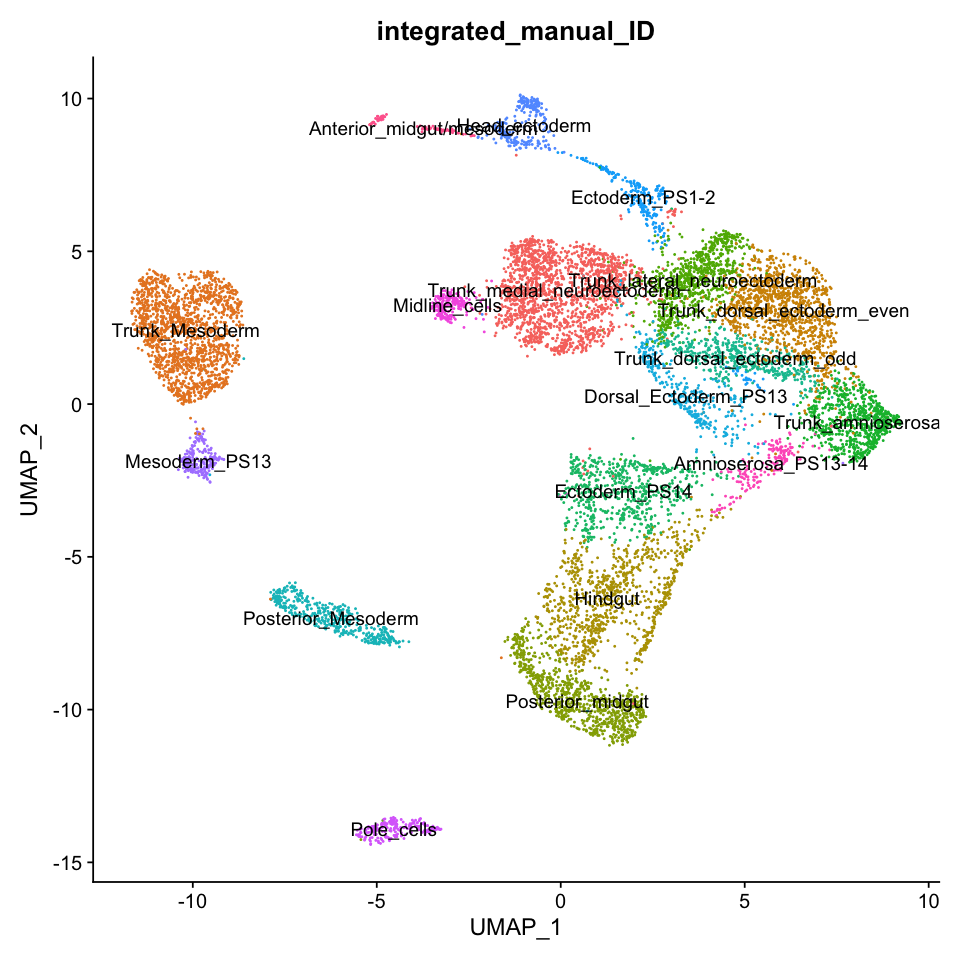

In [4]:
options(repr.plot.width=8, repr.plot.height=8)
p <- DimPlot(seu_HQC, reduction = 'umap', label = T,group.by = 'integrated_manual_ID') + NoLegend()
plot(p)

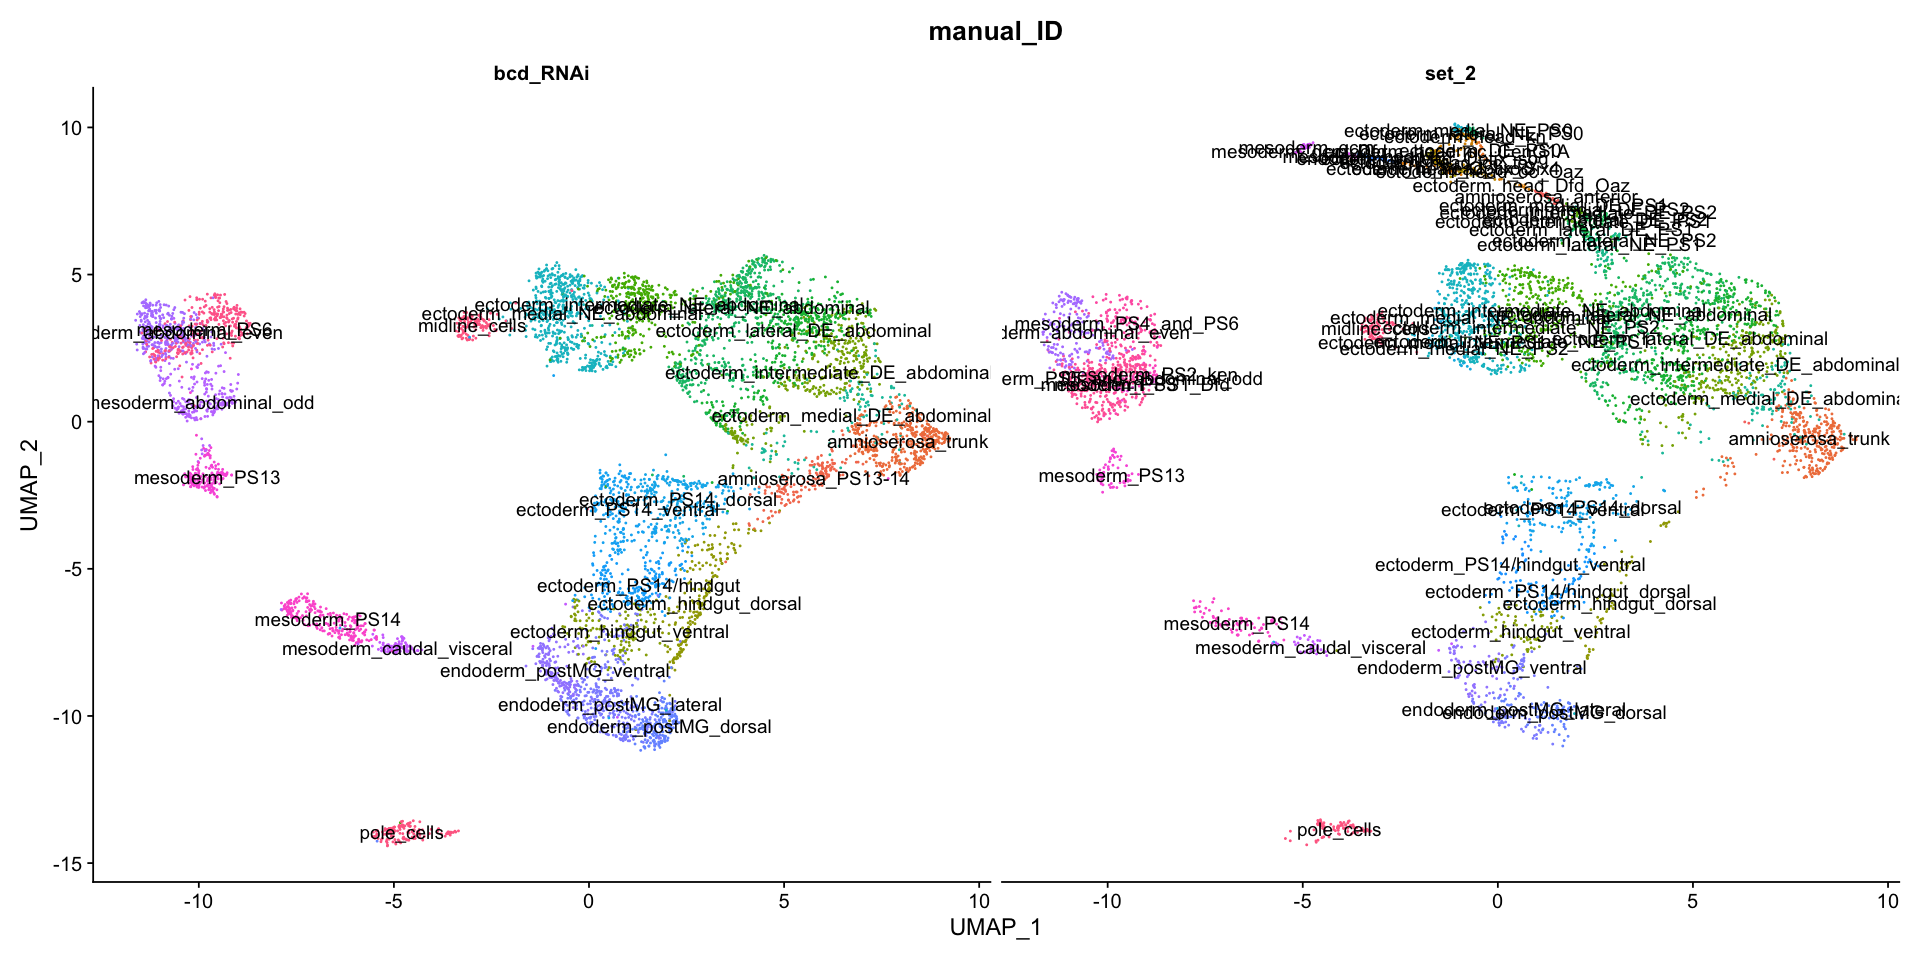

In [5]:
options(repr.plot.width=16, repr.plot.height=8)
p <- DimPlot(seu_HQC, reduction = 'umap', label = T,group.by = 'manual_ID', split.by = 'genotype') + NoLegend()
plot(p)

## Preprocessing

In [6]:
table(seu_HQC$manual_ID, seu_HQC$integrated_manual_ID)['amnioserosa_PS13-14',]
sum(table(seu_HQC$manual_ID, seu_HQC$integrated_manual_ID)['amnioserosa_PS13-14',])

Trunk_medial_neuroectoderm              Trunk_Mesoderm 
                          0                           0 
 Trunk_dorsal_ectoderm_even                     Hindgut 
                          1                           1 
           Posterior_midgut Trunk_lateral_neuroectoderm 
                          0                           1 
          Trunk_amnioserosa               Ectoderm_PS14 
                         11                           3 
  Trunk_dorsal_ectoderm_odd          Posterior_Mesoderm 
                          0                           0 
       Dorsal_Ectoderm_PS13              Ectoderm_PS1-2 
                          1                           0 
              Head_ectoderm               Mesoderm_PS13 
                          0                           0 
                 Pole_cells               Midline_cells 
                          0                           0 
        Amnioserosa_PS13-14    Anterior_midgut/mesoderm 
                        140                           0

[1] 158

In [7]:
#fix subcluster names
seu_HQC$manual_ID_2 <- seu_HQC$manual_ID
seu_HQC$manual_ID_2[seu_HQC$integrated_manual_ID == 'Amnioserosa_PS13-14'] <- 'amnioserosa_PS13-14'
seu_HQC$manual_ID_2[seu_HQC$integrated_manual_ID == 'Dorsal_Ectoderm_PS13'] <- 'ectoderm_PS13_dorsal'
seu_HQC$manual_ID_2[seu_HQC$manual_ID == 'mesoderm_PS6'] <- 'mesoderm_PS4_and_PS6'
seu_HQC$manual_ID_2[seu_HQC$manual_ID == 'mesoderm_abdominal_odd'] <- 'mesoderm_PS5_and_abdominal_odd'
seu_HQC$manual_ID_2[seu_HQC$manual_ID == 'ectoderm_PS14/hindgut_dorsal'] <- 'ectoderm_PS14/hindgut'
seu_HQC$manual_ID_2[seu_HQC$manual_ID == 'ectoderm_PS14/hindgut_ventral'] <- 'ectoderm_PS14/hindgut'

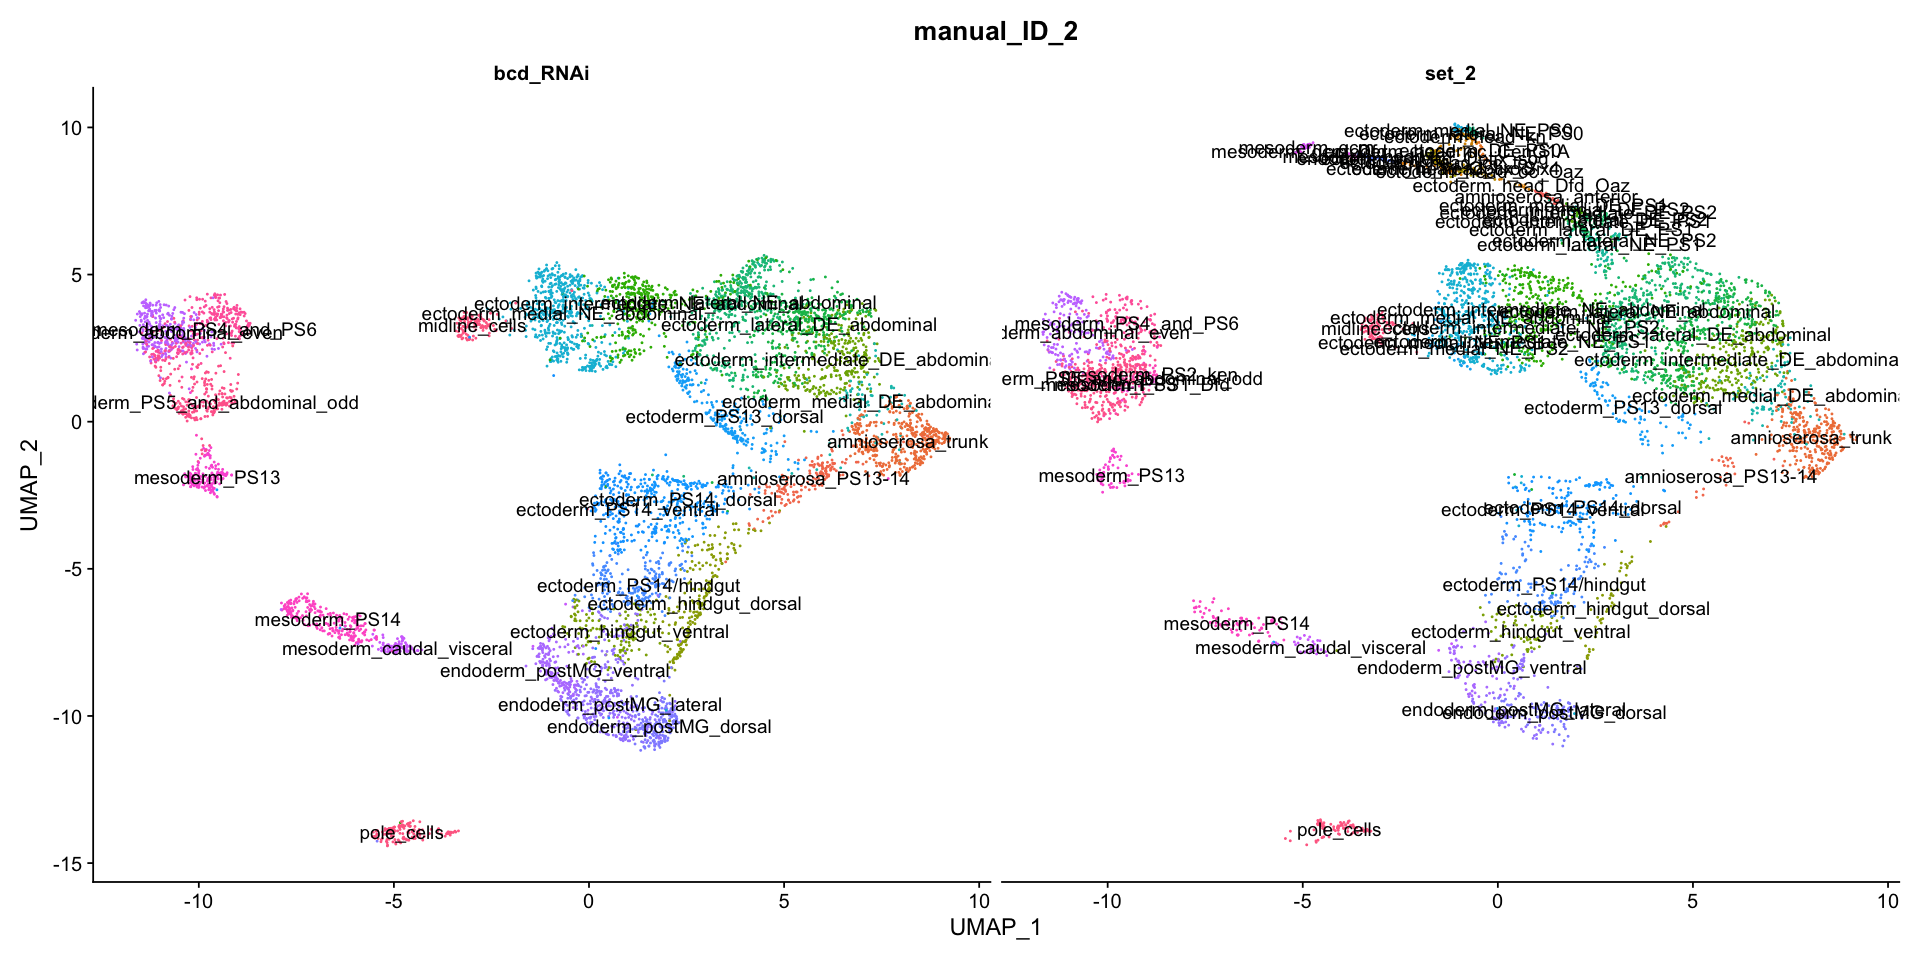

In [8]:
options(repr.plot.width=16, repr.plot.height=8)
p <- DimPlot(seu_HQC, reduction = 'umap', label = T,group.by = 'manual_ID_2', split.by = 'genotype') + NoLegend()
plot(p)

In [9]:
head.clusters <- c('mesoderm_head','endoderm_antMG',
                   'ectoderm_head_croc','ectoderm_head_Optix_Six4','ectoderm_head_Optix_sog',
                  'ectoderm_head_oc_CenG1A','ectoderm_head_oc_toy','ectoderm_head_oc_Oaz',
                   'ectoderm_head_Dfd_Oaz','ectoderm_head_kn','ectoderm_DE_PS0',
                   'ectoderm_lateral_NE_PS0','ectoderm_medial_NE_PS0','amnioserosa_anterior',
                  'ectoderm_medial_DE_PS1','ectoderm_intermediate_DE_PS1','ectoderm_lateral_DE_PS1',
                  'ectoderm_medial_NE_PS1','ectoderm_intermediate_NE_PS1','ectoderm_lateral_NE_PS1',
                  'ectoderm_medial_DE_PS2','ectoderm_intermediate_DE_PS2','ectoderm_lateral_DE_PS2',
                  'ectoderm_medial_NE_PS2','ectoderm_intermediate_NE_PS2','ectoderm_lateral_NE_PS2',
                  'mesoderm_gcm','mesoderm_gcm_Dfd','mesoderm_PS1_Dfd','mesoderm_PS2_ken','mesoderm_PS3')

In [10]:
length(head.clusters)

[1] 31

In [11]:
# Normalize merged dataset to use the same scale in both datasets
seu.merge.renorm <- copy(seu_HQC)
DefaultAssay(seu.merge.renorm) <- 'RNA'
is.mt <- grepl(x = row.names(seu.merge.renorm), pattern = '^mt:')
is.rRNA <- grepl(x = row.names(seu.merge.renorm), pattern = 'rRNA')
seu.merge.renorm <- seu.merge.renorm[!(is.mt|is.rRNA),]
seu.merge.renorm <- suppressWarnings(SCTransform(seu.merge.renorm))

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 11843 by 11023

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 11023 cells



  |======================================================================| 100%


Found 160 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 11843 genes



  |======================================================================| 100%


Computing corrected count matrix for 11843 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 2.267965 mins

Determine variable features

Set 3000 variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



In [12]:
Idents(seu.merge.renorm) <- 'manual_ID_2'
seu.wo.head <- subset(seu.merge.renorm, idents = c(head.clusters,'pole_cells'), invert = T)
seu.wo.head

An object of class Seurat 
29193 features across 10044 samples within 2 assays 
Active assay: SCT (11843 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

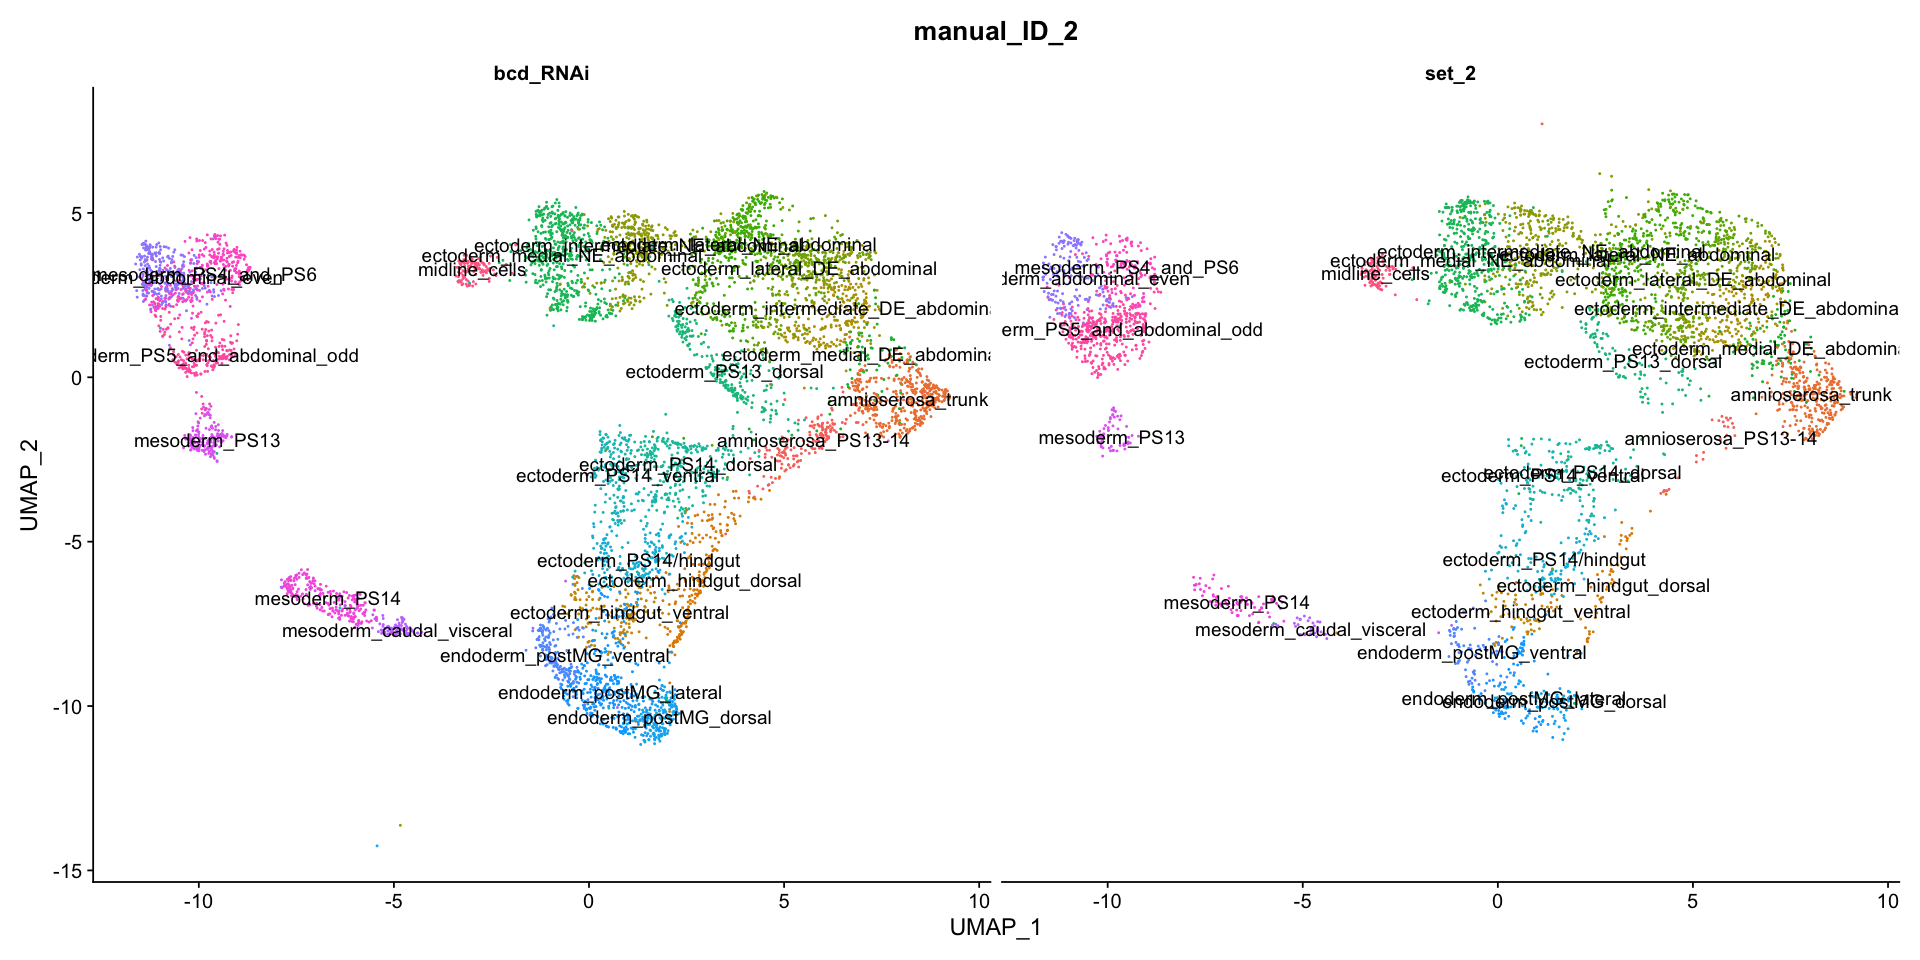

In [13]:
options(repr.plot.width=16, repr.plot.height=8)
p <- DimPlot(seu.wo.head, reduction = 'umap', label = T,group.by = 'manual_ID_2', split.by = 'genotype') + NoLegend()
plot(p)

## DEG detection

In [14]:
obj.list <- SplitObject(seu.wo.head, split.by = 'manual_ID_2')
obj.list
n.clusters <- length(obj.list)
print(n.clusters)
GetDEGs <- function(seu, threshold = 0.01){
    # DEGs between bcdRNAi vs. control in each posterior cluster
    Idents(seu) <- 'genotype'
    degs <- FindMarkers(seu, ident.1 = 'bcd_RNAi',methods = 'MAST')
    degs <- degs[degs$p_val_adj * n.clusters<threshold,]
    return(degs)
}
degs_list <- lapply(obj.list, FUN = GetDEGs)
lapply(degs_list, FUN = dim)

$ectoderm_hindgut_dorsal
An object of class Seurat 
29193 features across 259 samples within 2 assays 
Active assay: SCT (11843 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

$ectoderm_intermediate_NE_abdominal
An object of class Seurat 
29193 features across 760 samples within 2 assays 
Active assay: SCT (11843 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

$amnioserosa_trunk
An object of class Seurat 
29193 features across 694 samples within 2 assays 
Active assay: SCT (11843 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

$ectoderm_intermediate_DE_abdominal
An object of class Seurat 
29193 features across 552 samples within 2 assays 
Active assay: SCT (11843 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

$ectoderm_lateral_NE_abdomin

[1] 24


$ectoderm_hindgut_dorsal
[1] 83  5

$ectoderm_intermediate_NE_abdominal
[1] 372   5

$amnioserosa_trunk
[1] 446   5

$ectoderm_intermediate_DE_abdominal
[1] 362   5

$ectoderm_lateral_NE_abdominal
[1] 400   5

$endoderm_postMG_ventral
[1] 99  5

$ectoderm_medial_DE_abdominal
[1] 98  5

$ectoderm_PS14_dorsal
[1] 232   5

$ectoderm_hindgut_ventral
[1] 71  5

$ectoderm_PS13_dorsal
[1] 188   5

$mesoderm_PS13
[1] 127   5

$mesoderm_PS5_and_abdominal_odd
[1] 482   5

$mesoderm_PS14
[1] 119   5

$ectoderm_lateral_DE_abdominal
[1] 378   5

$mesoderm_PS4_and_PS6
[1] 357   5

$midline_cells
[1] 111   5

$ectoderm_medial_NE_abdominal
[1] 352   5

$mesoderm_abdominal_even
[1] 410   5

$endoderm_postMG_lateral
[1] 270   5

$`ectoderm_PS14/hindgut`
[1] 163   5

$ectoderm_PS14_ventral
[1] 116   5

$endoderm_postMG_dorsal
[1] 131   5

$mesoderm_caudal_visceral
[1] 16  5

$`amnioserosa_PS13-14`
[1] 33  5

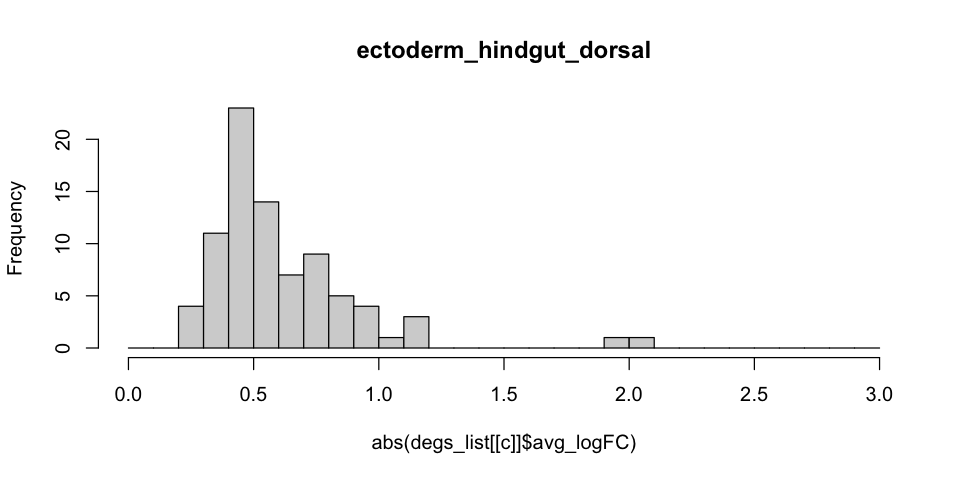

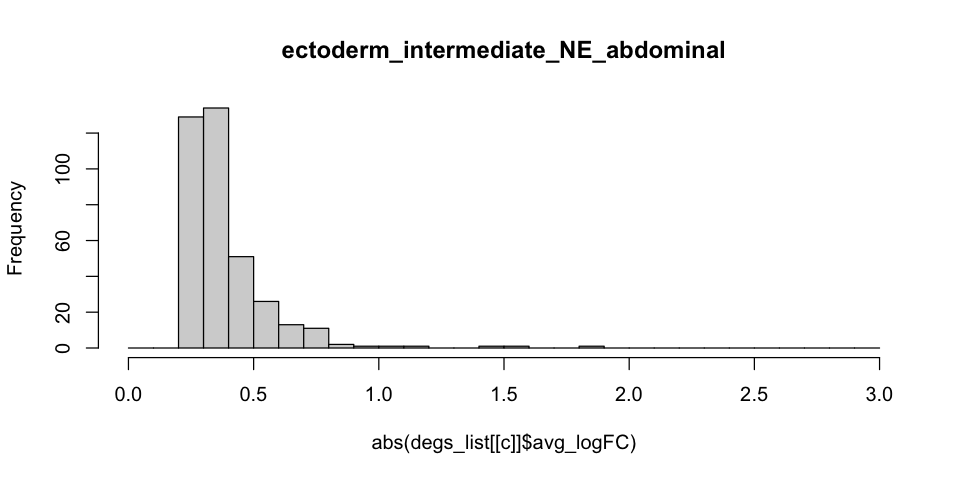

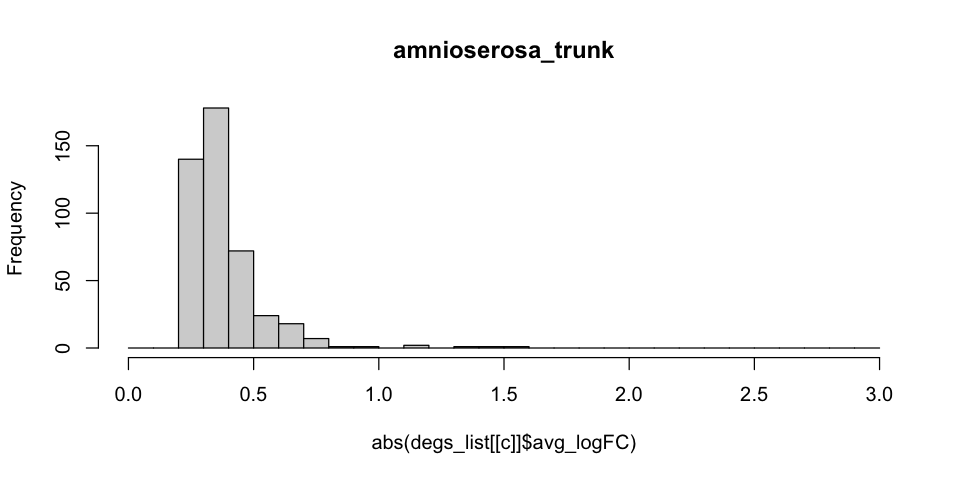

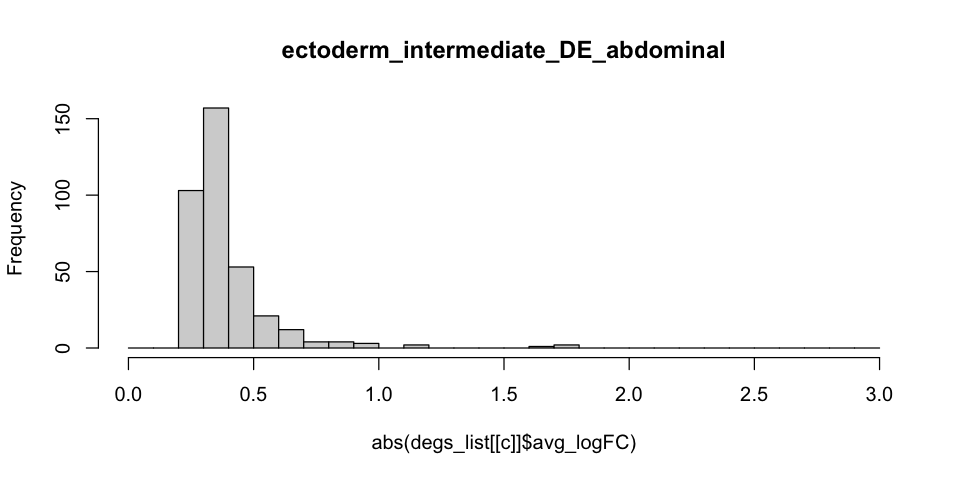

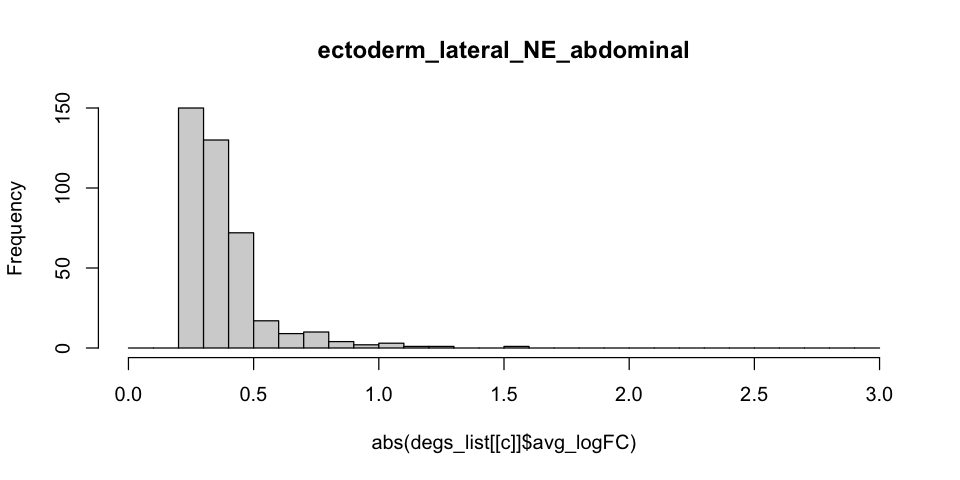

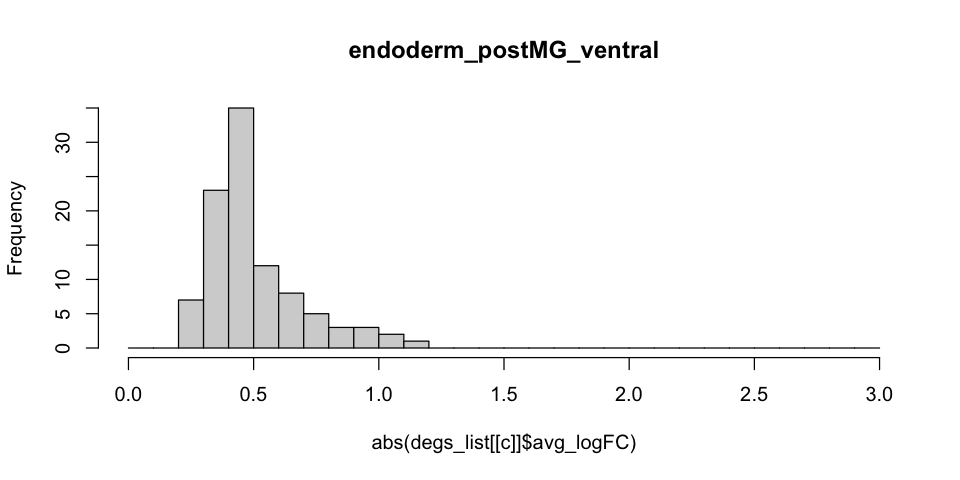

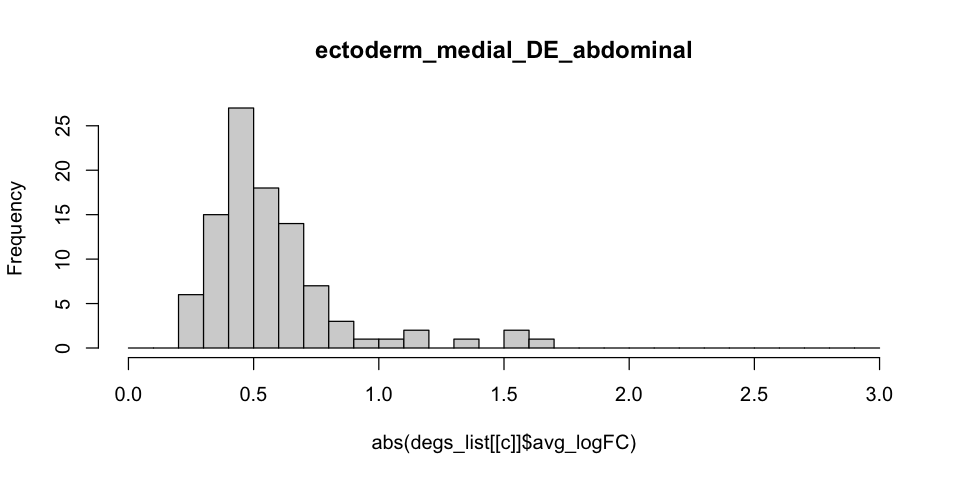

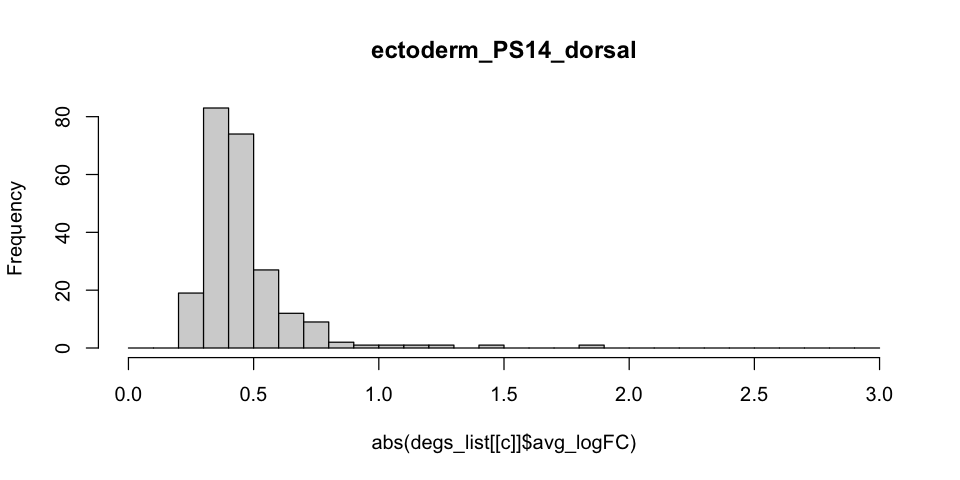

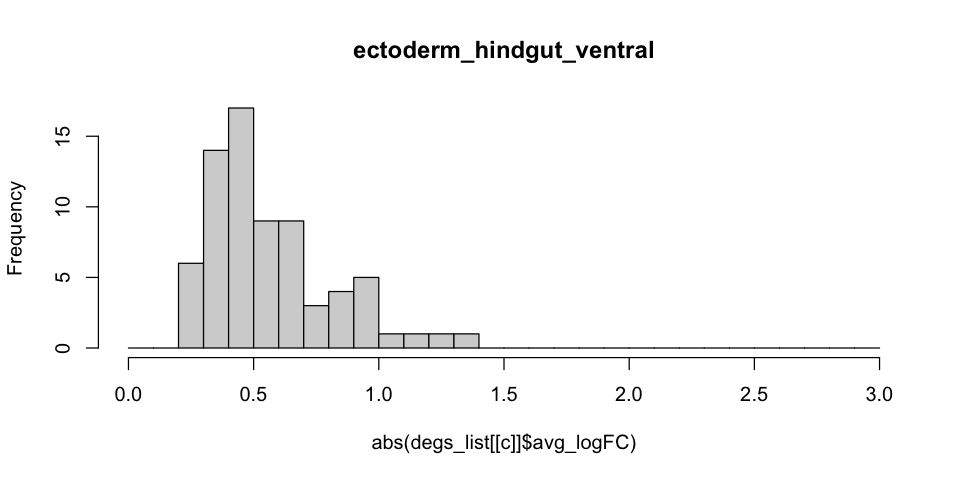

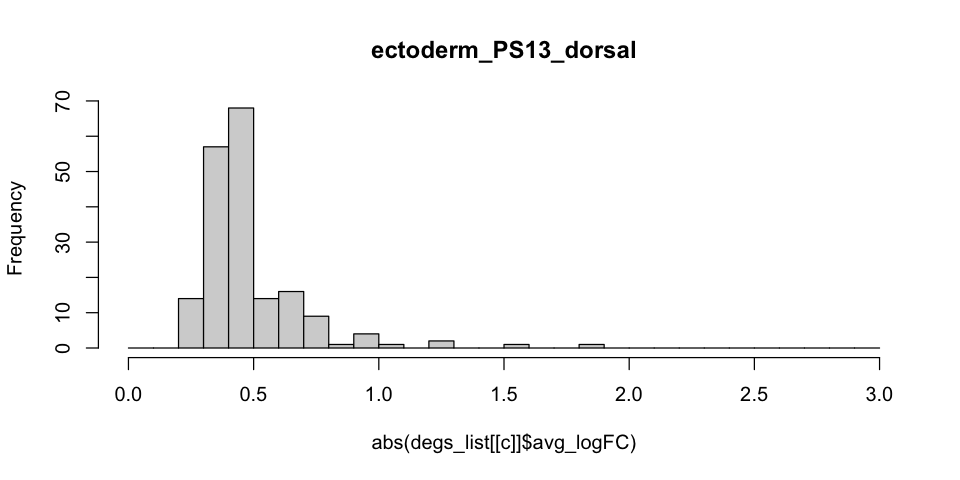

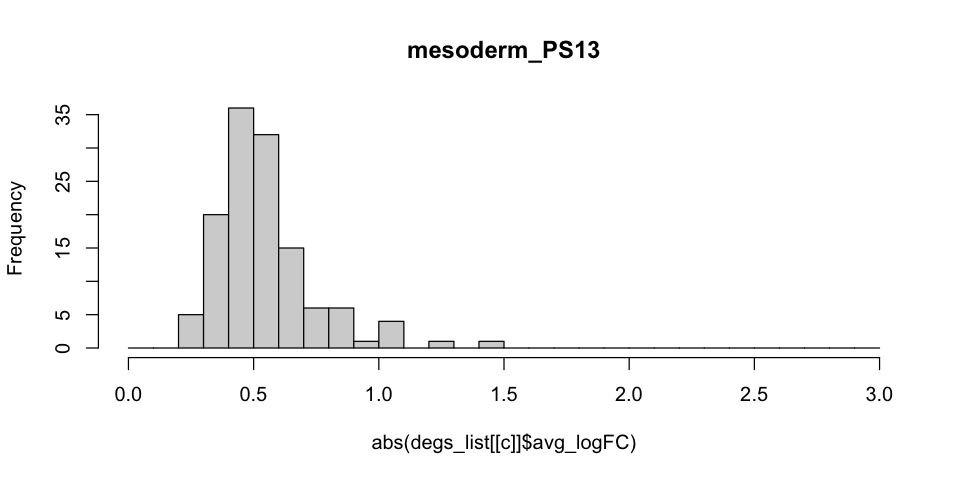

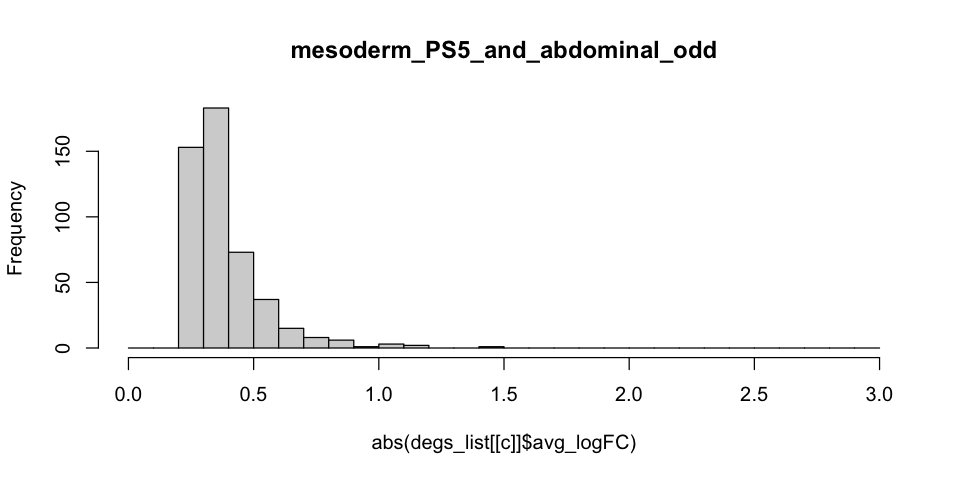

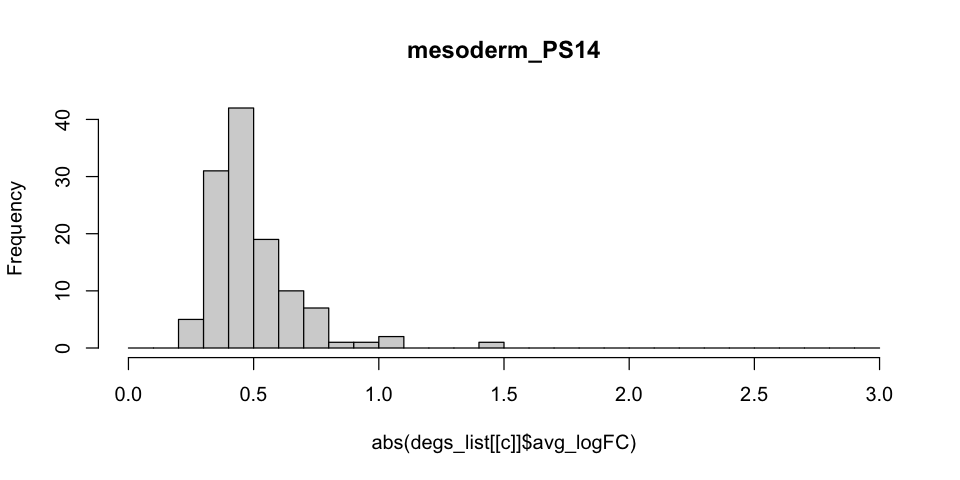

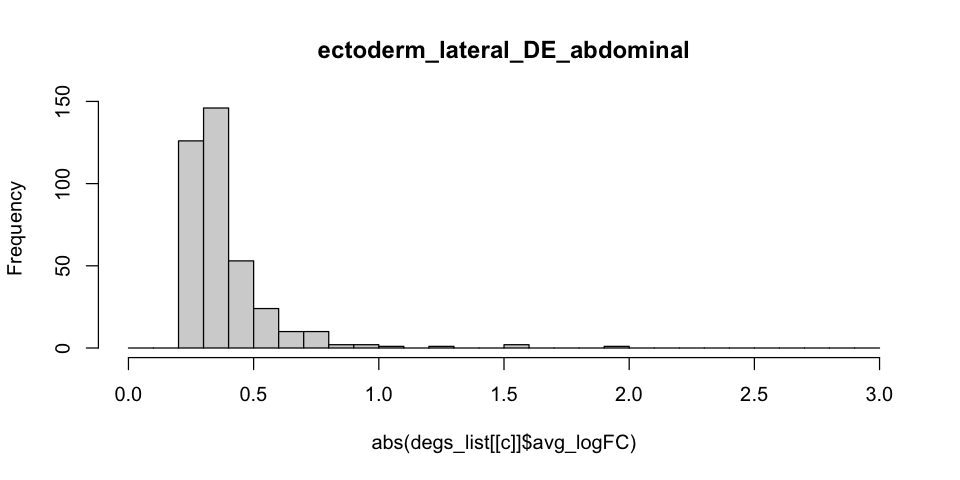

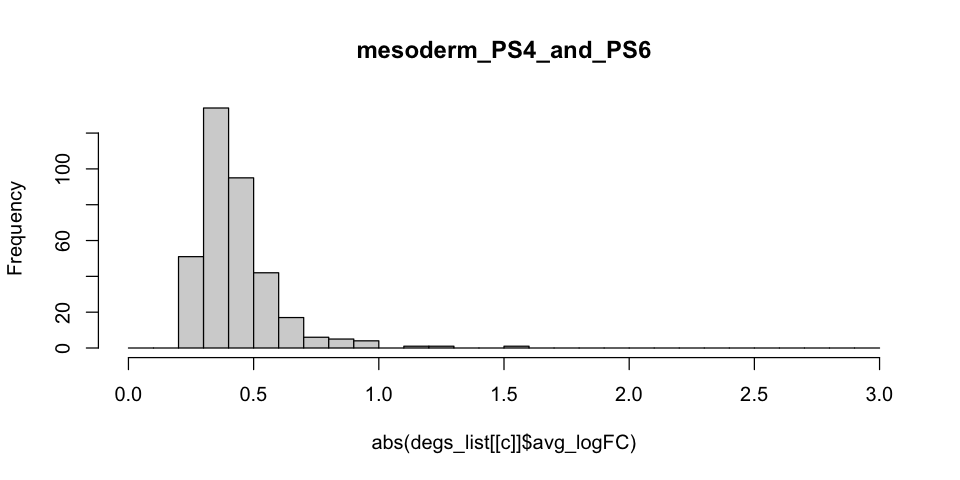

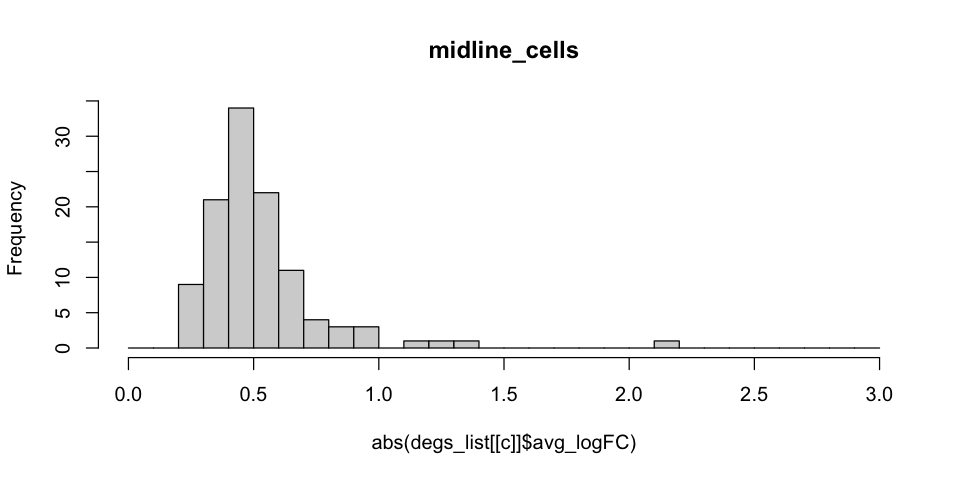

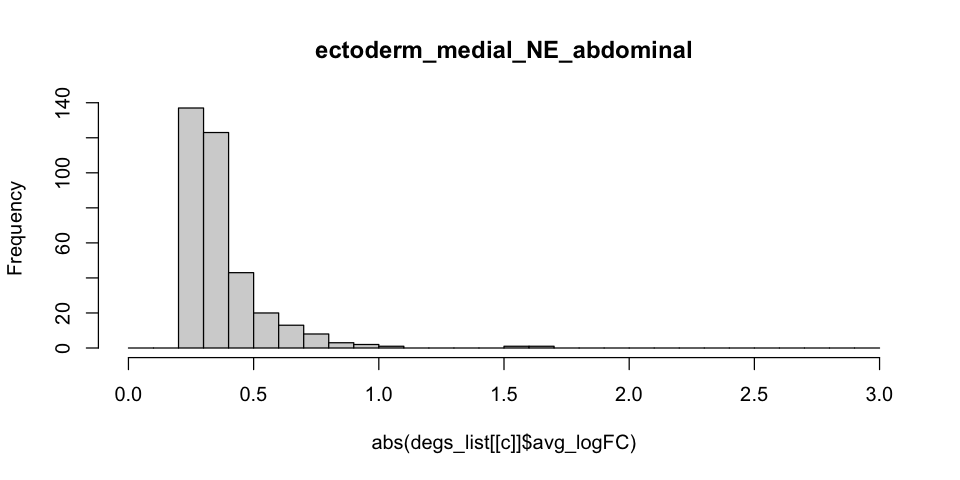

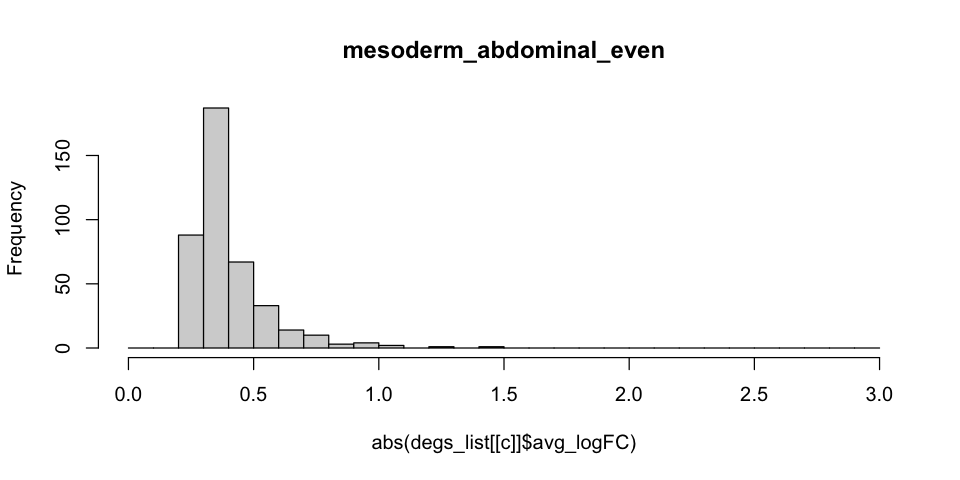

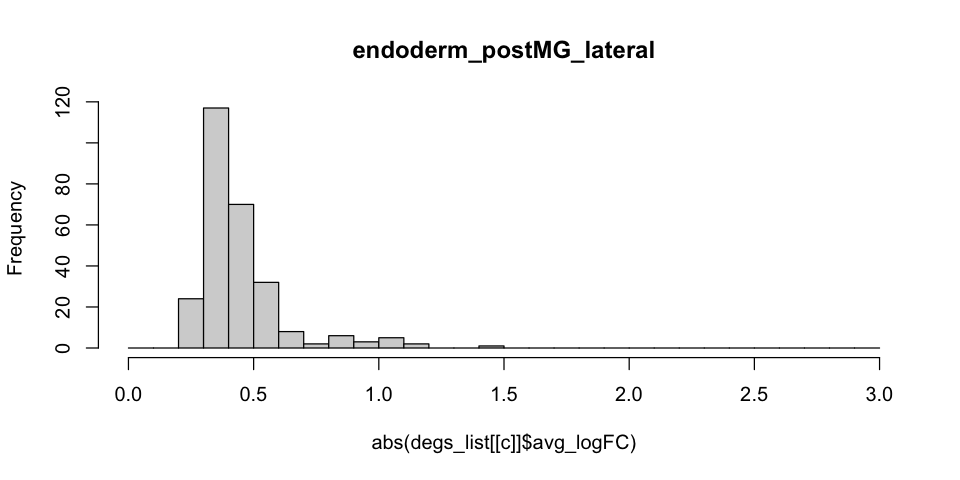

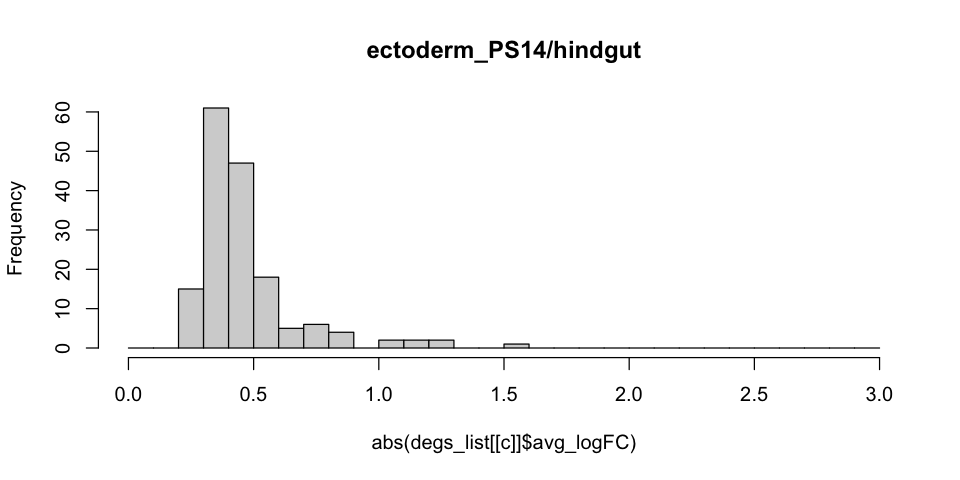

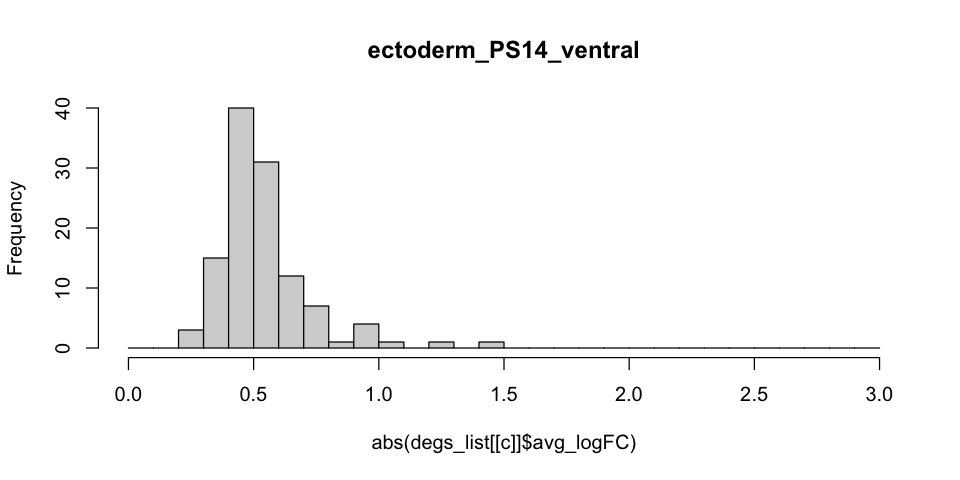

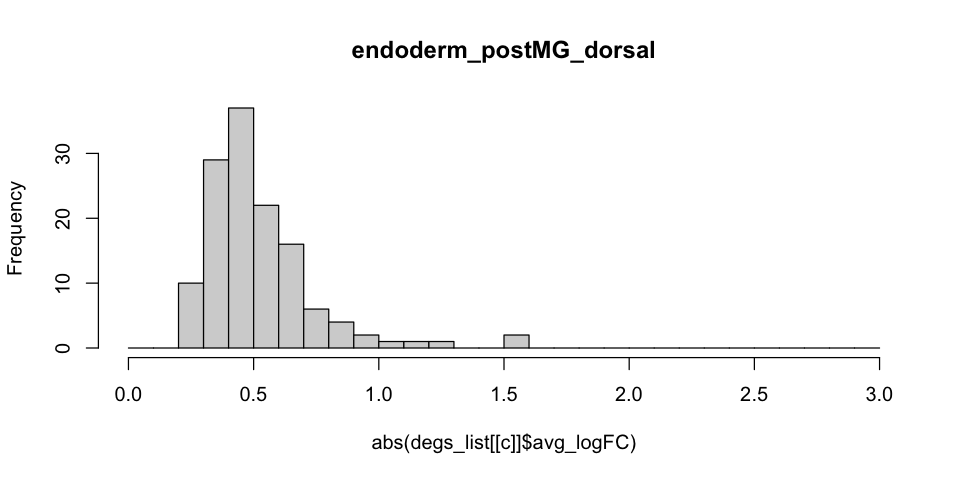

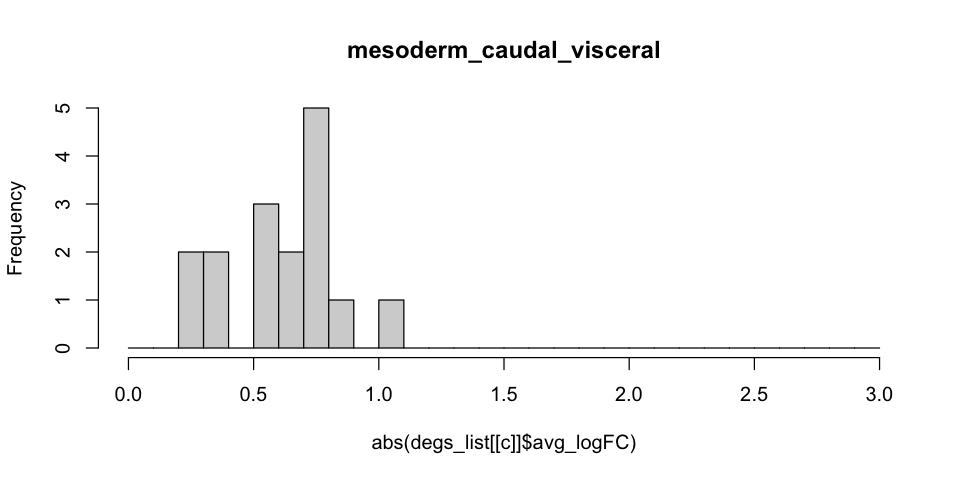

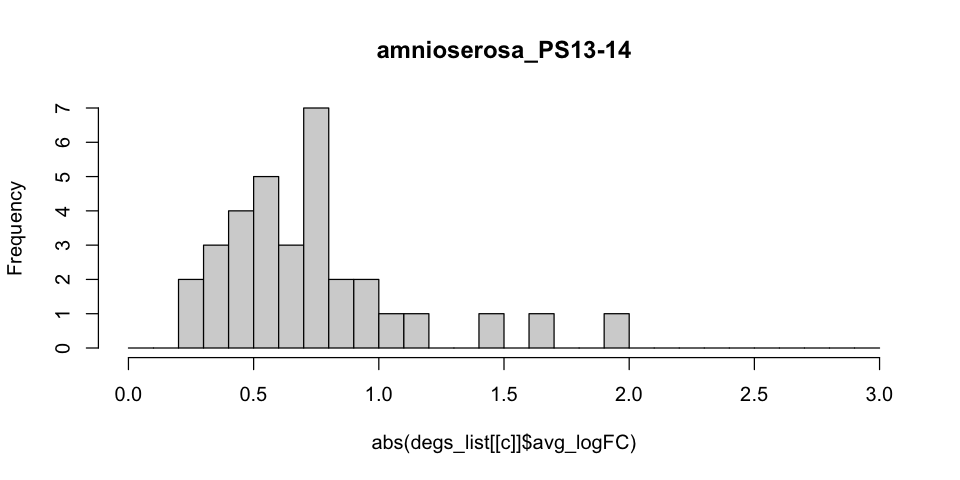

In [15]:
for (c in names(degs_list)){
    options(repr.plot.width=8, repr.plot.height=4)
    hist(abs(degs_list[[c]]$avg_logFC), breaks = 0:30/10.0, main = c)
}

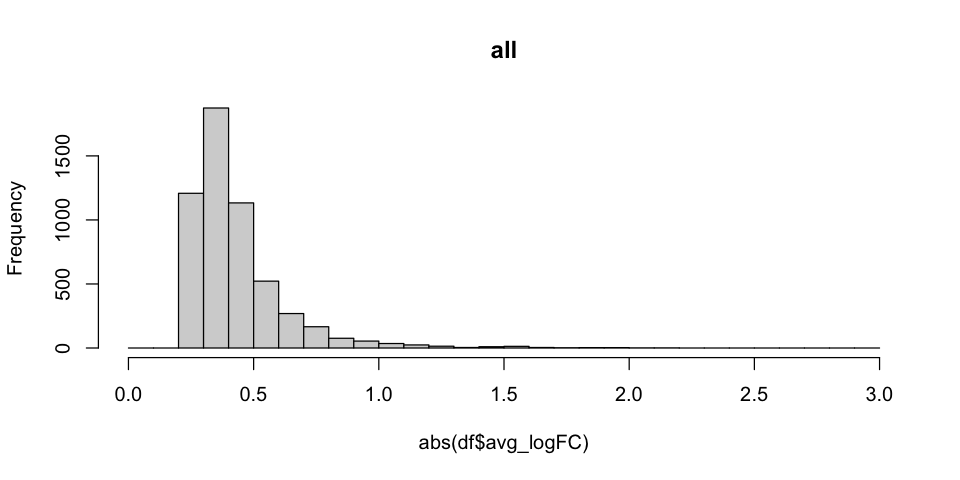

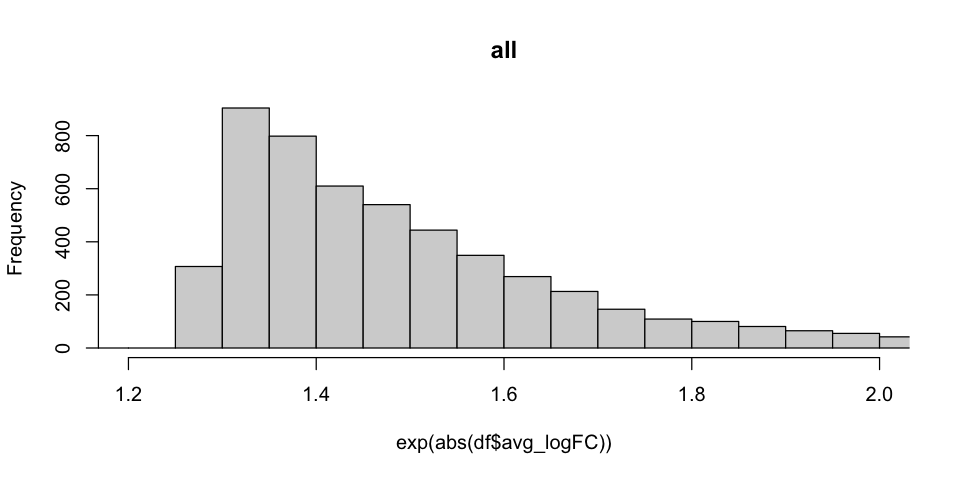

In [16]:
df = data.frame()
for (c in names(degs_list)){
    df_tmp <- degs_list[[c]]
    df <- rbind(df, df_tmp)
}
options(repr.plot.width=8, repr.plot.height=4)
hist(abs(df$avg_logFC),  breaks = 0:30/10.0, main = 'all')
hist(exp(abs(df$avg_logFC)), breaks = 0:400/20.0, main = 'all', xlim = c(1.2,2))

## Positive DEGs

In [17]:
Threshoding.FC.pos<- function(df){
    df <- df[df$avg_logFC>0.5,]
    degs <- row.names(df) 
}

OnlyPos <- function(df){
    df <- df[df$avg_logFC > 0,]
    degs <- row.names(df) 
}

degs.pos <- lapply(degs_list, FUN = Threshoding.FC.pos)
lapply(degs.pos, FUN = length)
degs.pos

$ectoderm_hindgut_dorsal
[1] 34

$ectoderm_intermediate_NE_abdominal
[1] 40

$amnioserosa_trunk
[1] 35

$ectoderm_intermediate_DE_abdominal
[1] 29

$ectoderm_lateral_NE_abdominal
[1] 31

$endoderm_postMG_ventral
[1] 17

$ectoderm_medial_DE_abdominal
[1] 32

$ectoderm_PS14_dorsal
[1] 36

$ectoderm_hindgut_ventral
[1] 20

$ectoderm_PS13_dorsal
[1] 32

$mesoderm_PS13
[1] 44

$mesoderm_PS5_and_abdominal_odd
[1] 51

$mesoderm_PS14
[1] 28

$ectoderm_lateral_DE_abdominal
[1] 34

$mesoderm_PS4_and_PS6
[1] 53

$midline_cells
[1] 29

$ectoderm_medial_NE_abdominal
[1] 32

$mesoderm_abdominal_even
[1] 40

$endoderm_postMG_lateral
[1] 30

$`ectoderm_PS14/hindgut`
[1] 23

$ectoderm_PS14_ventral
[1] 37

$endoderm_postMG_dorsal
[1] 37

$mesoderm_caudal_visceral
[1] 7

$`amnioserosa_PS13-14`
[1] 11

$ectoderm_hindgut_dorsal
 [1] "DNaseII"        "CG13465"        "CG42762"        "CG7840"        
 [5] "olf413"         "Not1"           "robo2"          "Atx-1"         
 [9] "Xpc"            "CG34224"        "Stt3A"          "Ptp99A"        
[13] "bru3"           "Ald"            "tun"            "side"          
[17] "Bx42"           "Smr"            "NUCB1"          "Nup358"        
[21] "NimC4"          "SKIP"           "ft"             "GstT3"         
[25] "Tim17b"         "Sema2b"         "Pde8"           "CG3918"        
[29] "lncRNA:CR42862" "CG17841"        "Zip102B"        "Tet"           
[33] "smal"           "CG13917"       

$ectoderm_intermediate_NE_abdominal
 [1] "Atx-1"          "smt3"           "CG13465"        "CG7840"        
 [5] "COX7A"          "Ald"            "Xpc"            "NUCB1"         
 [9] "tun"            "DNaseII"        "CG43355-sala"   "Bx42"          
[13] "Tim17b"         "CG17841"        "GstT3"          "CG13551"       
[17] "Gdh"            "CG42762"        "wmd"            "Not1"          
[21] "Stt3A"          "CG1103"         "GstE13"         "Ama"           
[25] "CG17514"        "Nop56"          "Idgf2"          "CG6767"        
[29] "CG31549"        "TfIIFbeta"      "Ccdc56-mtTFB1"  "phm"           
[33] "CG41099"        "CG8073"         "Gabat"          "CG8545"        
[37] "rst"            "CR14033"        "lncRNA:CR43432" "Abd-B"         

$amnioserosa_trunk
 [1] "DNaseII" "Atx-1"   "CG13465" "Not1"    "Ald"     "NUCB1"   "CG42762"
 [8] "Bx42"    "Xpc"     "GstT3"   "COX7A"   "tun"     "SKIP"    "Tnpo"   
[15] "CG7840"  "CG8545"  "CG6767"  "bab2"    "bru3"    "wmd"     "Gdh"    
[22] "Dscam2"  "CG1103"  "CG17841" "Wnt4"    "fj"      "CR14033" "olf413" 
[29] "CG31549" "Kank"    "CG30463" "zen"     "Abd-B"   "CG16886" "Dll"    

$ectoderm_intermediate_DE_abdominal
 [1] "DNaseII" "CG13465" "Atx-1"   "CG42762" "Not1"    "olf413"  "Bx42"   
 [8] "tun"     "COX7A"   "Dscam2"  "CG17841" "Ald"     "Xpc"     "CG7840" 
[15] "NUCB1"   "Tim17b"  "rst"     "GstT3"   "CG1103"  "CG42342" "Gdh"    
[22] "CG41099" "SKIP"    "pri"     "CG6767"  "egr"     "Abd-B"   "fj"     
[29] "MFS14"  

$ectoderm_lateral_NE_abdominal
 [1] "smt3"           "CG13465"        "DNaseII"        "Atx-1"         
 [5] "CG7840"         "aos"            "COX7A"          "Bx42"          
 [9] "NUCB1"          "Not1"           "Ald"            "CG42762"       
[13] "CG17841"        "Gdh"            "tun"            "GstT3"         
[17] "Xpc"            "wmd"            "Tim17b"         "CG1103"        
[21] "CR14033"        "CG6767"         "Stt3A"          "CG34224"       
[25] "TfIIFbeta"      "bbg"            "rst"            "pri"           
[29] "fend"           "lncRNA:CR43432" "toc"           

$endoderm_postMG_ventral
 [1] "CG7840"  "CG13465" "Smr"     "Atx-1"   "ctp"     "Xpc"     "Not1"   
 [8] "robo2"   "COX7A"   "CG17841" "GstT3"   "tun"     "wmd"     "Nplp2"  
[15] "CG6398"  "CG15480" "jeb"    

$ectoderm_medial_DE_abdominal
 [1] "DNaseII"   "CG13465"   "Atx-1"     "CG42762"   "Bx42"      "Not1"     
 [7] "CG7840"    "Xpc"       "CG13551"   "COX7A"     "ERp60"     "tun"      
[13] "Tim17b"    "Ald"       "CG17841"   "olf413"    "GstT3"     "wmd"      
[19] "CG17514"   "CG1103"    "CG42342"   "Zip102B"   "CG41099"   "CG7834"   
[25] "CG6767"    "SKIP"      "Scsalpha1" "peb"       "Dscam2"    "Abd-B"    
[31] "CR14033"   "Gdh"      

$ectoderm_PS14_dorsal
 [1] "CG13465"        "DNaseII"        "Not1"           "Bx42"          
 [5] "CG7840"         "Atx-1"          "Xpc"            "CG17514"       
 [9] "NUCB1"          "CG17841"        "Ald"            "Smr"           
[13] "Antp"           "Gdh"            "CG34224"        "tun"           
[17] "Tim17b"         "COX7A"          "GstT3"          "CG43394"       
[21] "CG6767"         "Stt3A"          "Nup358"         "rst"           
[25] "wmd"            "Gabat"          "polybromo"      "Patr-1"        
[29] "CR14033"        "CG8073"         "lncRNA:CR

In [18]:
min(unlist(lapply(degs.pos, FUN = length)))
max(unlist(lapply(degs.pos, FUN = length)))

[1] 7

[1] 53

7 to 53 positive DEGs between bcd-RNAi and WT were detected in each clusters

[1] 762

[1] 161

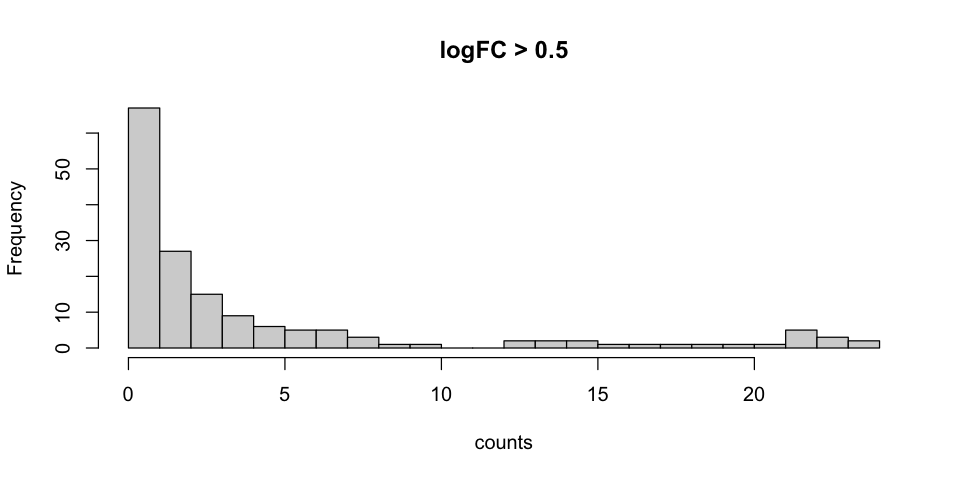

In [19]:
degs.pos.unlist <- unlist(degs.pos)
length(degs.pos.unlist)
length(unique(degs.pos.unlist))

options(repr.plot.width=8, repr.plot.height=4)
counts <- table(degs.pos.unlist)
hist(counts, breaks = 0:length(degs_list), main = 'logFC > 0.5')

A total of 759 genes were detected as positive DEGs, and excluding duplicates, 160 genes were detected.

In [20]:
sum(counts>1)

[1] 94

94 of 161 genes were detected as DEGs at least 2 clusters

$ectoderm_hindgut_dorsal
[1] 6.5

$ectoderm_intermediate_NE_abdominal
[1] 13.5

$amnioserosa_trunk
[1] 15

$ectoderm_intermediate_DE_abdominal
[1] 15

$ectoderm_lateral_NE_abdominal
[1] 16

$endoderm_postMG_ventral
[1] 22

$ectoderm_medial_DE_abdominal
[1] 15

$ectoderm_PS14_dorsal
[1] 13.5

$ectoderm_hindgut_ventral
[1] 21.5

$ectoderm_PS13_dorsal
[1] 15.5

$mesoderm_PS13
[1] 7.5

$mesoderm_PS5_and_abdominal_odd
[1] 7

$mesoderm_PS14
[1] 17.5

$ectoderm_lateral_DE_abdominal
[1] 15

$mesoderm_PS4_and_PS6
[1] 6

$midline_cells
[1] 17

$ectoderm_medial_NE_abdominal
[1] 15.5

$mesoderm_abdominal_even
[1] 10.5

$endoderm_postMG_lateral
[1] 8

$`ectoderm_PS14/hindgut`
[1] 20

$ectoderm_PS14_ventral
[1] 14

$endoderm_postMG_dorsal
[1] 4

$mesoderm_caudal_visceral
[1] 22

$`amnioserosa_PS13-14`
[1] 22

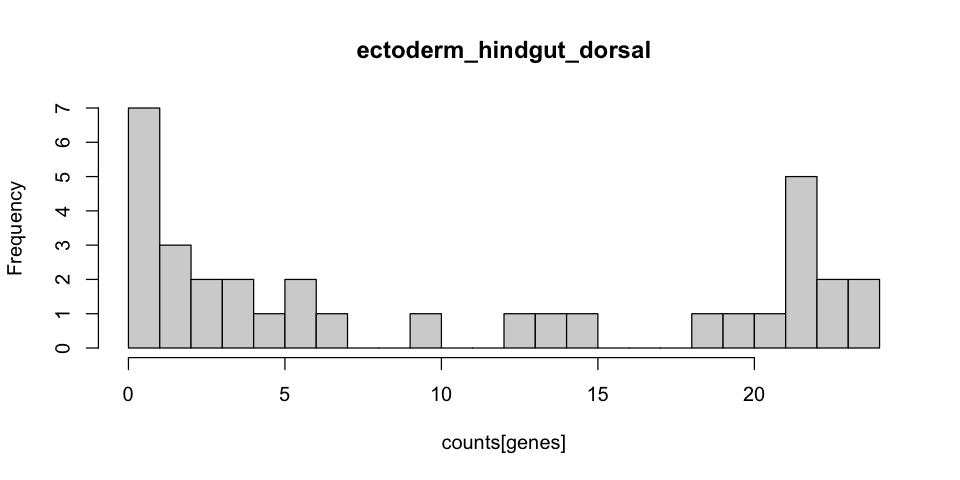

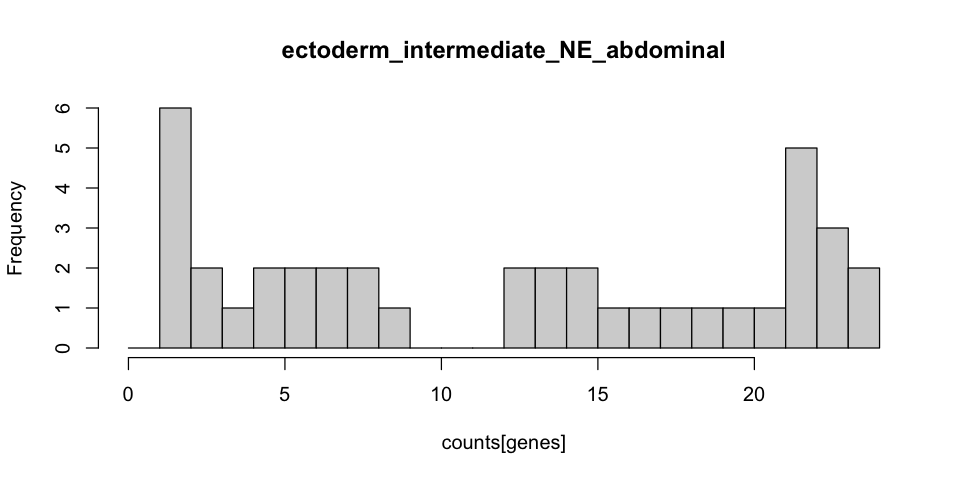

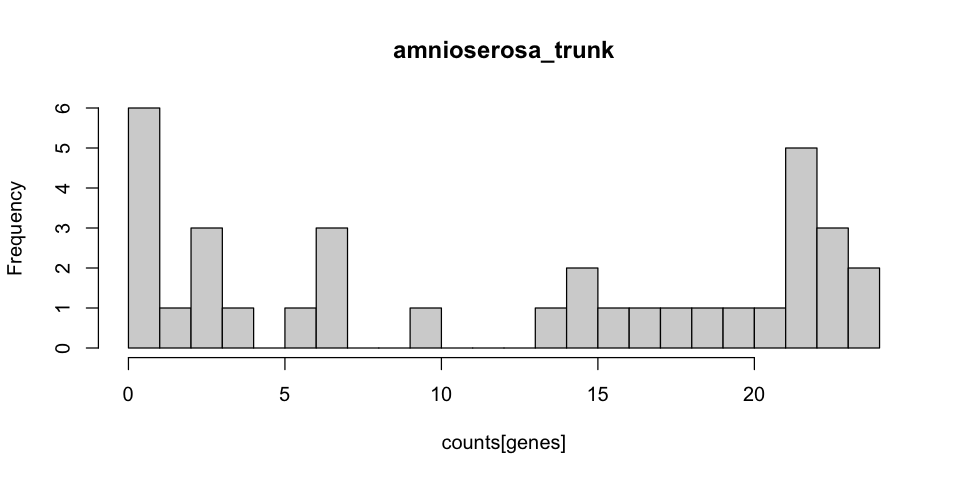

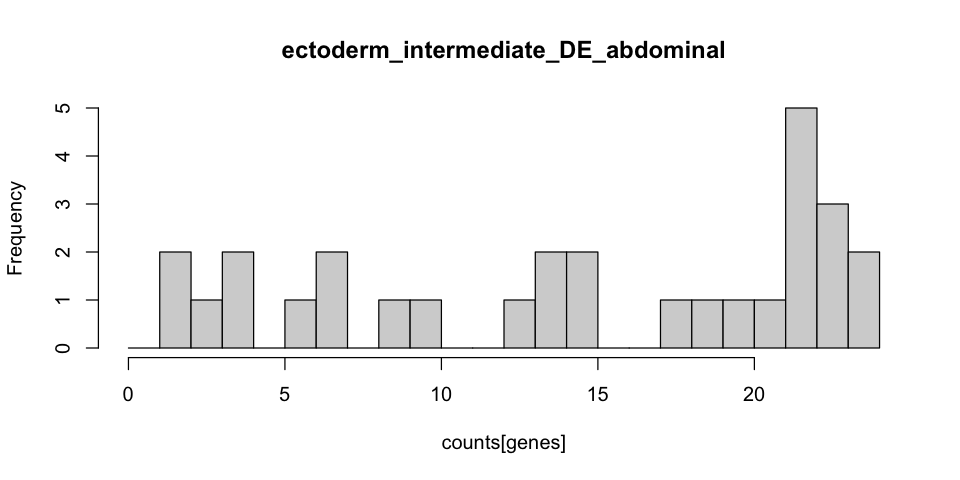

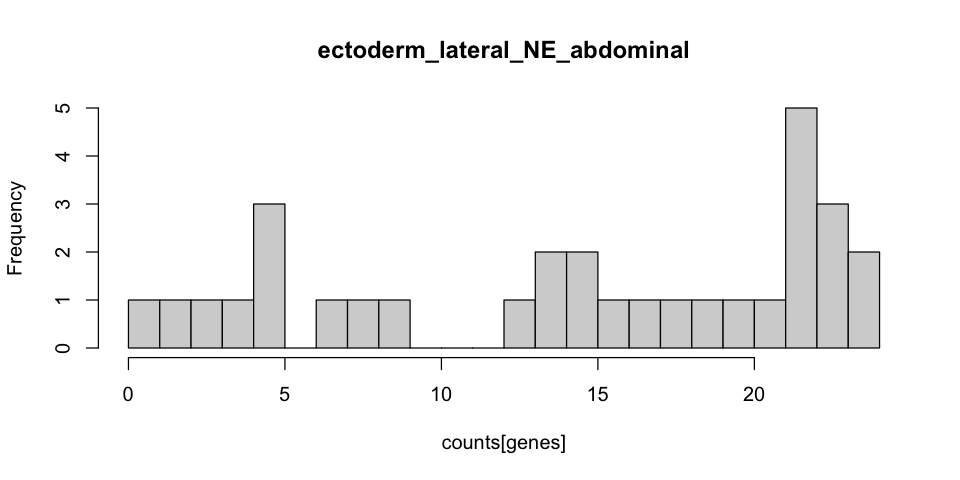

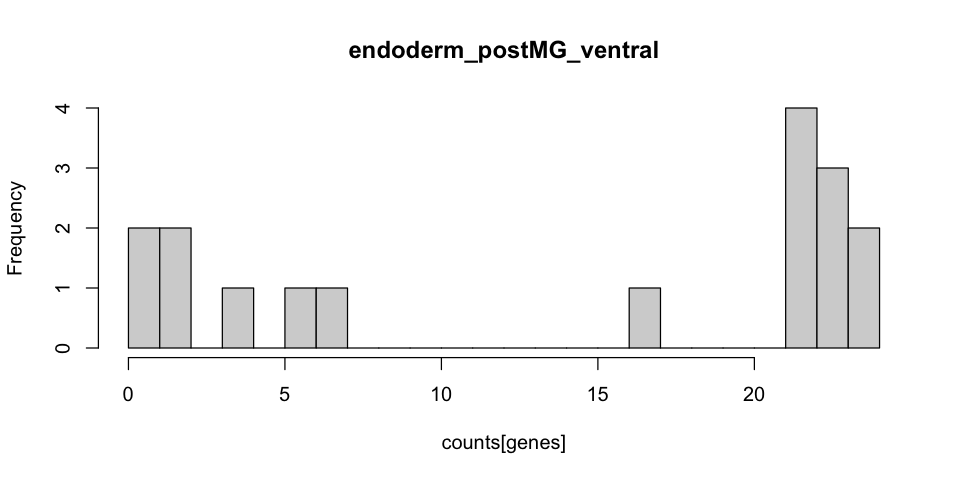

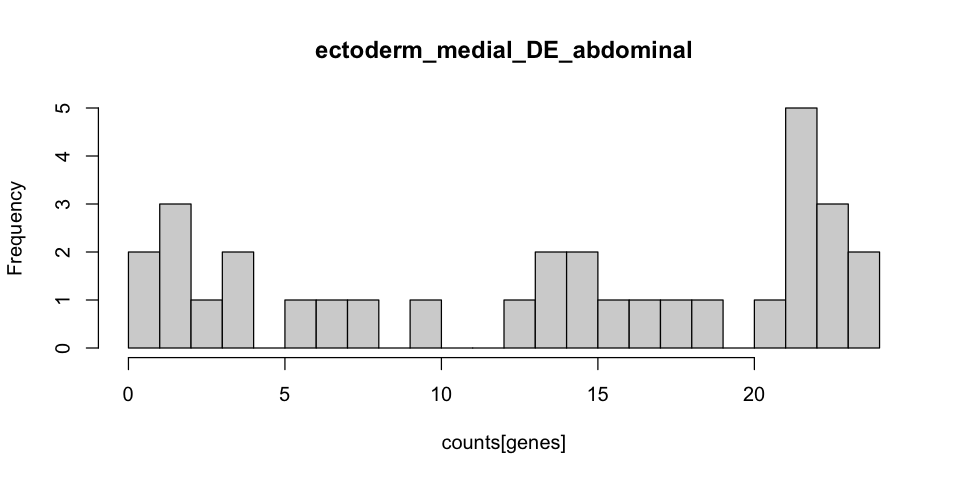

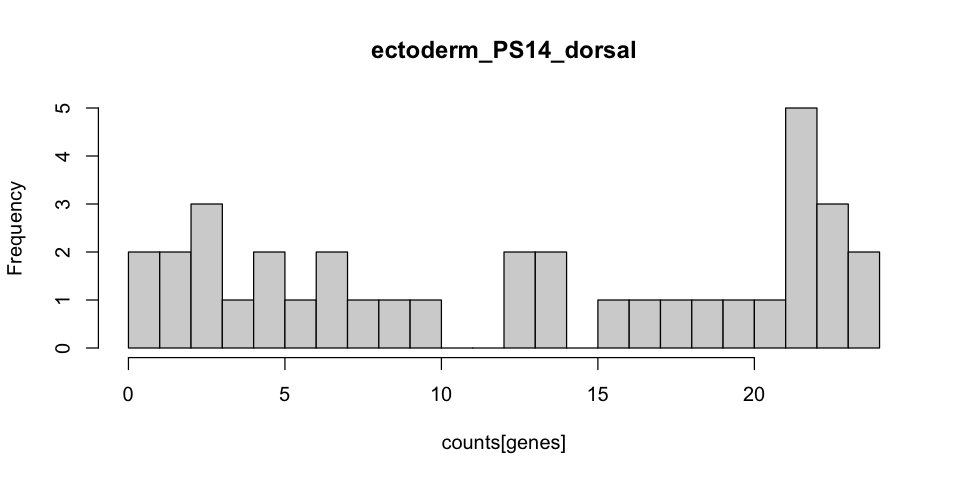

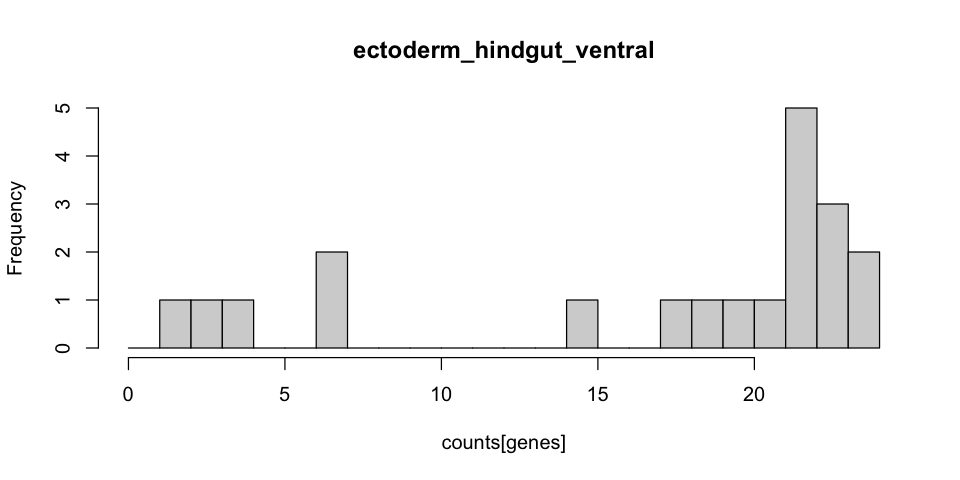

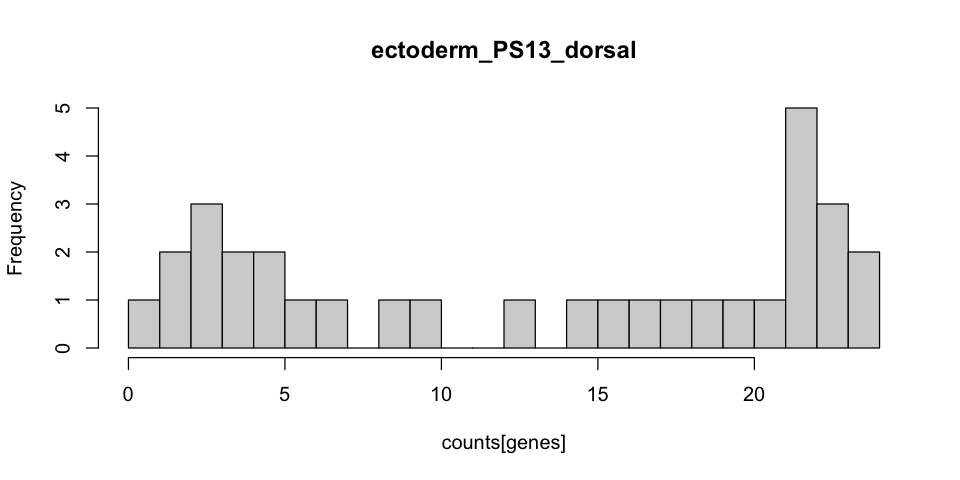

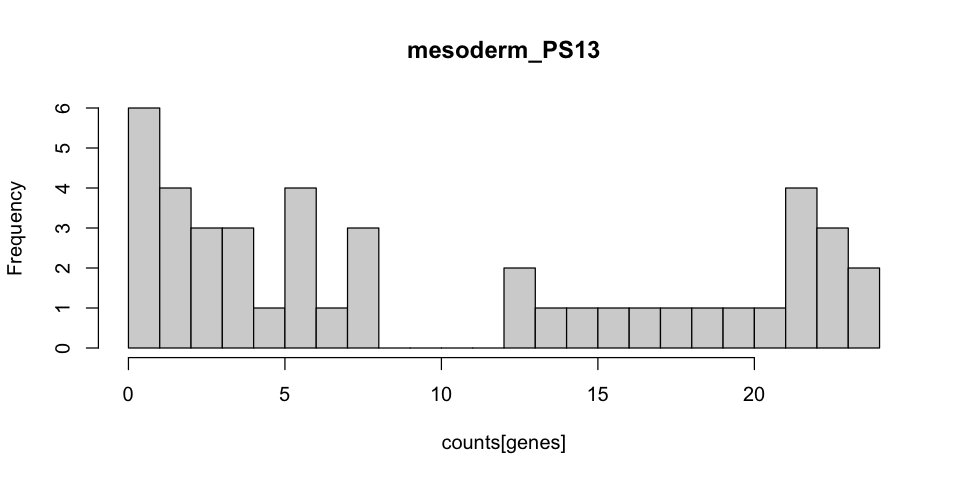

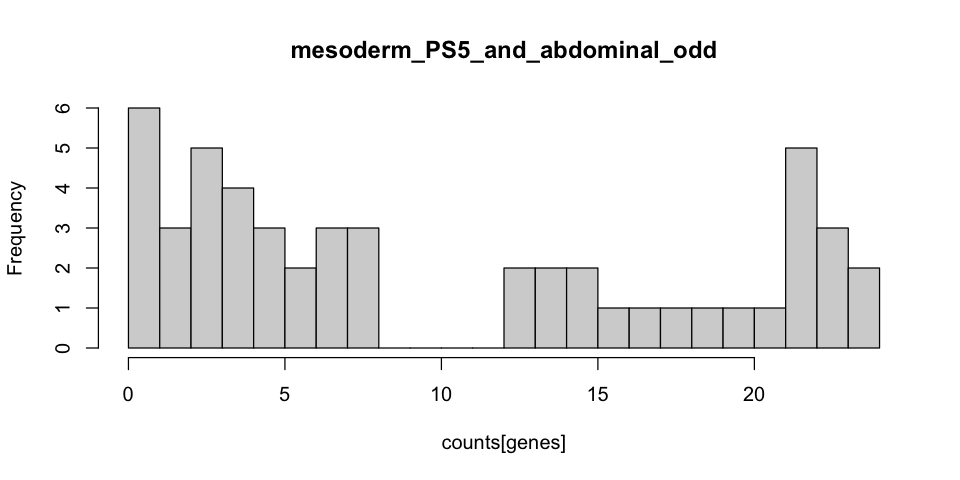

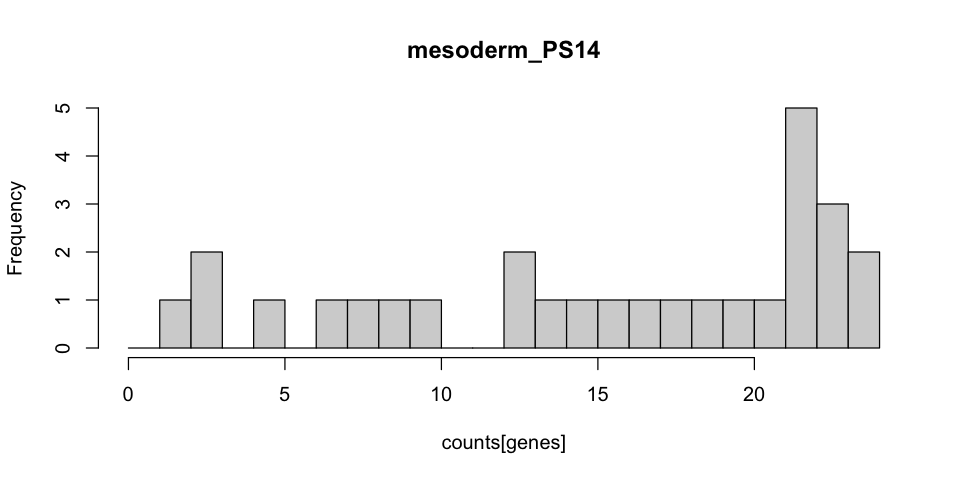

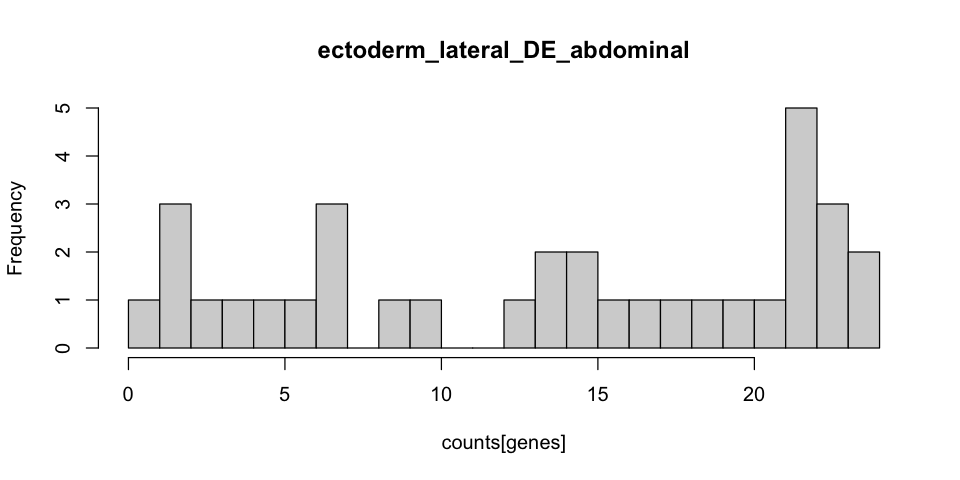

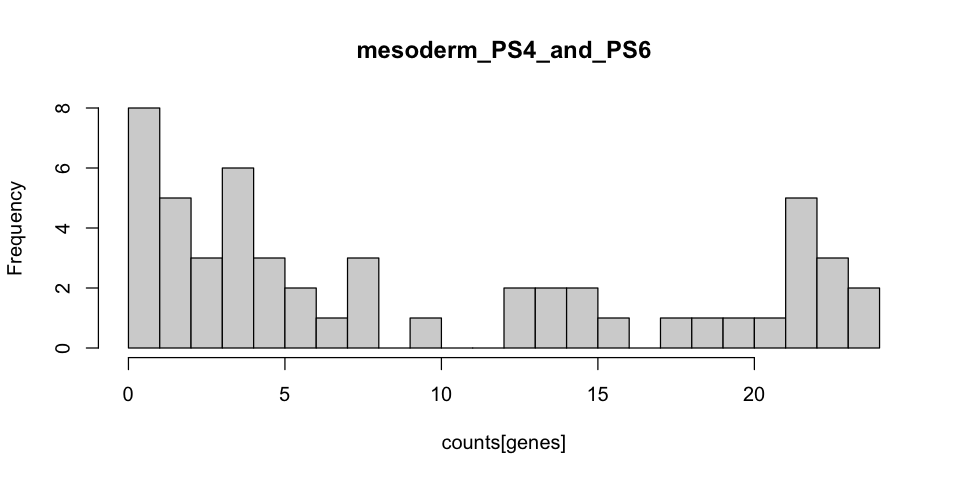

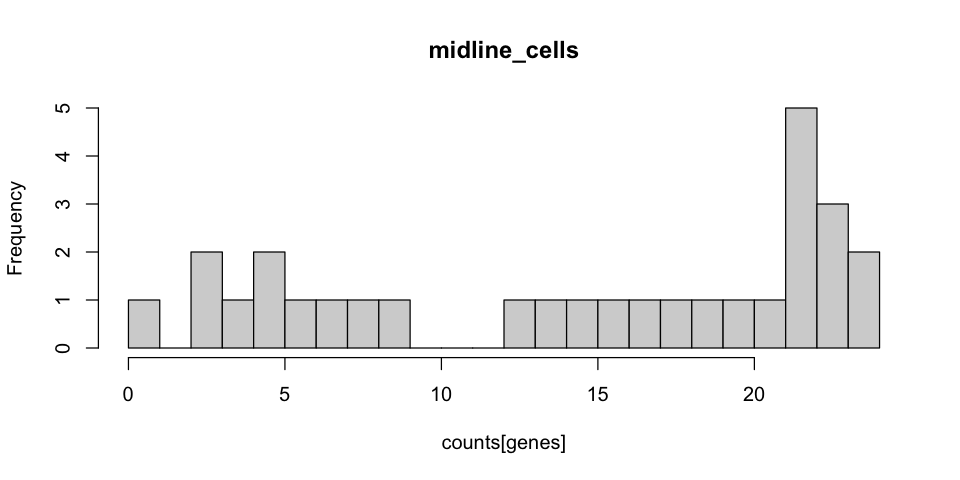

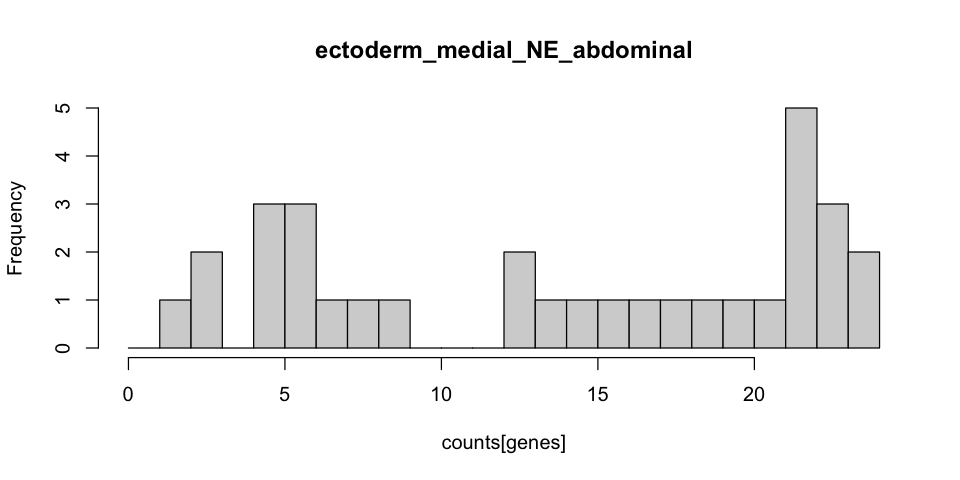

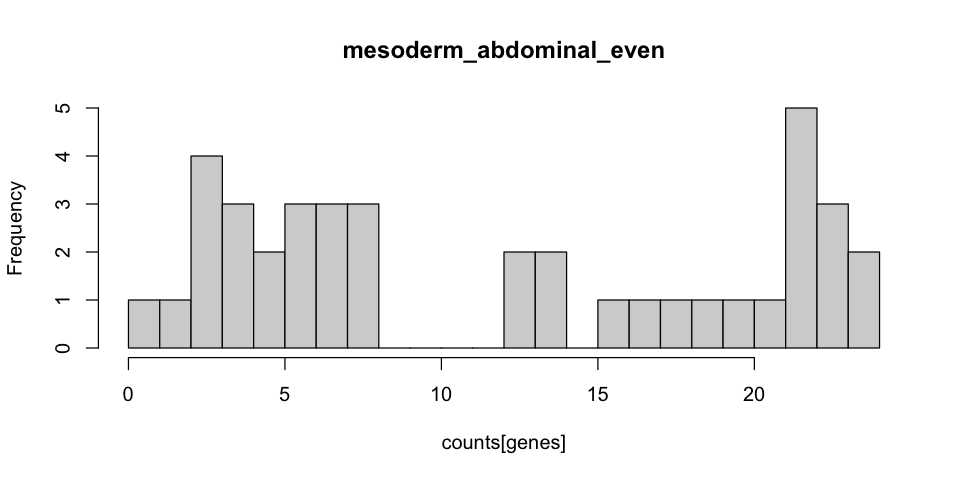

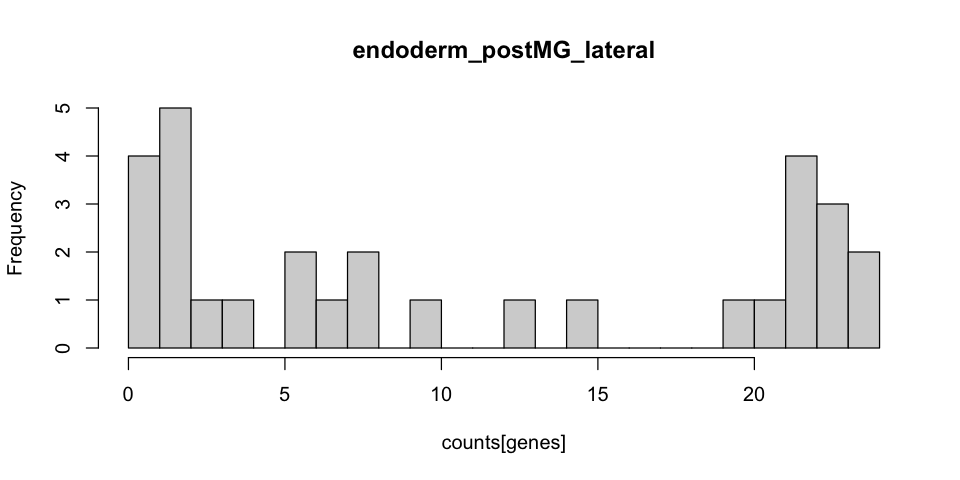

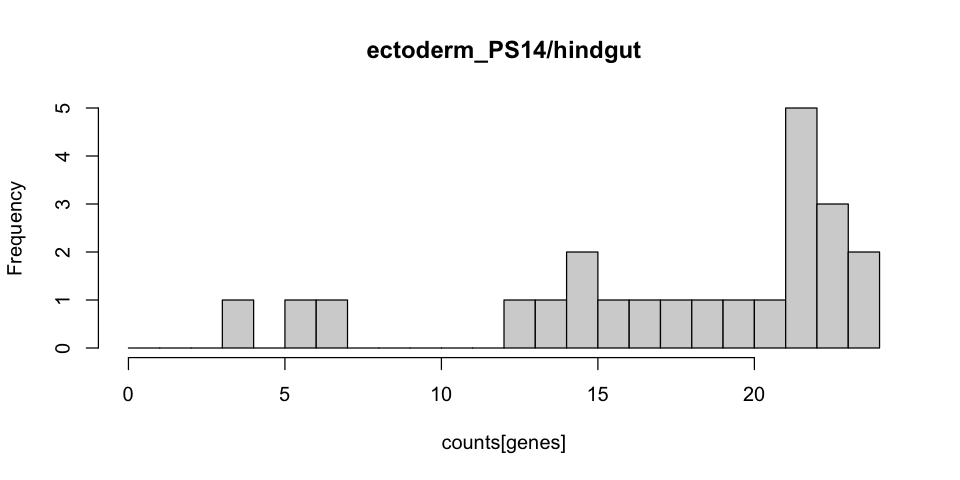

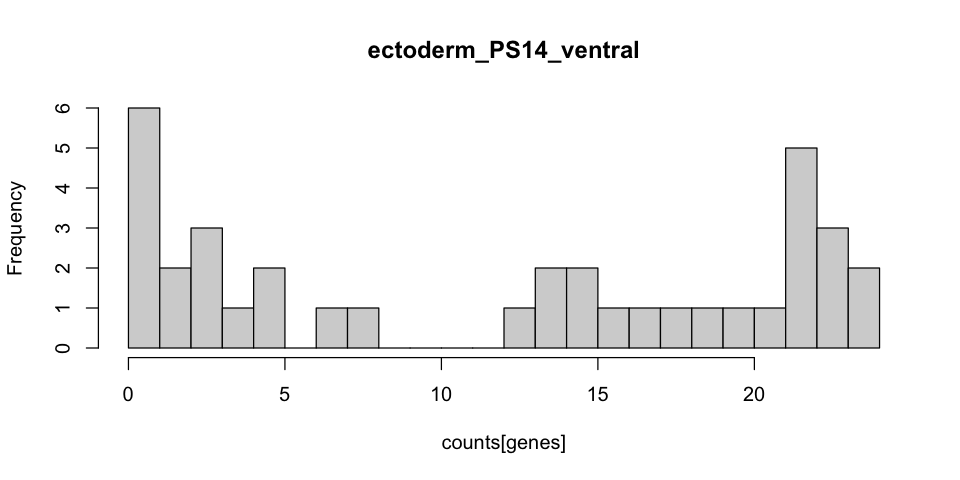

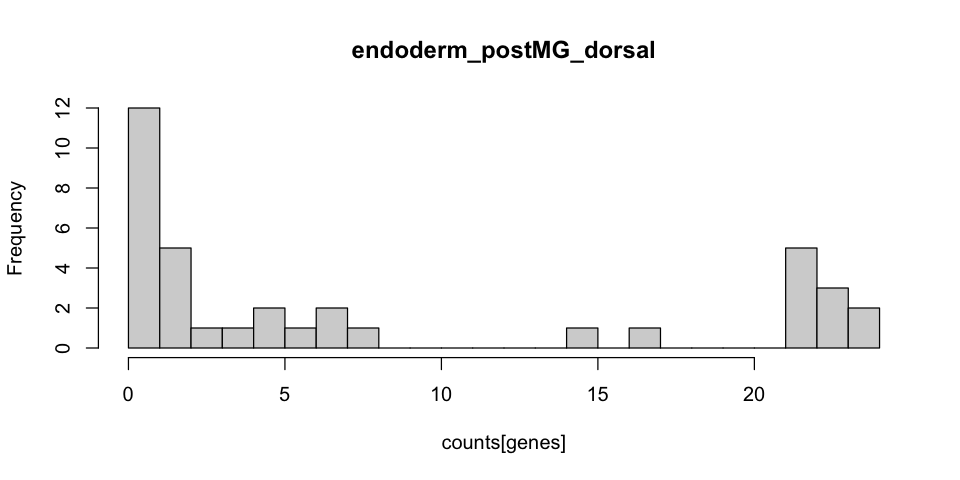

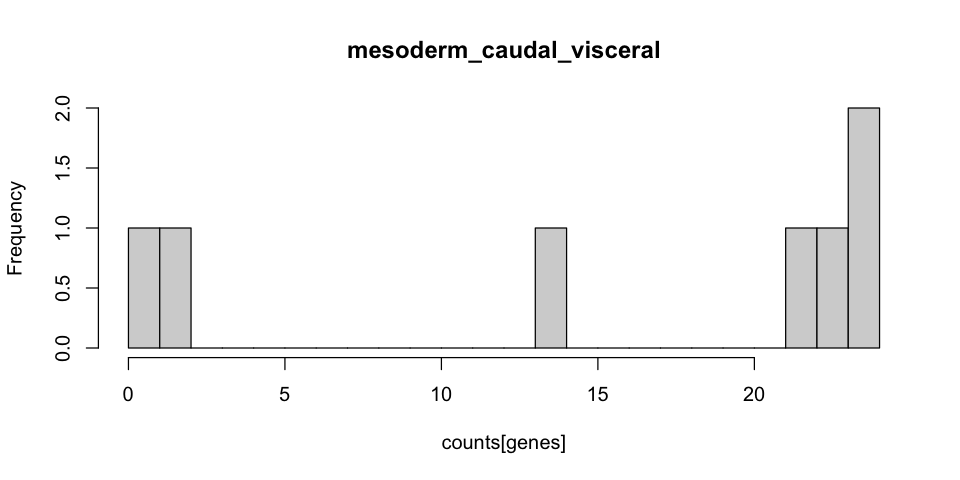

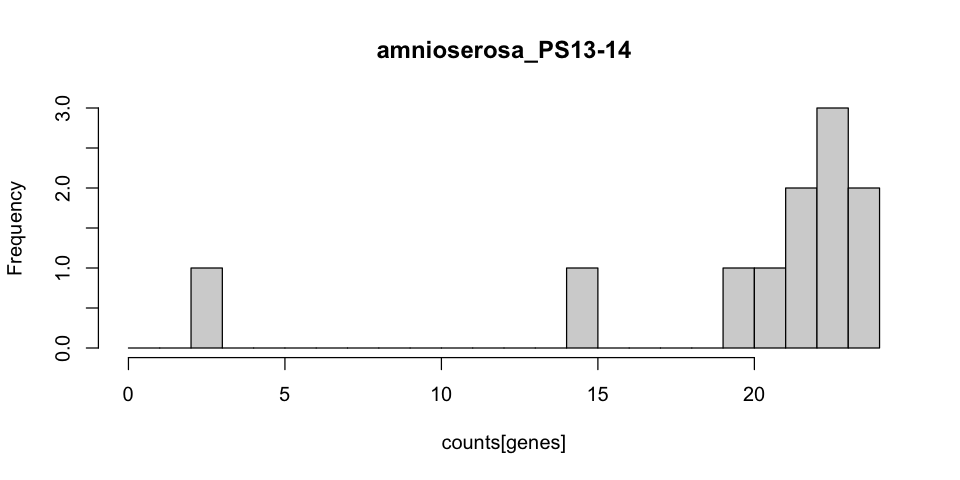

In [21]:
lapply(degs.pos, FUN = function(genes){
    return(median(counts[genes]))
})

for (c in names(degs.pos)){
    genes <- degs.pos[[c]]
    options(repr.plot.width=8, repr.plot.height=4)
    hist(counts[genes], main = c, breaks = seq(0,length(degs_list),1))
}

In [22]:
trunk.levels <- c('amnioserosa_trunk','ectoderm_medial_DE_abdominal', 'ectoderm_intermediate_DE_abdominal', 
            'ectoderm_lateral_DE_abdominal','ectoderm_lateral_NE_abdominal',
            'ectoderm_intermediate_NE_abdominal','ectoderm_medial_NE_abdominal', 'midline_cells',
           'mesoderm_PS4_and_PS6','mesoderm_PS5_and_abdominal_odd', 'mesoderm_abdominal_even')

post.levels <- c('amnioserosa_PS13-14','ectoderm_PS13_dorsal','ectoderm_PS14_dorsal','ectoderm_PS14_ventral',
            'mesoderm_PS13','mesoderm_PS14','mesoderm_caudal_visceral',
            'ectoderm_PS14/hindgut','ectoderm_hindgut_dorsal','ectoderm_hindgut_ventral',
           'endoderm_postMG_dorsal','endoderm_postMG_lateral','endoderm_postMG_ventral')

length(trunk.levels)
length(post.levels)

[1] 11

[1] 13

cluster                            count n_sharing_clusters
1 ectoderm_hindgut_dorsal            15    1 <= n <= 5       
2 ectoderm_intermediate_NE_abdominal 11    1 <= n <= 5       
3 amnioserosa_trunk                  11    1 <= n <= 5       
4 ectoderm_intermediate_DE_abdominal 5     1 <= n <= 5       
5 ectoderm_lateral_NE_abdominal      7     1 <= n <= 5       
6 endoderm_postMG_ventral            5     1 <= n <= 5

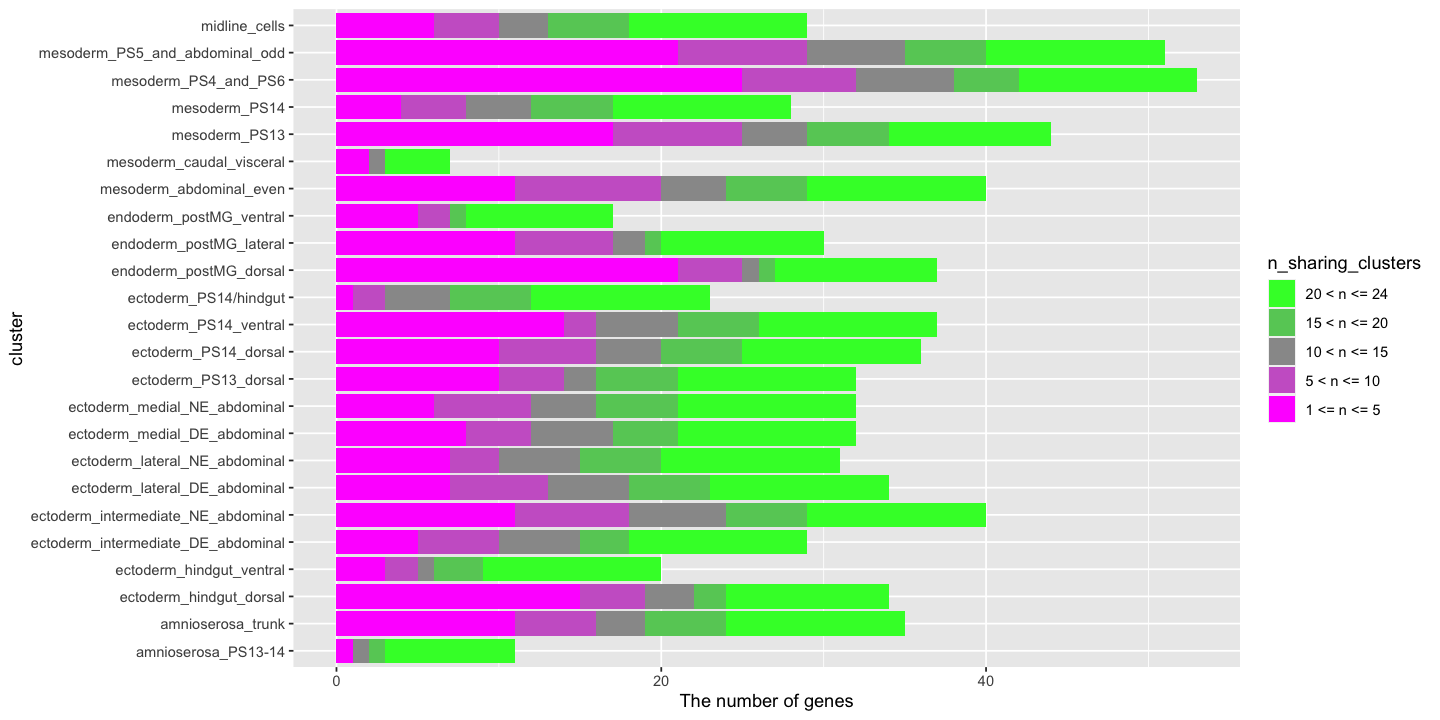

In [23]:
df.1to5 <- data.frame(cluster = names(degs.pos))
df.1to5$count <- lapply(degs.pos, FUN = function(genes){
    n <- sum(counts[genes] > 0) - sum(counts[genes] > 5)
    return(n)
})
df.1to5$n_sharing_clusters <- '1 <= n <= 5'

df.6to10 <- data.frame(cluster = names(degs.pos))
df.6to10$count <- lapply(degs.pos, FUN = function(genes){
    n <- sum(counts[genes] > 5) - sum(counts[genes] > 10)
    return(n)
})
df.6to10$n_sharing_clusters <- '5 < n <= 10'


df.11to15 <- data.frame(cluster = names(degs.pos))
df.11to15$count <- lapply(degs.pos, FUN = function(genes){
    n <- sum(counts[genes] > 10) - sum(counts[genes] > 15)
    return(n)
})
df.11to15$n_sharing_clusters <- '10 < n <= 15'

df.16to20 <- data.frame(cluster = names(degs.pos))
df.16to20$count <- lapply(degs.pos, FUN = function(genes){
    n <- sum(counts[genes] > 15) - sum(counts[genes] > 20)
    return(n)
})
df.16to20$n_sharing_clusters <- '15 < n <= 20'

df.21to24 <- data.frame(cluster = names(degs.pos))
df.21to24$count <- lapply(degs.pos, FUN = function(genes){
    n <- sum(counts[genes] > 20)
    return(n)
})
df.21to24$n_sharing_clusters <- '20 < n <= 24'

df <- rbind(df.1to5,df.6to10,df.11to15,df.16to20,df.21to24)

df <- transform(df, n_sharing_clusters = factor(n_sharing_clusters, 
                                                levels = c('20 < n <= 24','15 < n <= 20','10 < n <= 15',
                                                           '5 < n <= 10','1 <= n <= 5')))
head(df)

options(repr.plot.width=12, repr.plot.height=6)
g <- ggplot(df, aes(x = cluster, y = count, fill = n_sharing_clusters))
g <- g + geom_bar(stat = "identity")
g <- g + scale_fill_manual(values = c("#33FF33", "#66CC66", "#999999", "#CC66CC", "#FF33FF"))
g <- g + coord_flip()
g <- g + ylab('The number of genes')
plot(g)
ggsave(g, file = "./figures/2_bcdRNAi_DEGs/positive_markers_n_sharing.eps", dpi = 300, width = 12, height = 6)

In [24]:
n_over13 <- lapply(degs.pos, FUN = function(genes){
    n <- sum(counts[genes]>13)
    n <- n/length(genes)
    return(n)
})
n_over13

$ectoderm_hindgut_dorsal
[1] 0.4117647

$ectoderm_intermediate_NE_abdominal
[1] 0.5

$amnioserosa_trunk
[1] 0.5428571

$ectoderm_intermediate_DE_abdominal
[1] 0.6206897

$ectoderm_lateral_NE_abdominal
[1] 0.6451613

$endoderm_postMG_ventral
[1] 0.5882353

$ectoderm_medial_DE_abdominal
[1] 0.59375

$ectoderm_PS14_dorsal
[1] 0.5

$ectoderm_hindgut_ventral
[1] 0.75

$ectoderm_PS13_dorsal
[1] 0.53125

$mesoderm_PS13
[1] 0.3863636

$mesoderm_PS5_and_abdominal_odd
[1] 0.3921569

$mesoderm_PS14
[1] 0.6428571

$ectoderm_lateral_DE_abdominal
[1] 0.5882353

$mesoderm_PS4_and_PS6
[1] 0.3584906

$midline_cells
[1] 0.6206897

$ectoderm_medial_NE_abdominal
[1] 0.5625

$mesoderm_abdominal_even
[1] 0.45

$endoderm_postMG_lateral
[1] 0.4

$`ectoderm_PS14/hindgut`
[1] 0.826087

$ectoderm_PS14_ventral
[1] 0.5405405

$endoderm_postMG_dorsal
[1] 0.3243243

$mesoderm_caudal_visceral
[1] 0.7142857

$`amnioserosa_PS13-14`
[1] 0.9090909

In [25]:
min(unlist(n_over13))
max(unlist(n_over13))

[1] 0.3243243

[1] 0.9090909

cluster                            count n_sharing_clusters
1 ectoderm_hindgut_dorsal            19    1 <= n <= 13      
2 ectoderm_intermediate_NE_abdominal 18    1 <= n <= 13      
3 amnioserosa_trunk                  16    1 <= n <= 13      
4 ectoderm_intermediate_DE_abdominal 10    1 <= n <= 13      
5 ectoderm_lateral_NE_abdominal      10    1 <= n <= 13      
6 endoderm_postMG_ventral            7     1 <= n <= 13

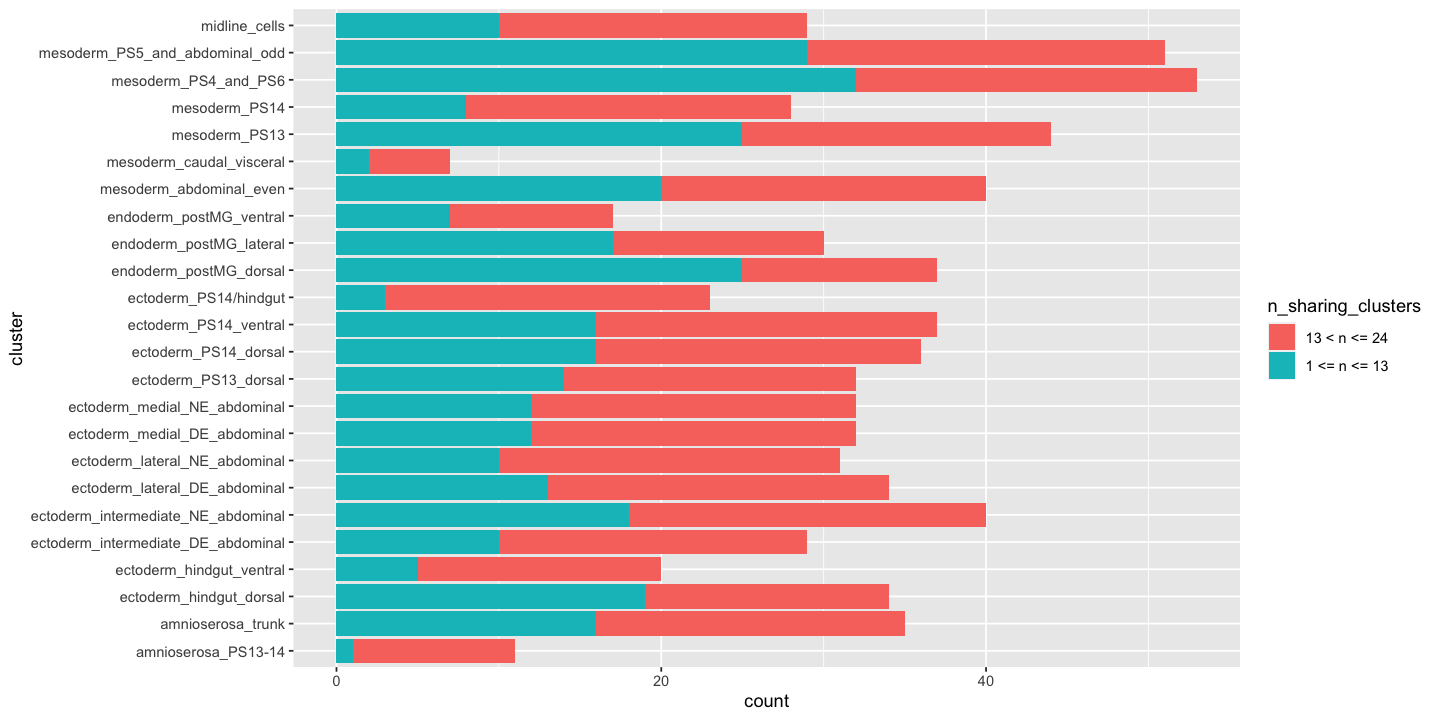

In [26]:
df.1to10 <- data.frame(cluster = names(degs.pos))
df.1to10$count <- lapply(degs.pos, FUN = function(genes){
    n <- sum(counts[genes] <= 10)
    return(n)
})
df.1to10$n_sharing_clusters <- '1 <= n <= 13'


df.11to20 <- data.frame(cluster = names(degs.pos))
df.11to20$count <- lapply(degs.pos, FUN = function(genes){
    n <- sum(counts[genes] > 10)
    return(n)
})
df.11to20$n_sharing_clusters <- '13 < n <= 24'

df <- rbind(df.1to10,df.11to20)

df <- transform(df, n_sharing_clusters = factor(n_sharing_clusters, 
                                                levels = c('13 < n <= 24','1 <= n <= 13')))
head(df)

options(repr.plot.width=12, repr.plot.height=6)
g <- ggplot(df, aes(x = cluster, y = count, fill = n_sharing_clusters))
g <- g + geom_bar(stat = "identity")
g <- g + coord_flip()
plot(g)
ggsave(g, file = "./figures/2_bcdRNAi_DEGs/positive_markers_n_sharing_threshold13.eps", dpi = 300, width = 12, height = 6)

32% to 90% of positive DEGs between bcd-RNAi and control in each cluster were shared by more than 13 clusters (The number of posterior clusters)

In [27]:
seu.obj.list <- SplitObject(seu.wo.head, split.by = 'genotype')
seu.obj.list <- lapply(seu.obj.list, FUN = function(seu){
    Idents(seu) <- 'manual_ID_2'
    return(seu)
})

genes <- names(counts)
length(genes)
avg.5to15.bcd.pos <- AverageExpression(seu.obj.list[['bcd_RNAi']], features = genes)
avg.5to15.bcd.pos <- log(avg.5to15.bcd.pos$SCT)
dim(avg.5to15.bcd.pos)
avg.5to15.set2.pos <- AverageExpression(seu.obj.list[['set_2']], features = genes)
avg.5to15.set2.pos <- log(avg.5to15.set2.pos$SCT)
dim(avg.5to15.set2.pos)

[1] 161

Finished averaging RNA for cluster amnioserosa_trunk

Finished averaging RNA for cluster ectoderm_lateral_NE_abdominal

Finished averaging RNA for cluster endoderm_postMG_lateral

Finished averaging RNA for cluster ectoderm_medial_DE_abdominal

Finished averaging RNA for cluster amnioserosa_PS13-14

Finished averaging RNA for cluster mesoderm_abdominal_even

Finished averaging RNA for cluster ectoderm_lateral_DE_abdominal

Finished averaging RNA for cluster mesoderm_PS4_and_PS6

Finished averaging RNA for cluster ectoderm_PS14_ventral

Finished averaging RNA for cluster ectoderm_PS14/hindgut

Finished averaging RNA for cluster ectoderm_intermediate_NE_abdominal

Finished averaging RNA for cluster ectoderm_PS13_dorsal

Finished averaging RNA for cluster ectoderm_hindgut_ventral

Finished averaging RNA for cluster ectoderm_PS14_dorsal

Finished averaging RNA for cluster ectoderm_medial_NE_abdominal

Finished averaging RNA for cluster ectoderm_intermediate_DE_abdominal

Finished averaging

[1] 161  24

Finished averaging RNA for cluster ectoderm_hindgut_dorsal

Finished averaging RNA for cluster ectoderm_intermediate_NE_abdominal

Finished averaging RNA for cluster amnioserosa_trunk

Finished averaging RNA for cluster ectoderm_intermediate_DE_abdominal

Finished averaging RNA for cluster ectoderm_lateral_NE_abdominal

Finished averaging RNA for cluster endoderm_postMG_ventral

Finished averaging RNA for cluster ectoderm_medial_DE_abdominal

Finished averaging RNA for cluster ectoderm_PS14_dorsal

Finished averaging RNA for cluster ectoderm_hindgut_ventral

Finished averaging RNA for cluster ectoderm_PS13_dorsal

Finished averaging RNA for cluster mesoderm_PS13

Finished averaging RNA for cluster mesoderm_PS5_and_abdominal_odd

Finished averaging RNA for cluster mesoderm_PS14

Finished averaging RNA for cluster ectoderm_lateral_DE_abdominal

Finished averaging RNA for cluster mesoderm_PS4_and_PS6

Finished averaging RNA for cluster midline_cells

Finished averaging RNA for cluster ect

[1] 161  24

In [28]:
avg.logFC.pos.raw <- avg.5to15.bcd.pos - avg.5to15.set2.pos
head(avg.logFC.pos.raw)
avg.logFC.pos <- melt(as.matrix(avg.logFC.pos.raw))
colnames(avg.logFC.pos) <- c("Gene", "Cluster", "val1")
avg.logFC.pos$Value <- apply(avg.logFC.pos, 1, FUN = function(x){
    return(degs_list[[x[2]]][x[1],'avg_logFC'])
} )
avg.logFC.pos[is.na(avg.logFC.pos)] <-  0

avg.logFC.pos$FC0.5 <- as.double(avg.logFC.pos$Value > 0.5)
avg.logFC.pos$Significant <- apply(avg.logFC.pos, 1, FUN = function(x){
    return(as.double(x[1] %in% row.names(degs_list[[x[2]]])))
} )

avg.logFC.pos$PosDEG <- avg.logFC.pos$FC0.5 * avg.logFC.pos$Significant

head(avg.logFC.pos)

amnioserosa_trunk ectoderm_lateral_NE_abdominal endoderm_postMG_lateral
Abd-B 0.03275279         0.5276425                    -0.9904921             
ac           Inf        -0.2643841                     2.5662903             
AGO3  1.02808573         1.0628097                     1.5401698             
Ald   0.74133578         0.9348228                     1.1495424             
Ama   0.32728434         1.2314307                    -1.7359000             
Ank   0.76893991         0.6311932                     0.3304791             
      ectoderm_medial_DE_abdominal amnioserosa_PS13-14 mesoderm_abdominal_even
Abd-B  3.1570859                    3.0885929           2.1810656             
ac     1.3934973                   -1.5468803          -0.2442287             
AGO3   1.2764553                    0.6680869           1.7033509             
Ald    0.7162415                    0.7439041           0.3709243             
Ama   -0.2554046                    1.2038571           0.7514645             
Ank    0.8316861                    0.3782505           0.6295731             
      ectoderm_lateral_DE_abdominal mesoderm_PS4_and_PS6 ectoderm_PS14_ventral
Abd-B  1.0562201                    -3.11262234          4.226796692          
ac     2.8540376                     0.08434115          0.004833707          
AGO3   0.7440150                     1.94405128          1.254393256          
Ald    0.8397387                     0.81853154          0.853934108          
Ama   -0.7504275                     0.17776574          0.651640550          
Ank    0.5375240                     1.00941671          0.651194312          
      ectoderm_PS14/hindgut ⋯ ectoderm_medial_NE_abdominal
Abd-B -2.1654313            ⋯  3.8094415                  
ac    -0.9110688            ⋯  2.3609838                  
AGO3   0.9620588            ⋯  0.6945415                  
Ald    0.8679772            ⋯  0.7658626                  
Ama   -0.8996263            ⋯ -1.2979298                  
Ank    0.6566964            ⋯  0.7602958                  
      ectoderm_intermediate_DE_abdominal mesoderm_PS14 mesoderm_caudal_visceral
Abd-B  0.208432701                        2.8610428     2.6881409              
ac    -1.043042438                       -2.8478034    -0.3937691              
AGO3   0.960461950                        0.8432003     0.7903654              
Ald    0.678018299                        0.9551197     0.7264009              
Ama    0.004319661                        1.9720609    -0.5818539              
Ank    0.520943754                        0.4828210     0.2686065              
      mesoderm_PS13 ectoderm_hindgut_dorsal endoderm_postMG_ventral
Abd-B  5.77138818   0.1228510               -2.99321720            
ac    -0.30691343   1.1939225               -0.07519237            
AGO3   1.44484070   0.9614112                0.83532800            
Ald    0.07227653   0.8866006                0.84325262            
Ama    1.26085386   0.0888669                0.38325926            
Ank    0.81642199   0.7134994                0.33580923            
      mesoderm_PS5_and_abdominal_odd midline_cells endoderm_postMG_dorsal
Abd-B 1.1430865                       0.7819685    -4.7258063            
ac    1.1197061                       1.5619512     2.5580883            
AGO3  0.9167652                       1.5830047     1.8281271            
Ald   0.2104921                       0.9480618     1.1917964            
Ama   1.4086488                      -0.3522614    -2.2116277            
Ank   0.5668740                       0.9306795     0.4418328

Gene  Cluster           val1       Value      FC0.5 Significant PosDEG
1 Abd-B amnioserosa_trunk 0.03275279  0.6616431 1     1           1     
2 ac    amnioserosa_trunk        Inf  0.0000000 0     0           0     
3 AGO3  amnioserosa_trunk 1.02808573  0.4453615 0     1           0     
4 Ald   amnioserosa_trunk 0.74133578  0.7079500 1     1           1     
5 Ama   amnioserosa_trunk 0.32728434 -0.3741797 0     1           0     
6 Ank   amnioserosa_trunk 0.76893991  0.3122802 0     1           0

In [29]:
levels <- c(trunk.levels,post.levels)
avg.logFC.pos <- transform(avg.logFC.pos, 
                           Cluster = factor(Cluster, levels = levels))
gene.levels <- genes[order(counts[genes])]
length(gene.levels)
avg.logFC.pos <- transform(avg.logFC.pos, 
                            Gene = factor(Gene, levels = gene.levels))

[1] 161

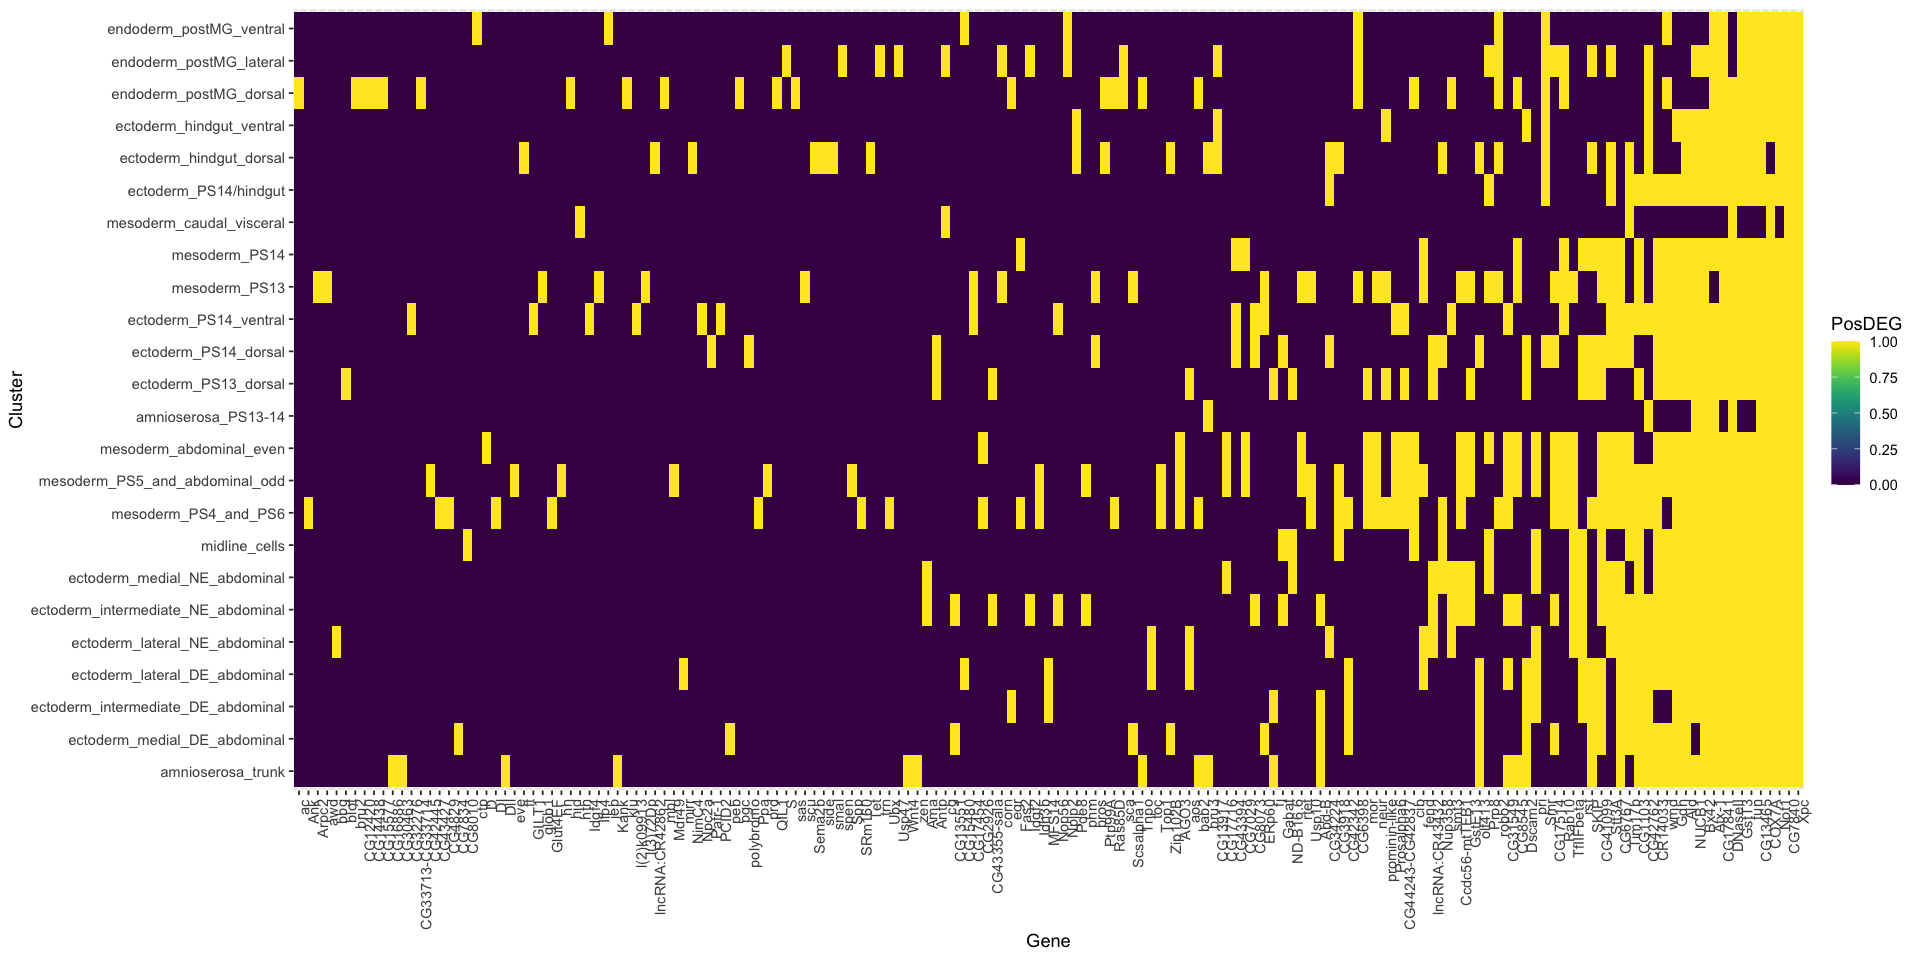

In [30]:
#yellow: detected as DEGs
#purple: not detected as DEGs
options(repr.plot.width=16, repr.plot.height=8)
g <- ggplot(avg.logFC.pos, aes(x = Gene, y = Cluster, fill = PosDEG))
g <- g + geom_tile() + scale_fill_viridis(limits = c(0, 1))
g <- g + theme(axis.text.x = element_text(angle = 90, hjust = 1))
g

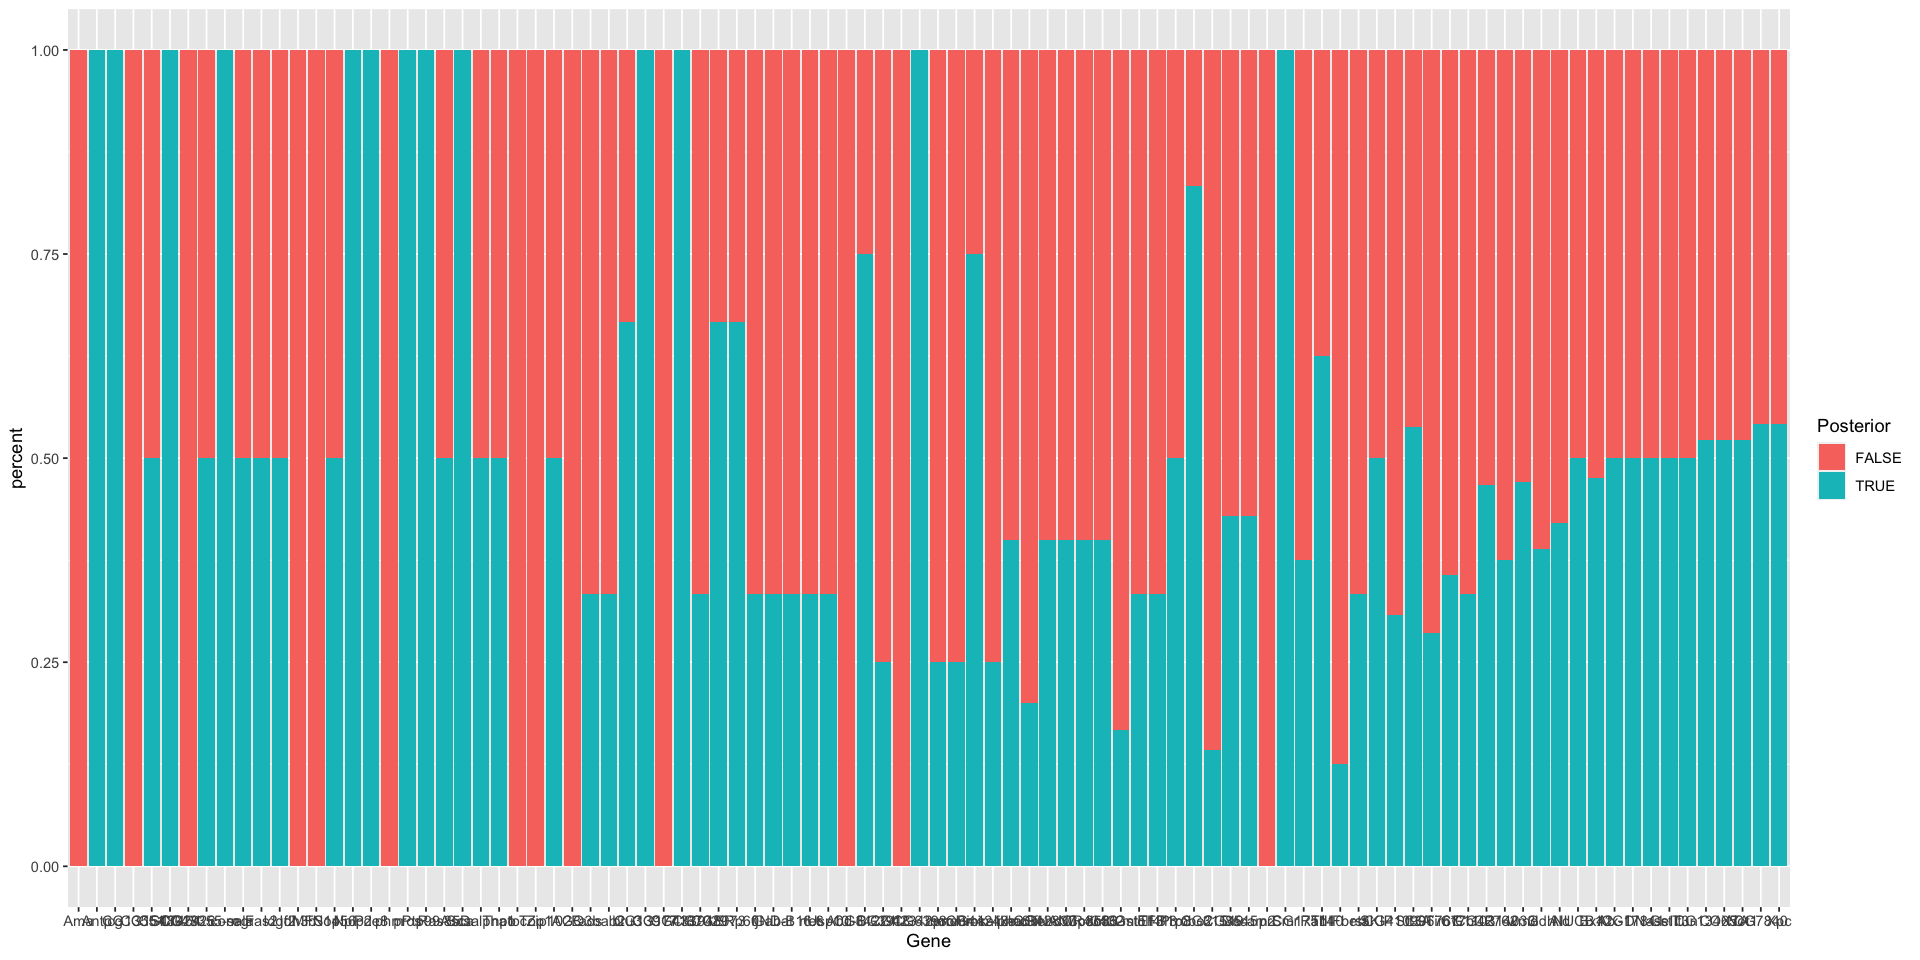

In [31]:
avg.logFC.pos <- transform(avg.logFC.pos, 
                           Cluster = factor(Cluster, levels = levels))
avg.logFC.pos$Posterior <- avg.logFC.pos$Cluster %in% post.levels
d <- as.matrix(table(avg.logFC.pos[avg.logFC.pos$PosDEG==1, c('Gene','Posterior')]))
tot <- apply(d,1,sum)
d <- as.data.frame(d)
d$total <- tot
d <- d[d$total > 1,]
d$percent <- d$Freq/d$total
g <- ggplot(d, aes(x = Gene, y = percent, fill = Posterior))
g <- g + geom_bar(stat = "identity")
g

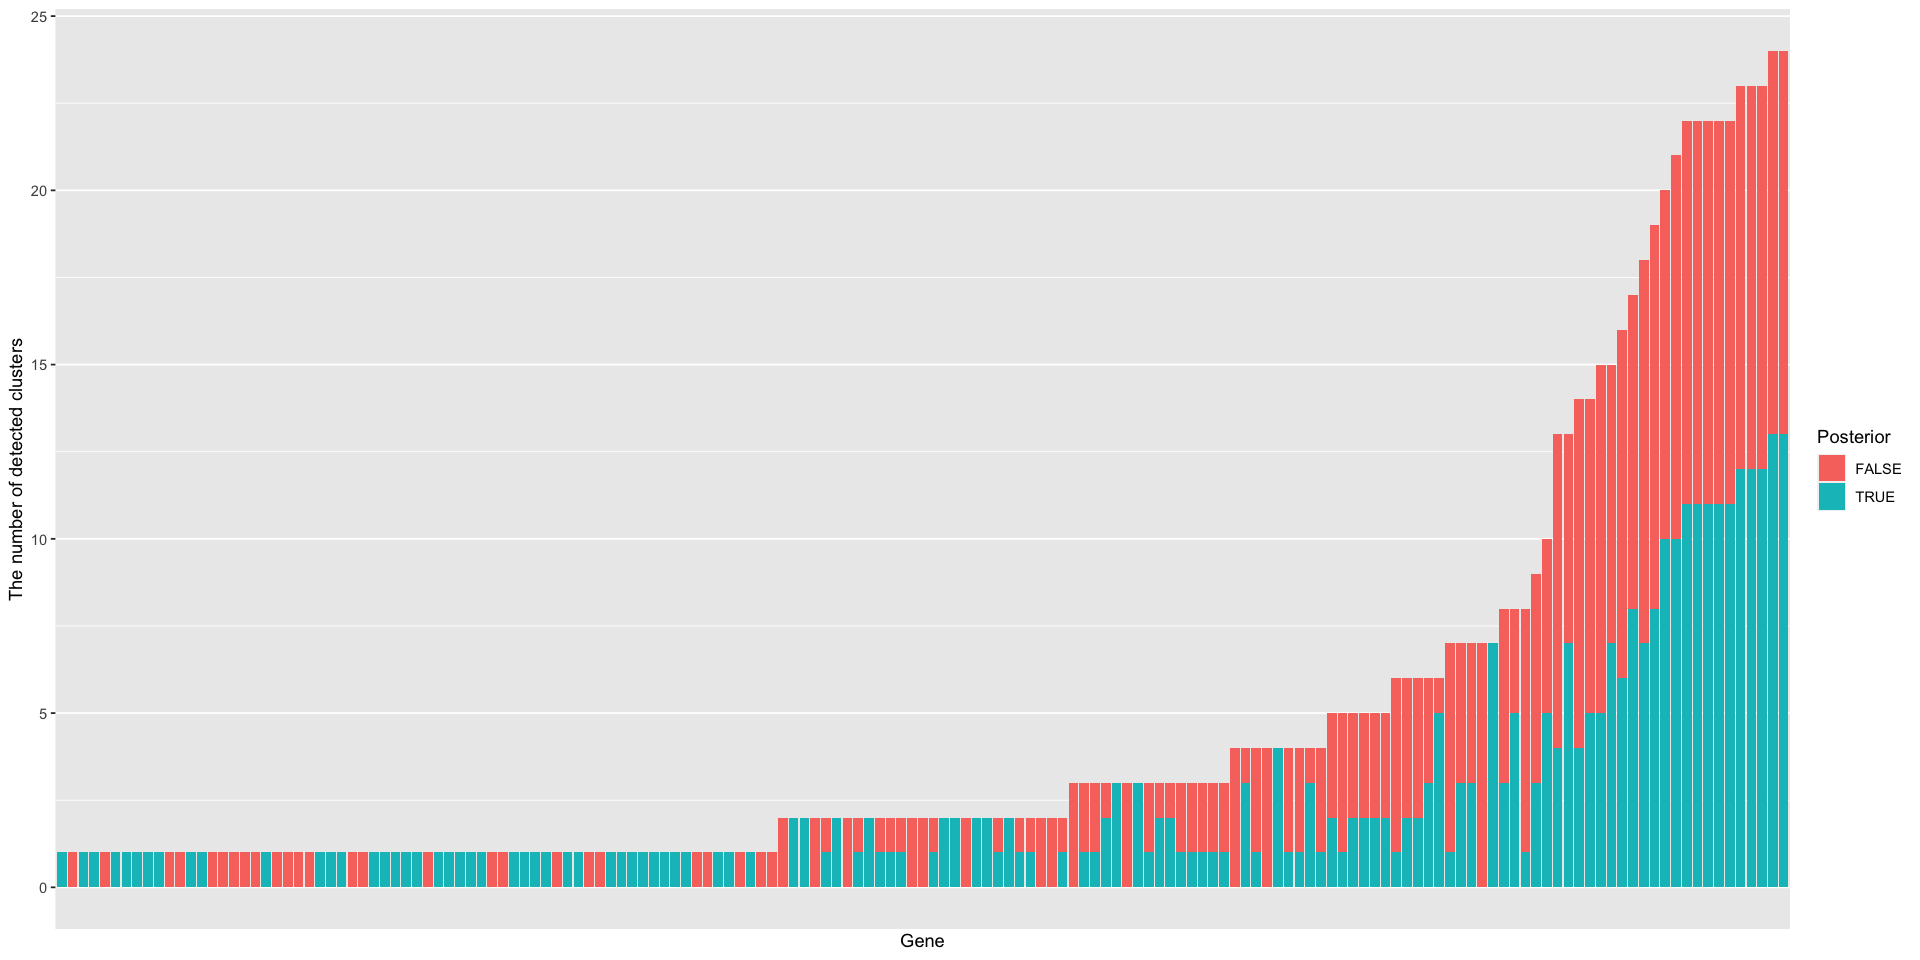

In [32]:
avg.logFC.pos <- transform(avg.logFC.pos, 
                           Cluster = factor(Cluster, levels = levels))
avg.logFC.pos$Posterior <- avg.logFC.pos$Cluster %in% post.levels
d <- as.matrix(table(avg.logFC.pos[avg.logFC.pos$PosDEG==1, c('Gene','Posterior')]))
tot <- apply(d,1,sum)
d <- as.data.frame(d)
d$total <- tot
d$percent <- d$Freq/d$total
g <- ggplot(d, aes(x = Gene, y = Freq, fill = Posterior))
g <- g + geom_bar(stat = "identity")
# g <- g + scale_fill_manual(values = c("#33FF33", "#FF33FF"))
g <- g + scale_x_discrete(breaks = NULL)
g <- g + ylab('The number of detected clusters')
g
ggsave(g, file = "./figures/2_bcdRNAi_DEGs/positive_markers_posterior_or_trunk.eps", dpi = 300, width = 16, height = 8)

In [33]:
post.specific.pos <- d$Gene[d$percent == 1]
length(post.specific.pos)
post.specific.pos

[1] 93

[1] Ank             bbg             CG16886         CG30463        
 [5] CG42445         CG43427         CG4829          CG7834         
 [9] CG8010          D               Dl              Dll            
[13] eve             Glut4EF         hh              Kank           
[17] Mdr49           mirr            peb             Ppa            
[21] prd             Spp             SRm160          Ubx            
[25] Wnt4            zen             Ama             CG13551        
[29] CG2926          Idh3b           MFS14           phm            
[33] toc             Top1            AGO3            CG17716        
[37] Abd-B           CG42342         pri             ac             
[41] Arpc2           awd             blot            bru2           
[45] CG12420         CG14438         CG15577         CG32276        
[49] CG33713-CG33714 ctp             ft              GILT1          
[53] glob1           hid             hth             Idgf4          
[57] Ilp4            jeb             klu             l(2)k09913     
[61] l(3)72Dp        lncRNA:CR42862  mbl             NimC4          
[65] Npc2a           Patr-1          PCID2           pgc            
[69] polybromo       QIL1            S               sas            
[73] scu             Sema2b          side            smal           
[77] spen            Tet             trn             Usp47          
[81] Antp            cg              CG17454         corn           
[85] Nplp2           Pde8            pros            Ptp99A         
[89] sca             CG13917         CG43394         CG6398         
[93] Smr            
161 Levels: ac Ank Arpc2 awd bbg blot bru2 CG12420 CG14438 CG15577 ... Xpc

161-93=68 genes were detected both in trunk and posterior

In [34]:
post.specific.pos <- d$Gene[(d$Posterior == 'TRUE')&(d$percent == 1)]
length(post.specific.pos)
post.specific.pos

[1] 54

[1] ac              Arpc2           awd             blot           
 [5] bru2            CG12420         CG14438         CG15577        
 [9] CG32276         CG33713-CG33714 ctp             ft             
[13] GILT1           glob1           hid             hth            
[17] Idgf4           Ilp4            jeb             klu            
[21] l(2)k09913      l(3)72Dp        lncRNA:CR42862  mbl            
[25] NimC4           Npc2a           Patr-1          PCID2          
[29] pgc             polybromo       QIL1            S              
[33] sas             scu             Sema2b          side           
[37] smal            spen            Tet             trn            
[41] Usp47           Antp            cg              CG17454        
[45] corn            Nplp2           Pde8            pros           
[49] Ptp99A          sca             CG13917         CG43394        
[53] CG6398          Smr            
161 Levels: ac Ank Arpc2 awd bbg blot bru2 CG12420 CG14438 CG15577 ... Xpc

Only 54 of 161 genes were specific to posteriors.  
Others were shared by both of trunk and posteior clusters

In [35]:
write(unique(degs.pos.unlist), file = './DEGs/DEGs_pos.txt')
write(post.specific.pos, file = './DEGs/DEGs_pos_post_specific.txt')

## Negative DEGs

In [36]:
Threshoding.FC.neg<- function(df){
    df <- df[df$avg_logFC < - 0.5,]
    degs <- row.names(df) 
}

OnlyNeg <- function(df){
    df <- df[df$avg_logFC > 0,]
    degs <- row.names(df) 
}

degs.neg <- lapply(degs_list, FUN = Threshoding.FC.neg)
lapply(degs.neg, FUN = length)
degs.neg

$ectoderm_hindgut_dorsal
[1] 11

$ectoderm_intermediate_NE_abdominal
[1] 18

$amnioserosa_trunk
[1] 21

$ectoderm_intermediate_DE_abdominal
[1] 20

$ectoderm_lateral_NE_abdominal
[1] 17

$endoderm_postMG_ventral
[1] 17

$ectoderm_medial_DE_abdominal
[1] 18

$ectoderm_PS14_dorsal
[1] 20

$ectoderm_hindgut_ventral
[1] 14

$ectoderm_PS13_dorsal
[1] 17

$mesoderm_PS13
[1] 22

$mesoderm_PS5_and_abdominal_odd
[1] 22

$mesoderm_PS14
[1] 13

$ectoderm_lateral_DE_abdominal
[1] 19

$mesoderm_PS4_and_PS6
[1] 24

$midline_cells
[1] 18

$ectoderm_medial_NE_abdominal
[1] 17

$mesoderm_abdominal_even
[1] 28

$endoderm_postMG_lateral
[1] 29

$`ectoderm_PS14/hindgut`
[1] 17

$ectoderm_PS14_ventral
[1] 21

$endoderm_postMG_dorsal
[1] 18

$mesoderm_caudal_visceral
[1] 5

$`amnioserosa_PS13-14`
[1] 13

$ectoderm_hindgut_dorsal
 [1] "CG15236" "lama"    "Sod3"    "HnRNP-K" "Myc"     "CG32625" "Akap200"
 [8] "BobA"    "CG2493"  "CG2162"  "CG8654" 

$ectoderm_intermediate_NE_abdominal
 [1] "HnRNP-K"   "CG13217"   "Akap200"   "Sod3"      "BobA"      "CG32625"  
 [7] "Pino"      "Unr"       "pum"       "CG2493"    "Esp"       "Myc"      
[13] "Prx2540-1" "CG43693"   "rpr"       "Arc1"      "CG11825"   "Toll-6"   

$amnioserosa_trunk
 [1] "CG13217"                   "BobA"                     
 [3] "Akap200"                   "Lac"                      
 [5] "HnRNP-K"                   "sgl"                      
 [7] "CG15236"                   "lncRNA:alphagamma-element"
 [9] "Sod3"                      "CG32625"                  
[11] "RnrS"                      "HmgZ"                     
[13] "dmpd"                      "uif"                      
[15] "Caf1-105"                  "HipHop"                   
[17] "Arc1"                      "Mnn1"                     
[19] "LBR"                       "tsh"                      
[21] "Myc"                      

$ectoderm_intermediate_DE_abdominal
 [1] "CG13217"   "HnRNP-K"   "BobA"      "Sod3"      "Akap200"   "CG32625"  
 [7] "Caf1-105"  "CG5191"    "Rpb7"      "Myc"       "uif"       "CG42394"  
[13] "Arc1"      "Prx2540-1" "CG13384"   "Hsp83"     "Pino"      "Esp"      
[19] "CG43693"   "CG11825"  

$ectoderm_lateral_NE_abdominal
 [1] "HnRNP-K"   "Akap200"   "Sod3"      "CG13217"   "CG32625"   "BobA"     
 [7] "Pino"      "Unr"       "CG2493"    "Myc"       "hid"       "Prx2540-1"
[13] "CG13384"   "pyr"       "Arc1"      "CG11825"   "Esp"      

$endoderm_postMG_ventral
 [1] "Sod3"    "CG15236" "CG2493"  "CG32625" "BobA"    "CG13217" "Akap200"
 [8] "fkh"     "Hsp83"   "ImpE2"   "CG8654"  "Notum"   "pum"     "Unr"    
[15] "edl"     "Lac"     "ovo"    

$ectoderm_medial_DE_abdominal
 [1] "CG13217"                   "HnRNP-K"                  
 [3] "BobA"                      "Akap200"                  
 [5] "CG32625"                   "Lac"                      
 [7] "Sod3"                      "lncRNA:CR43887"           
 [9] "Myc"                       "uif"                      
[11] "RnrS"                      "CG5191"                   
[13] "rpr"                       "lncRNA:alphagamma-element"
[15] "eIF3j"                     "S6k"                      
[17] "CG15236"                   "CG13384"                  

$ectoderm_PS14_dorsal
 [1] "Sod3"      "Akap200"   "BobA"      "HnRNP-K"   "CG13427"   "CG32625"  
 [7] "GstE1"     "lama"      "CG2493"    "Myc"       "HipHop"    "CG13217"  
[13] "CG1440"    "HIP-R"     "CG5191"    "trsn"      "Prx2540-1" "Arc1"     
[19] "edl"       "CG11825"  

$ectoderm_hindgut_ventral
 [1] "CG15236"         "CG13217"         "HnRNP-K"         "CG32625"        
 [5] "Sod3"            "CG11825"         "CG8654"          "BobA"           
 [9] "Prx2540-1"       "Akap200"         "Prx2540-2"       "CG42662-CG30080"
[13] "CG10417"         "CG2493"         

$ectoderm_PS13_dorsal
 [1] "HnRNP-K"     "BobA"        "Akap200"     "Sod3"        "CG13217"    
 [6] "CG32625"     "Uhg2"        "Myc"         "CG2493"      "Prx2540-1"  
[11] "Hsp83"       "CG11825"     "lncRNA:iab4" "Esp"         "CG43693"    
[16] "Pino"        "abd-A"      

$mesoderm_PS13
 [1] "Sod3"           "HnRNP-K"        "Akap200"        "CG32625"       
 [5] "CG2493"         "lncRNA:CR43887" "CG11275"        "CG10417"       
 [9] "BobA"           "smal"           "Arf79F"         "HIP-R"         
[13] "scrt"           "Act87E"         "Tmhs"           "Nuf2"          
[17] "Dmtn"           "luna"           "Cp1"            "lncRNA:bxd"    
[21] "Hs3st-A"        "GEFmeso"       

$mesoderm_PS5_and_abdominal_odd
 [1] "Sod3"            "HnRNP-K"         "BobA"            "Akap200"        
 [5] "CG32625"         "lncRNA:CR43887"  "RpL22"           "NetB"           
 [9] "Unr"             "CG14715"         "Egfr"            "CG2493"         
[13] "Act87E"          "pum"          

In [37]:
min(unlist(lapply(degs.neg, FUN = length)))
max(unlist(lapply(degs.neg, FUN = length)))

[1] 5

[1] 29

5 to 29 positive DEGs between bcd-RNAi and WT were detected in each clusters

[1] 439

[1] 113

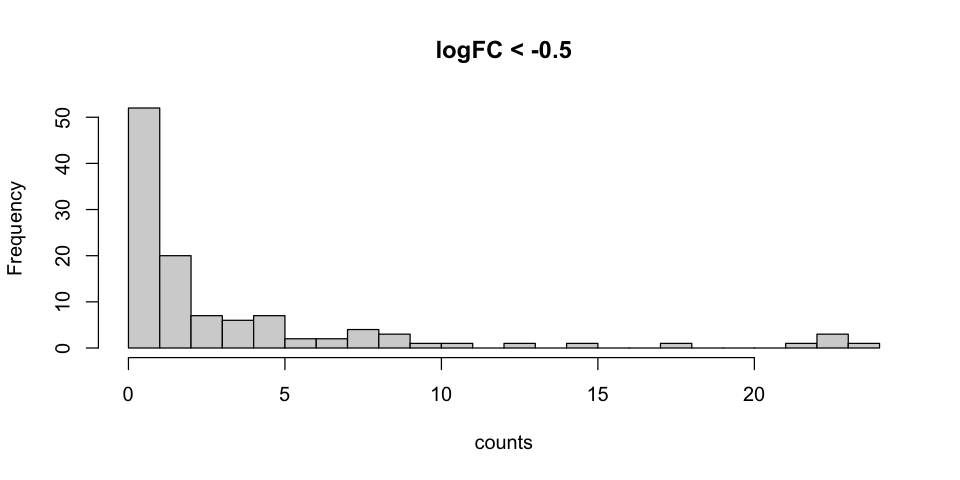

In [38]:
degs.neg.unlist <- unlist(degs.neg)
length(degs.neg.unlist)
length(unique(degs.neg.unlist))

options(repr.plot.width=8, repr.plot.height=4)
counts <- table(degs.neg.unlist)
hist(counts, breaks = 0:24, main = 'logFC < -0.5')

A total of 440 genes were detected as negative DEGs, and excluding duplicates, 114 genes were detected.

In [39]:
sum(counts>1)

[1] 61

61 of 113 genes were detected as DEGs at least 2 clusters

$ectoderm_hindgut_dorsal
[1] 18

$ectoderm_intermediate_NE_abdominal
[1] 10.5

$amnioserosa_trunk
[1] 3

$ectoderm_intermediate_DE_abdominal
[1] 8.5

$ectoderm_lateral_NE_abdominal
[1] 11

$endoderm_postMG_ventral
[1] 6

$ectoderm_medial_DE_abdominal
[1] 7

$ectoderm_PS14_dorsal
[1] 9.5

$ectoderm_hindgut_ventral
[1] 13

$ectoderm_PS13_dorsal
[1] 11

$mesoderm_PS13
[1] 4

$mesoderm_PS5_and_abdominal_odd
[1] 5.5

$mesoderm_PS14
[1] 8

$ectoderm_lateral_DE_abdominal
[1] 10

$mesoderm_PS4_and_PS6
[1] 5

$midline_cells
[1] 8

$ectoderm_medial_NE_abdominal
[1] 10

$mesoderm_abdominal_even
[1] 4.5

$endoderm_postMG_lateral
[1] 5

$`ectoderm_PS14/hindgut`
[1] 10

$ectoderm_PS14_ventral
[1] 8

$endoderm_postMG_dorsal
[1] 7

$mesoderm_caudal_visceral
[1] 23

$`amnioserosa_PS13-14`
[1] 9

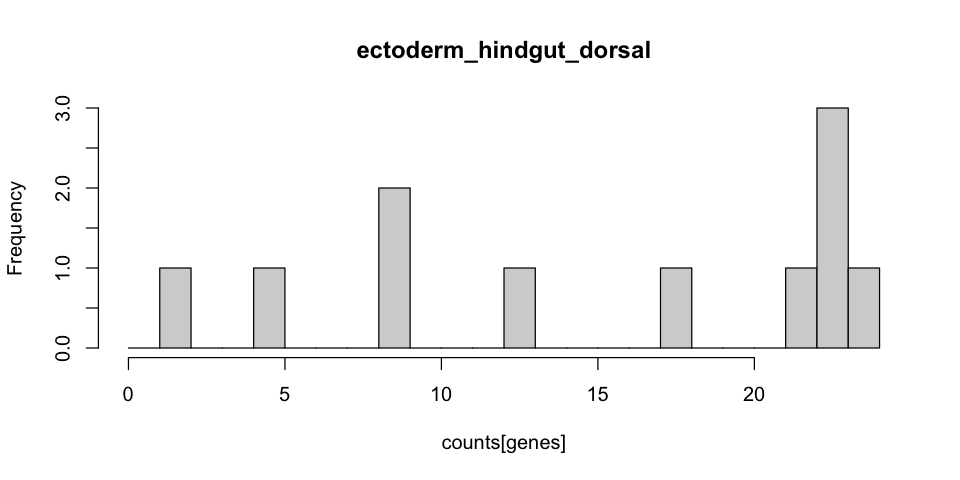

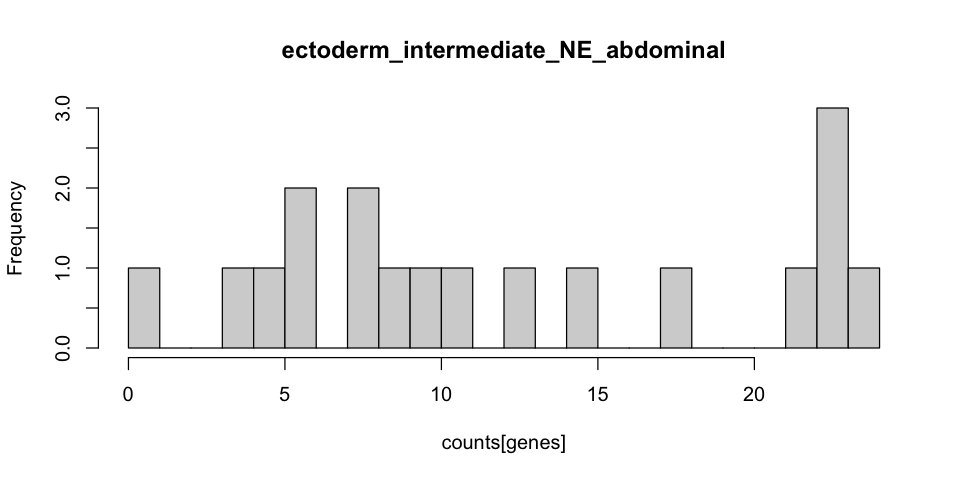

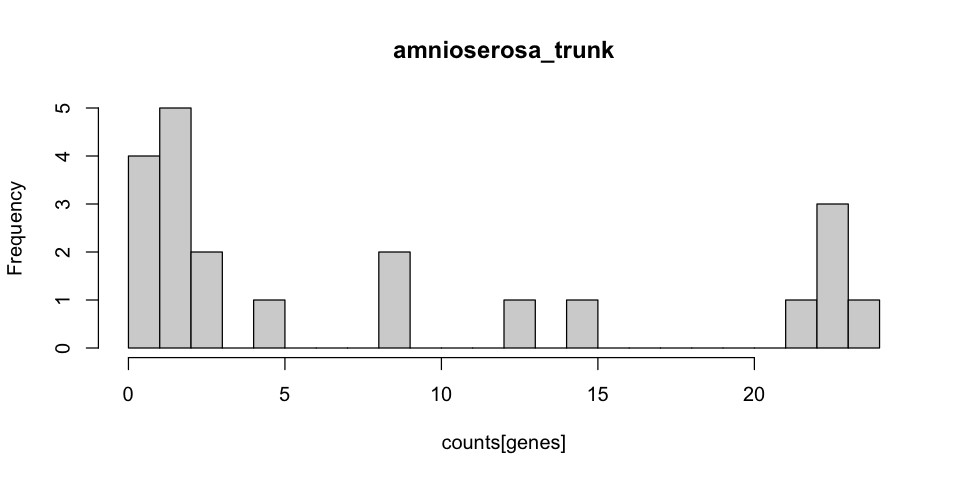

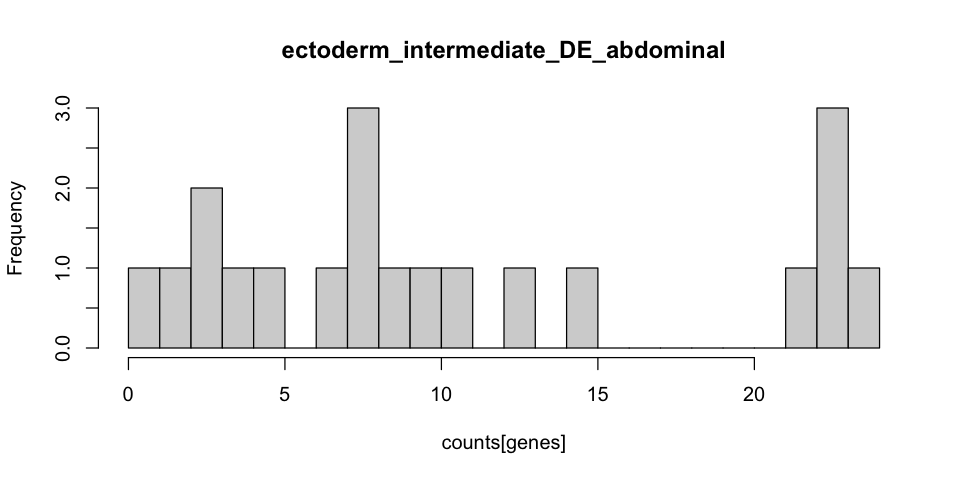

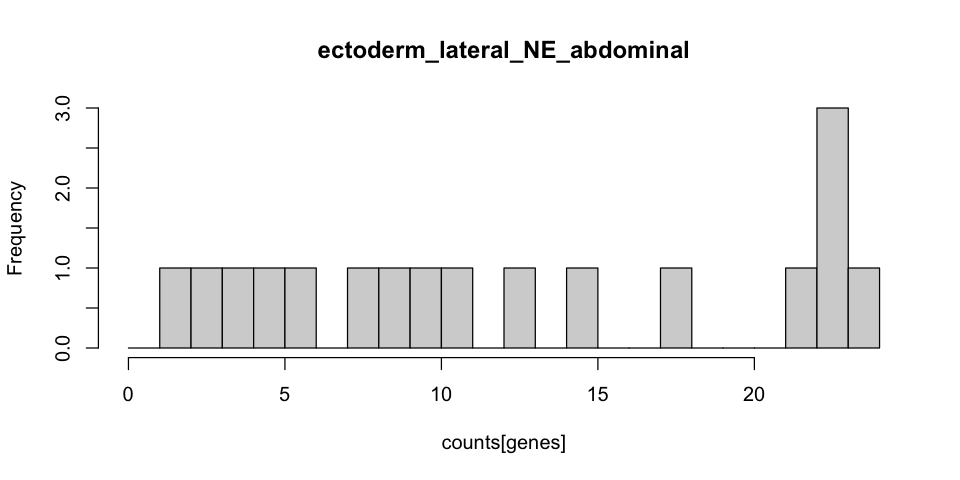

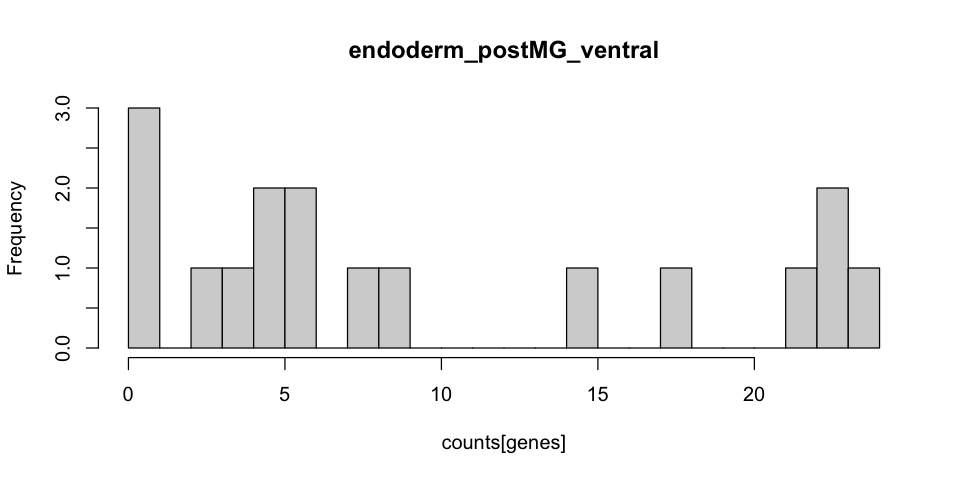

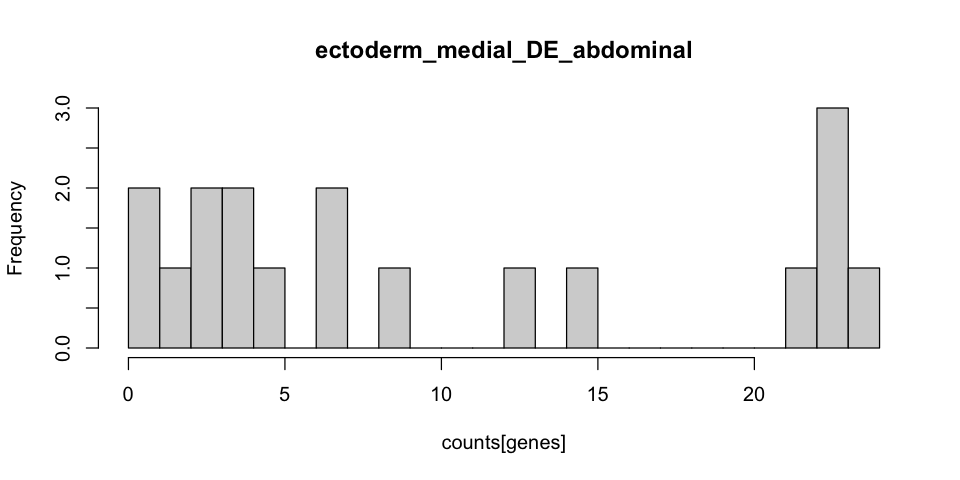

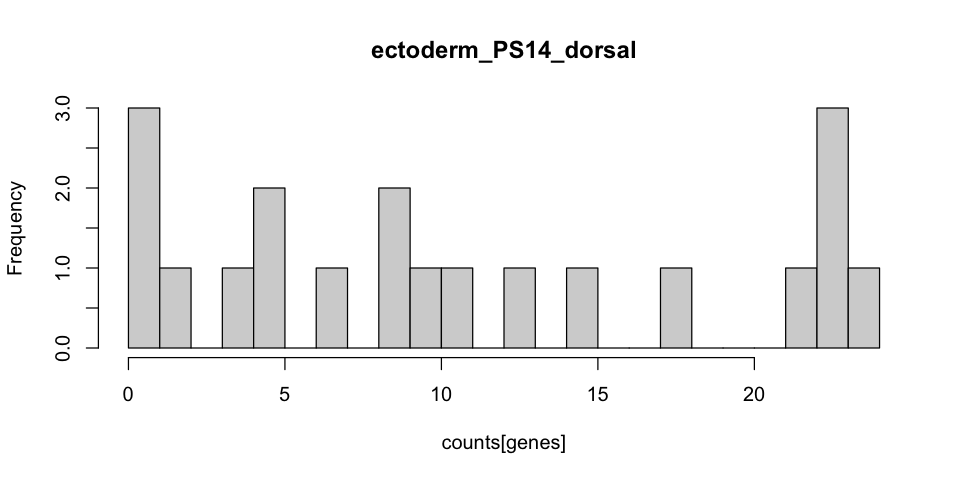

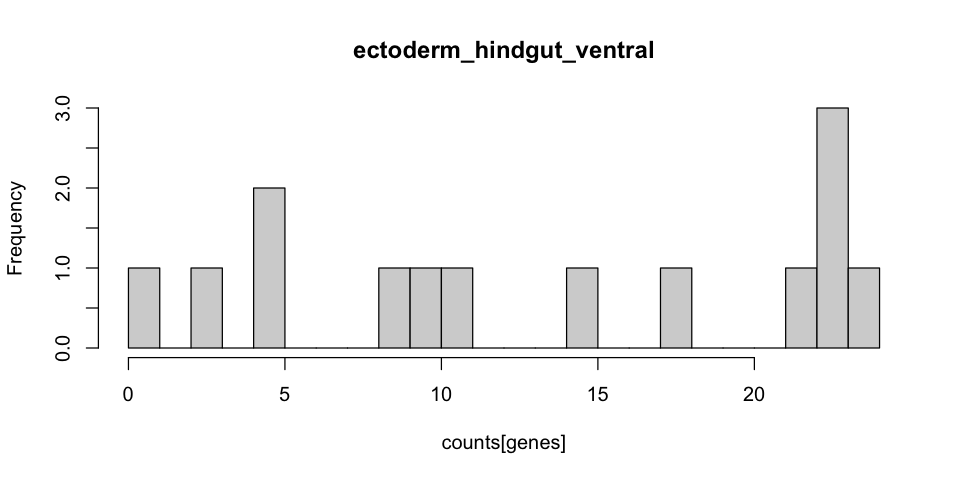

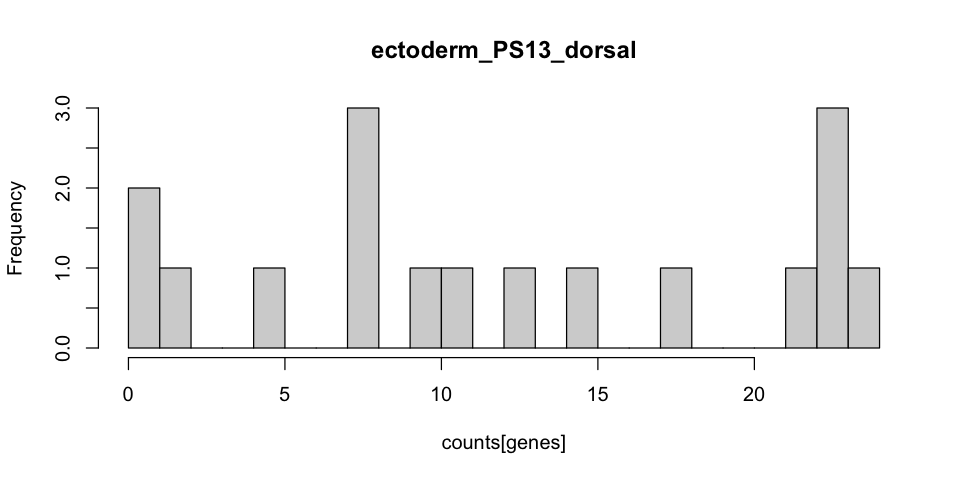

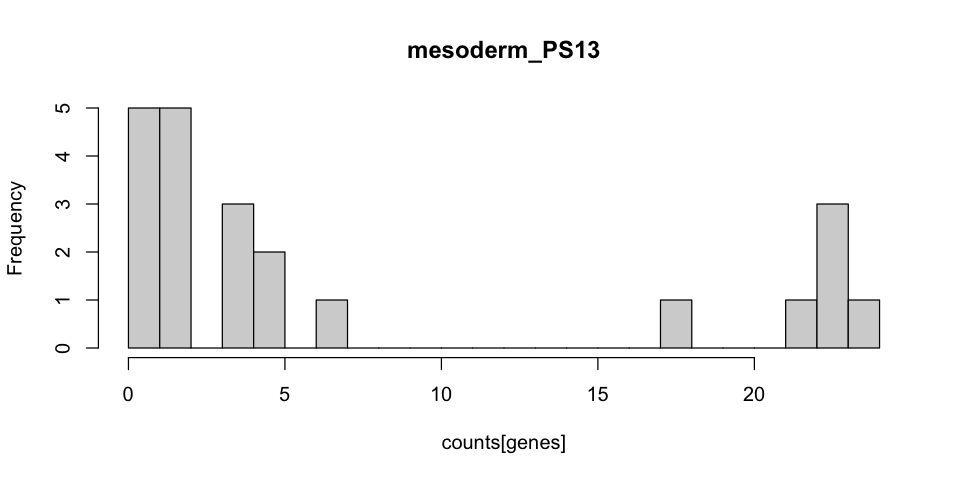

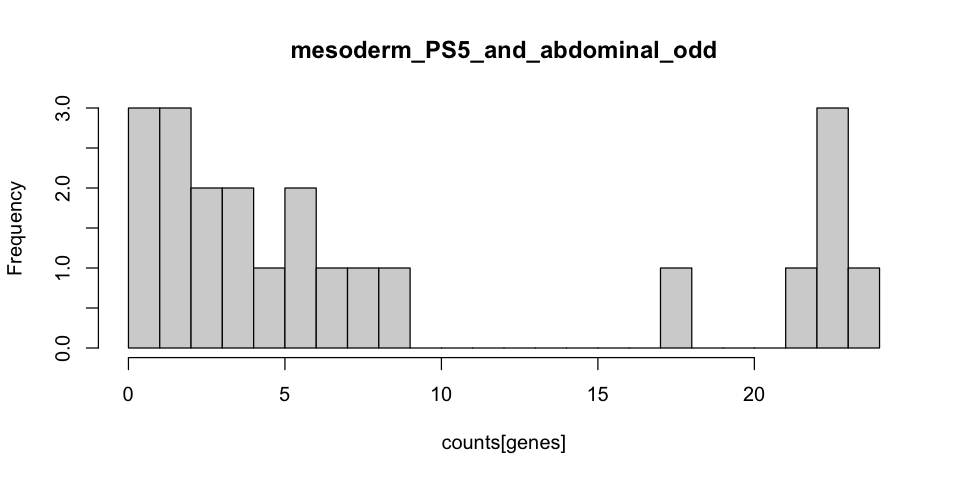

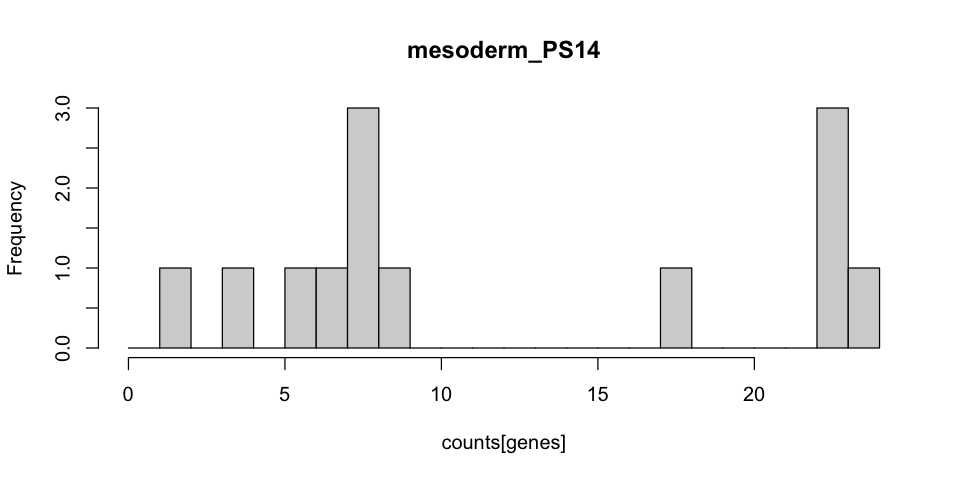

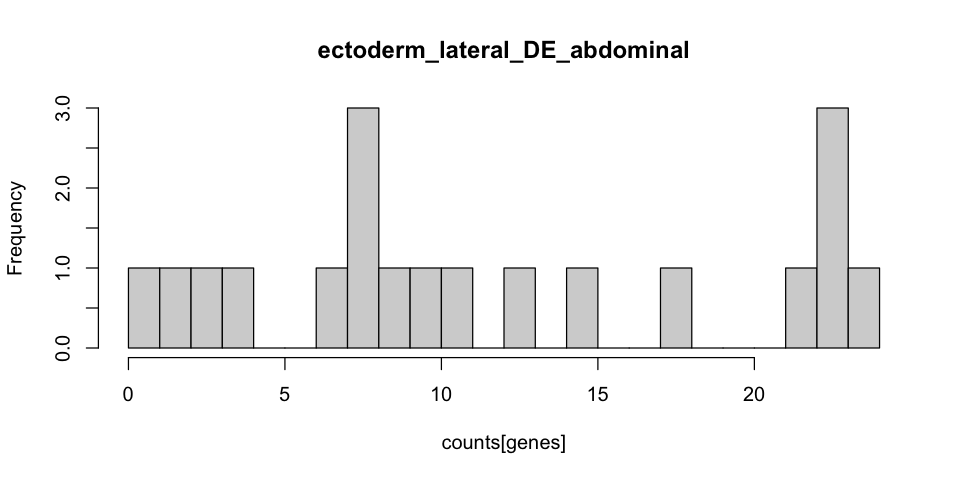

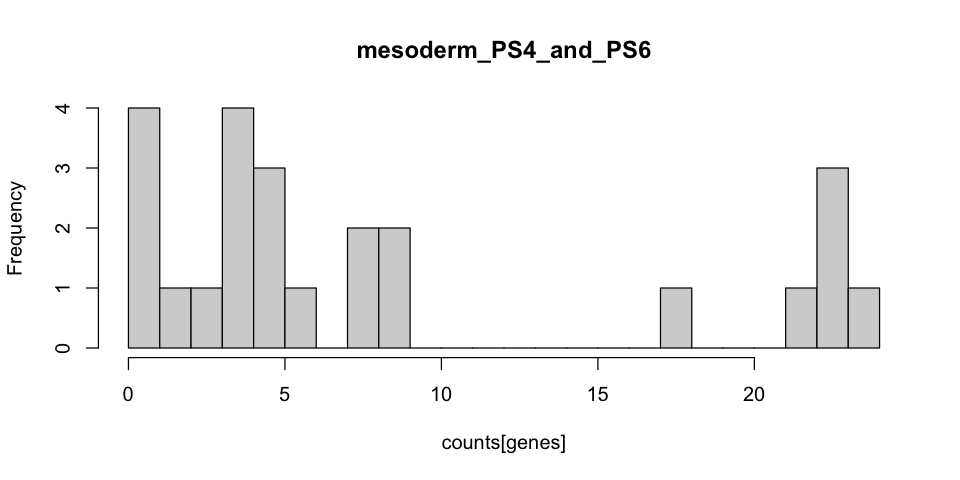

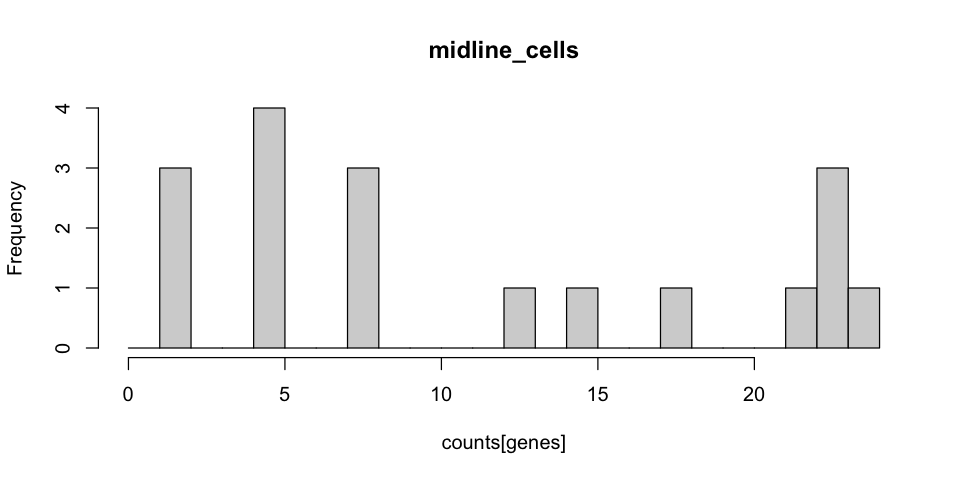

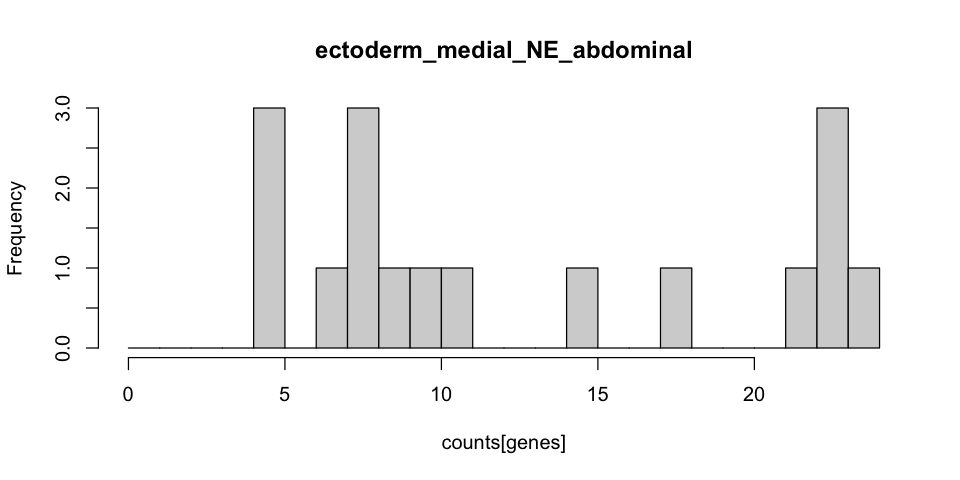

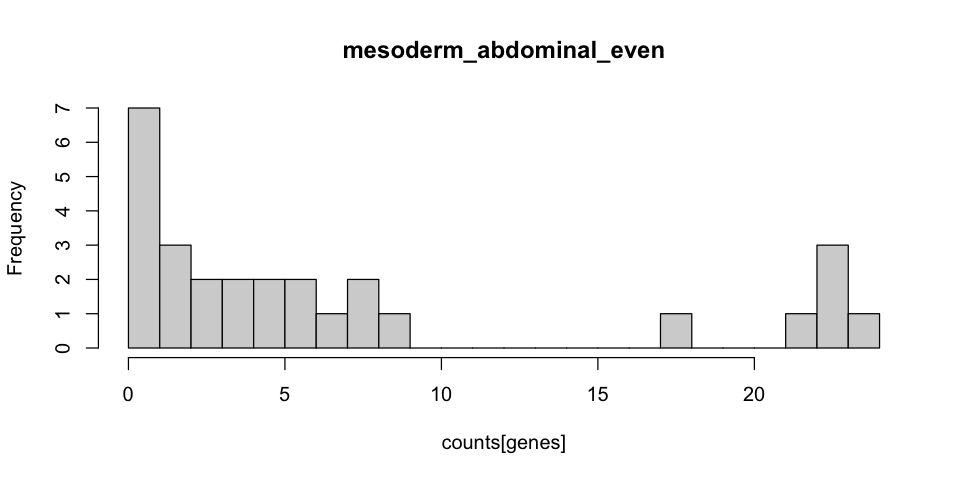

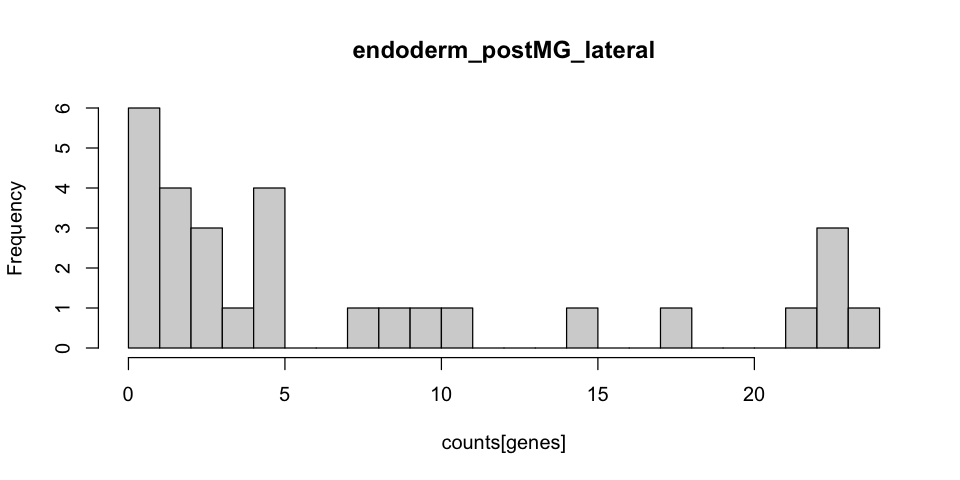

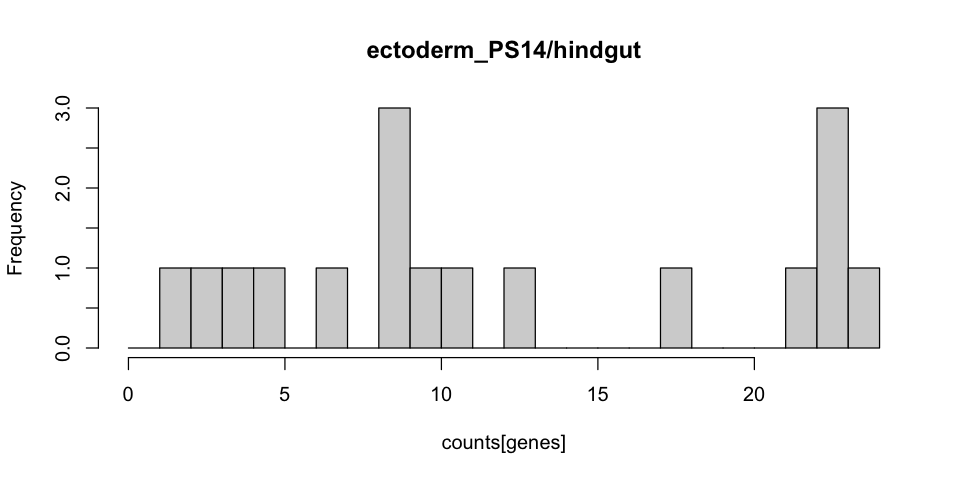

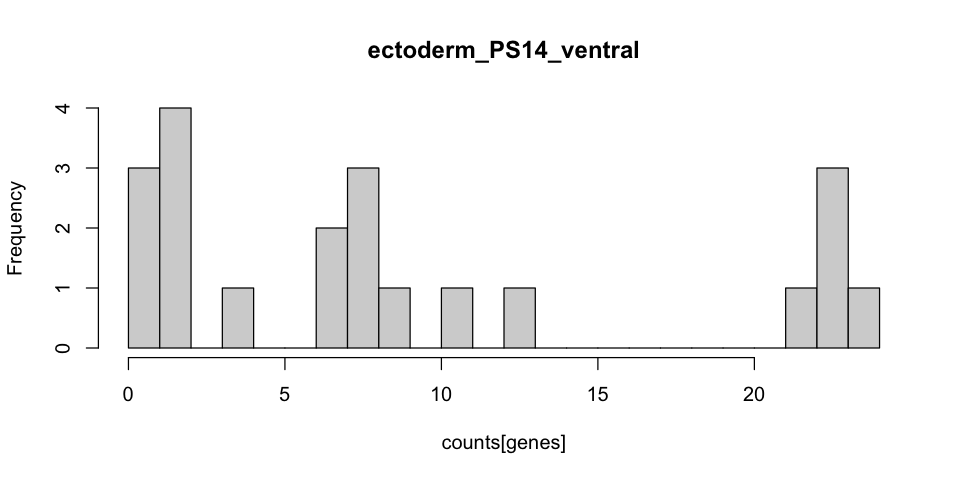

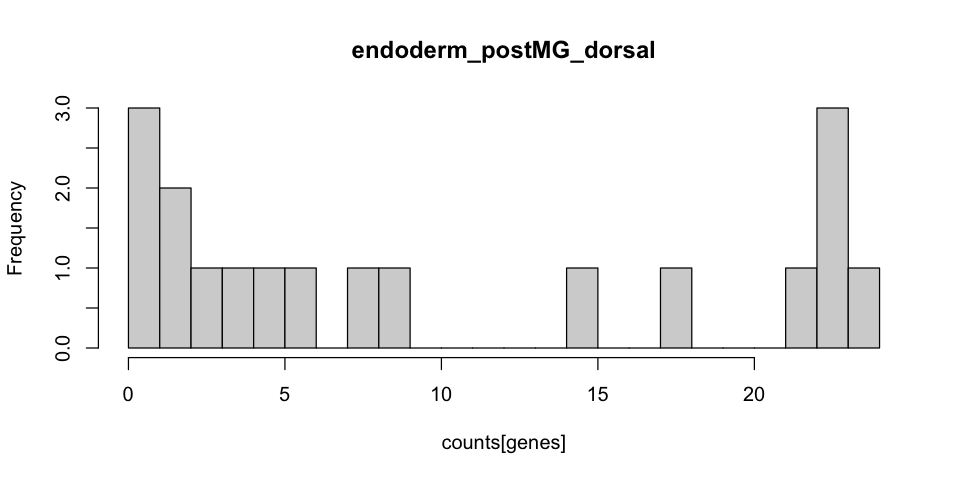

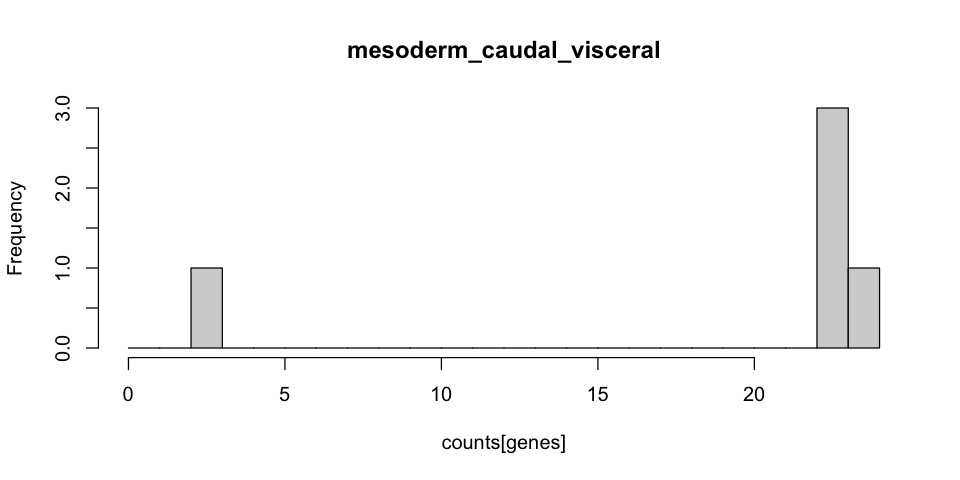

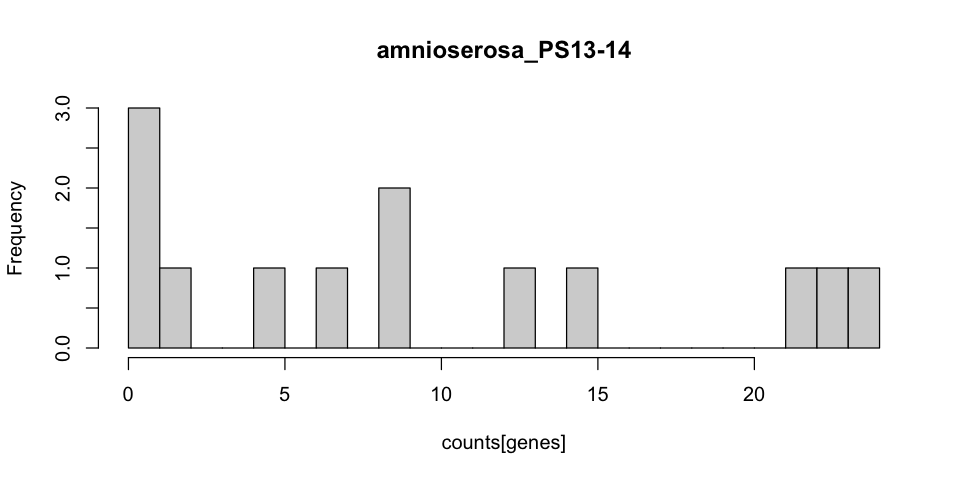

In [40]:
lapply(degs.neg, FUN = function(genes){
    return(median(counts[genes]))
})

for (c in names(degs.neg)){
    genes <- degs.neg[[c]]
    options(repr.plot.width=8, repr.plot.height=4)
    hist(counts[genes], main = c, breaks = seq(0,24,1))
}

cluster                            count n_sharing_clusters
1 ectoderm_hindgut_dorsal            2     1 <= n <= 5       
2 ectoderm_intermediate_NE_abdominal 3     1 <= n <= 5       
3 amnioserosa_trunk                  12    1 <= n <= 5       
4 ectoderm_intermediate_DE_abdominal 6     1 <= n <= 5       
5 ectoderm_lateral_NE_abdominal      4     1 <= n <= 5       
6 endoderm_postMG_ventral            7     1 <= n <= 5

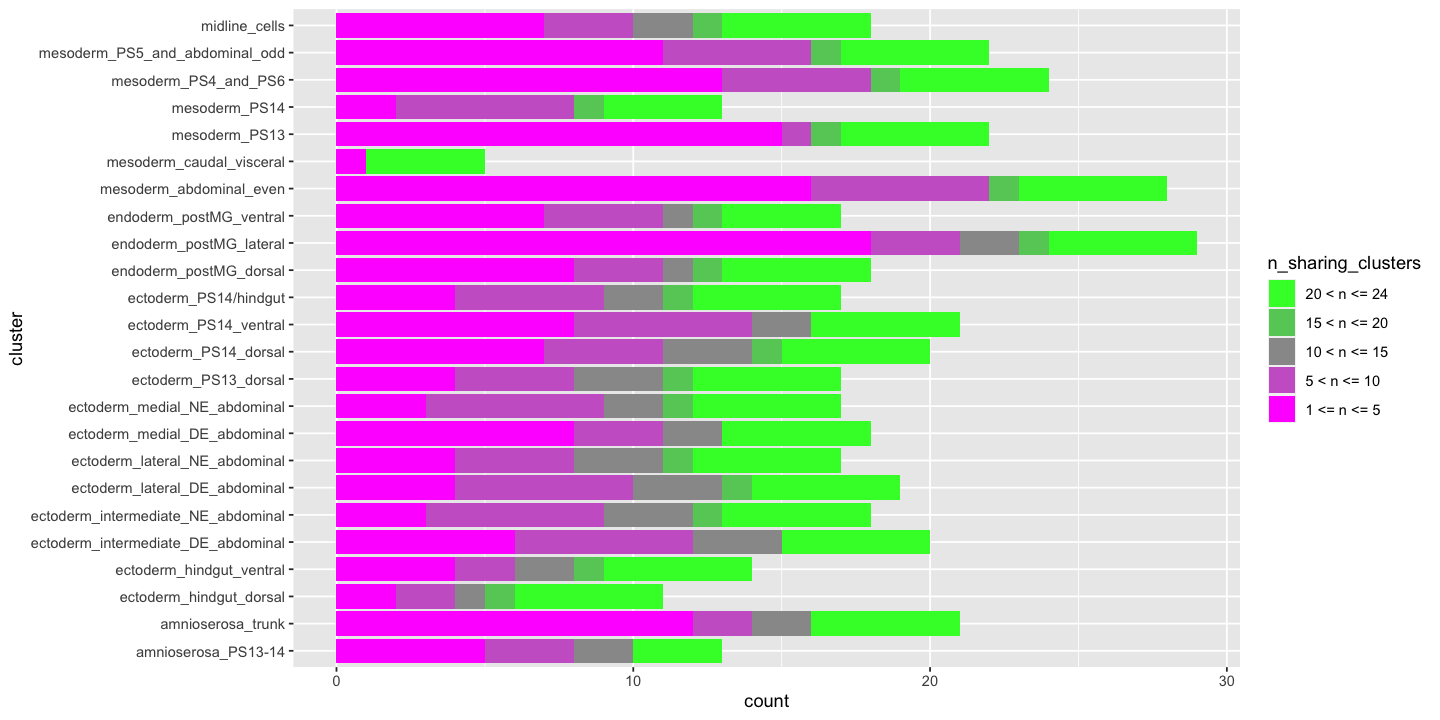

In [41]:
df.1to5 <- data.frame(cluster = names(degs.neg))
df.1to5$count <- lapply(degs.neg, FUN = function(genes){
    n <- sum(counts[genes] > 0) - sum(counts[genes] > 5)
    return(n)
})
df.1to5$n_sharing_clusters <- '1 <= n <= 5'

df.6to10 <- data.frame(cluster = names(degs.neg))
df.6to10$count <- lapply(degs.neg, FUN = function(genes){
    n <- sum(counts[genes] > 5) - sum(counts[genes] > 10)
    return(n)
})
df.6to10$n_sharing_clusters <- '5 < n <= 10'


df.11to15 <- data.frame(cluster = names(degs.neg))
df.11to15$count <- lapply(degs.neg, FUN = function(genes){
    n <- sum(counts[genes] > 10) - sum(counts[genes] > 15)
    return(n)
})
df.11to15$n_sharing_clusters <- '10 < n <= 15'

df.16to20 <- data.frame(cluster = names(degs.neg))
df.16to20$count <- lapply(degs.neg, FUN = function(genes){
    n <- sum(counts[genes] > 15) - sum(counts[genes] > 20)
    return(n)
})
df.16to20$n_sharing_clusters <- '15 < n <= 20'

df.21to24 <- data.frame(cluster = names(degs.neg))
df.21to24$count <- lapply(degs.neg, FUN = function(genes){
    n <- sum(counts[genes] > 20)
    return(n)
})
df.21to24$n_sharing_clusters <- '20 < n <= 24'

df <- rbind(df.1to5,df.6to10,df.11to15,df.16to20,df.21to24)

df <- transform(df, n_sharing_clusters = factor(n_sharing_clusters, 
                                                levels = c('20 < n <= 24','15 < n <= 20','10 < n <= 15',
                                                           '5 < n <= 10','1 <= n <= 5')))
head(df)

options(repr.plot.width=12, repr.plot.height=6)
g <- ggplot(df, aes(x = cluster, y = count, fill = n_sharing_clusters))
g <- g + geom_bar(stat = "identity")
g <- g + scale_fill_manual(values = c("#33FF33", "#66CC66", "#999999", "#CC66CC", "#FF33FF"))
g <- g + coord_flip()
plot(g)
ggsave(g, file = "./figures/2_bcdRNAi_DEGs/negative_markers_n_sharing.eps", dpi = 300, width = 12, height = 6)

In [42]:
n_over13 <- lapply(degs.neg, FUN = function(genes){
    n <- sum(counts[genes]>13)
    n <- n/length(genes)
    return(n)
})
n_over13

$ectoderm_hindgut_dorsal
[1] 0.5454545

$ectoderm_intermediate_NE_abdominal
[1] 0.3888889

$amnioserosa_trunk
[1] 0.2857143

$ectoderm_intermediate_DE_abdominal
[1] 0.3

$ectoderm_lateral_NE_abdominal
[1] 0.4117647

$endoderm_postMG_ventral
[1] 0.3529412

$ectoderm_medial_DE_abdominal
[1] 0.3333333

$ectoderm_PS14_dorsal
[1] 0.35

$ectoderm_hindgut_ventral
[1] 0.5

$ectoderm_PS13_dorsal
[1] 0.4117647

$mesoderm_PS13
[1] 0.2727273

$mesoderm_PS5_and_abdominal_odd
[1] 0.2727273

$mesoderm_PS14
[1] 0.3846154

$ectoderm_lateral_DE_abdominal
[1] 0.3684211

$mesoderm_PS4_and_PS6
[1] 0.25

$midline_cells
[1] 0.3888889

$ectoderm_medial_NE_abdominal
[1] 0.4117647

$mesoderm_abdominal_even
[1] 0.2142857

$endoderm_postMG_lateral
[1] 0.2413793

$`ectoderm_PS14/hindgut`
[1] 0.3529412

$ectoderm_PS14_ventral
[1] 0.2380952

$endoderm_postMG_dorsal
[1] 0.3888889

$mesoderm_caudal_visceral
[1] 0.8

$`amnioserosa_PS13-14`
[1] 0.3076923

In [43]:
min(unlist(n_over13))
max(unlist(n_over13))

[1] 0.2142857

[1] 0.8

cluster                            count n_sharing_clusters
1 ectoderm_hindgut_dorsal            4     1 <= n <= 13      
2 ectoderm_intermediate_NE_abdominal 9     1 <= n <= 13      
3 amnioserosa_trunk                  14    1 <= n <= 13      
4 ectoderm_intermediate_DE_abdominal 12    1 <= n <= 13      
5 ectoderm_lateral_NE_abdominal      8     1 <= n <= 13      
6 endoderm_postMG_ventral            11    1 <= n <= 13

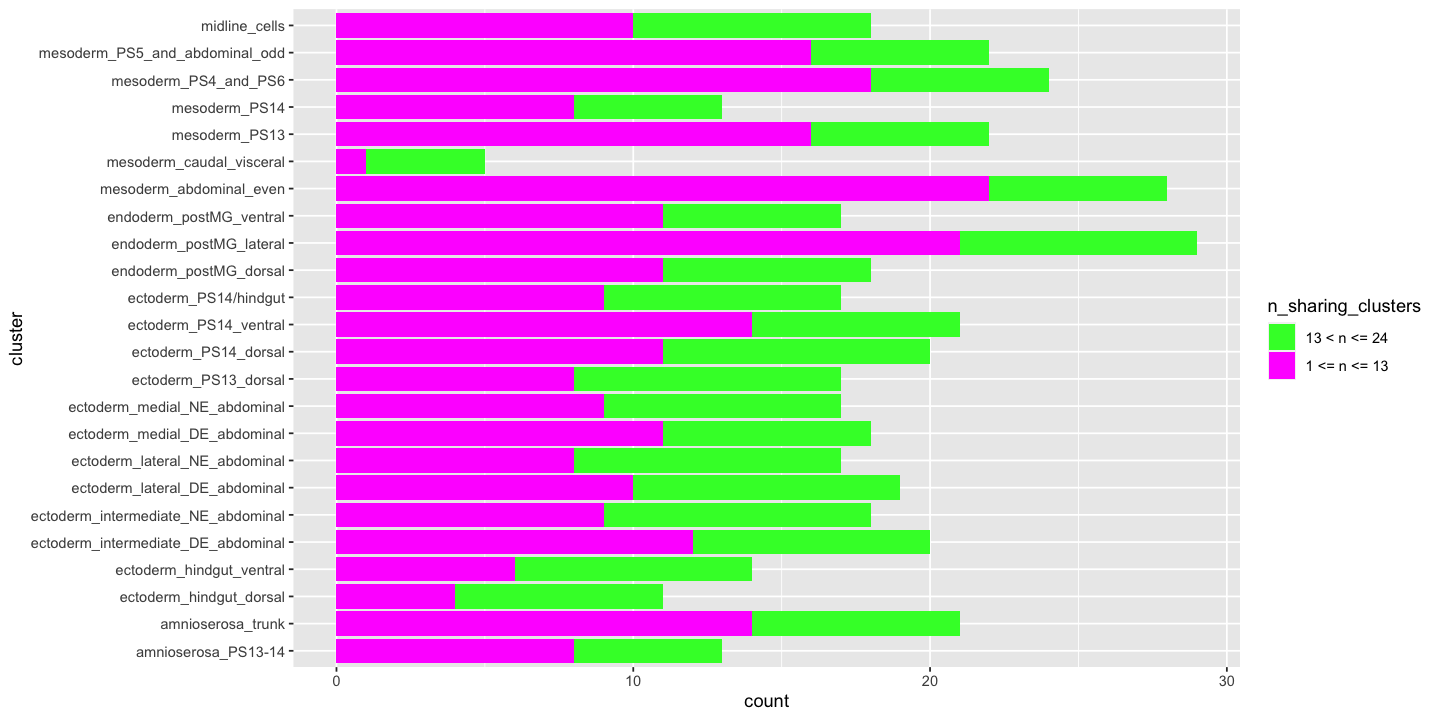

In [44]:
df.1to10 <- data.frame(cluster = names(degs.neg))
df.1to10$count <- lapply(degs.neg, FUN = function(genes){
    n <- sum(counts[genes] <= 10)
    return(n)
})
df.1to10$n_sharing_clusters <- '1 <= n <= 13'


df.11to20 <- data.frame(cluster = names(degs.neg))
df.11to20$count <- lapply(degs.neg, FUN = function(genes){
    n <- sum(counts[genes] > 10)
    return(n)
})
df.11to20$n_sharing_clusters <- '13 < n <= 24'

df <- rbind(df.1to10,df.11to20)

df <- transform(df, n_sharing_clusters = factor(n_sharing_clusters, 
                                                levels = c('13 < n <= 24','1 <= n <= 13')))
head(df)

options(repr.plot.width=12, repr.plot.height=6)
g <- ggplot(df, aes(x = cluster, y = count, fill = n_sharing_clusters))
g <- g + geom_bar(stat = "identity")
g <- g + scale_fill_manual(values = c("#33FF33", "#FF33FF"))
g <- g + coord_flip()
plot(g)
ggsave(g, file = "./figures/2_bcdRNAi_DEGs/negative_markers_n_sharing_threshold13.eps", dpi = 300, width = 12, height = 6)

21 to 80% of negative DEGs between bcd-RNAi and control in each cluster were shared by more than 13 clusters (The number of posterior clusters)

In [45]:
seu.obj.list <- SplitObject(seu.wo.head, split.by = 'genotype')
seu.obj.list <- lapply(seu.obj.list, FUN = function(seu){
    Idents(seu) <- 'manual_ID_2'
    return(seu)
})
# genes <- names(counts[(counts < 21)&(counts > 1)])
# genes <- names(counts[(counts < 21)])
genes <- names(counts)
length(genes)
avg.5to15.bcd.neg <- AverageExpression(seu.obj.list[['bcd_RNAi']], features = genes)
avg.5to15.bcd.neg <- log(avg.5to15.bcd.neg$SCT)
dim(avg.5to15.bcd.neg)
avg.5to15.set2.neg <- AverageExpression(seu.obj.list[['set_2']], features = genes)
avg.5to15.set2.neg <- log(avg.5to15.set2.neg$SCT)
dim(avg.5to15.set2.neg)

[1] 113

Finished averaging RNA for cluster amnioserosa_trunk

Finished averaging RNA for cluster ectoderm_lateral_NE_abdominal

Finished averaging RNA for cluster endoderm_postMG_lateral

Finished averaging RNA for cluster ectoderm_medial_DE_abdominal

Finished averaging RNA for cluster amnioserosa_PS13-14

Finished averaging RNA for cluster mesoderm_abdominal_even

Finished averaging RNA for cluster ectoderm_lateral_DE_abdominal

Finished averaging RNA for cluster mesoderm_PS4_and_PS6

Finished averaging RNA for cluster ectoderm_PS14_ventral

Finished averaging RNA for cluster ectoderm_PS14/hindgut

Finished averaging RNA for cluster ectoderm_intermediate_NE_abdominal

Finished averaging RNA for cluster ectoderm_PS13_dorsal

Finished averaging RNA for cluster ectoderm_hindgut_ventral

Finished averaging RNA for cluster ectoderm_PS14_dorsal

Finished averaging RNA for cluster ectoderm_medial_NE_abdominal

Finished averaging RNA for cluster ectoderm_intermediate_DE_abdominal

Finished averaging

[1] 113  24

Finished averaging RNA for cluster ectoderm_hindgut_dorsal

Finished averaging RNA for cluster ectoderm_intermediate_NE_abdominal

Finished averaging RNA for cluster amnioserosa_trunk

Finished averaging RNA for cluster ectoderm_intermediate_DE_abdominal

Finished averaging RNA for cluster ectoderm_lateral_NE_abdominal

Finished averaging RNA for cluster endoderm_postMG_ventral

Finished averaging RNA for cluster ectoderm_medial_DE_abdominal

Finished averaging RNA for cluster ectoderm_PS14_dorsal

Finished averaging RNA for cluster ectoderm_hindgut_ventral

Finished averaging RNA for cluster ectoderm_PS13_dorsal

Finished averaging RNA for cluster mesoderm_PS13

Finished averaging RNA for cluster mesoderm_PS5_and_abdominal_odd

Finished averaging RNA for cluster mesoderm_PS14

Finished averaging RNA for cluster ectoderm_lateral_DE_abdominal

Finished averaging RNA for cluster mesoderm_PS4_and_PS6

Finished averaging RNA for cluster midline_cells

Finished averaging RNA for cluster ect

[1] 113  24

In [46]:
avg.logFC.neg.raw <- avg.5to15.bcd.neg - avg.5to15.set2.neg
head(avg.logFC.neg.raw)
avg.logFC.neg <- melt(as.matrix(avg.logFC.neg.raw))
colnames(avg.logFC.neg) <- c("Gene", "Cluster", "val1")
avg.logFC.neg$Value <- apply(avg.logFC.neg, 1, FUN = function(x){
    return(degs_list[[x[2]]][x[1],'avg_logFC'])
} )
avg.logFC.neg[is.na(avg.logFC.neg)] <-  0

avg.logFC.neg$FC0.5 <- as.double(avg.logFC.neg$Value < -0.5)
avg.logFC.neg$Significant <- apply(avg.logFC.neg, 1, FUN = function(x){
    return(as.double(x[1] %in% row.names(degs_list[[x[2]]])))
} )

avg.logFC.neg$negDEG <- avg.logFC.neg$FC0.5 * avg.logFC.neg$Significant

head(avg.logFC.neg)

amnioserosa_trunk ectoderm_lateral_NE_abdominal endoderm_postMG_lateral
abd-A    3.4392693        -0.04352176                   -3.7225895             
Act87E  -0.4759917        -0.74909195                   -0.9518543             
Akap200 -0.7922529        -0.83649397                   -0.9362903             
Arc1    -1.4865668        -1.26388268                   -1.4353598             
Arf79F  -0.3368324        -0.27046312                   -0.3344189             
be      -0.9958671        -1.47172956                    1.1906099             
        ectoderm_medial_DE_abdominal amnioserosa_PS13-14
abd-A   -0.7278691                   -2.0289942         
Act87E  -0.7681824                   -0.5396983         
Akap200 -0.7531696                   -0.8455323         
Arc1    -1.1066368                   -1.4264745         
Arf79F  -0.3136397                   -0.3802678         
be      -2.0617673                   -1.6474016         
        mesoderm_abdominal_even ectoderm_lateral_DE_abdominal
abd-A    3.5434272              -0.06130611                  
Act87E   3.1297498              -0.35112767                  
Akap200 -0.7910796              -0.89623563                  
Arc1    -1.0877568              -1.66726419                  
Arf79F  -0.2696285              -0.33865162                  
be      -0.6291731              -0.77132848                  
        mesoderm_PS4_and_PS6 ectoderm_PS14_ventral ectoderm_PS14/hindgut ⋯
abd-A    0.8120407            1.4814507            -2.7493483            ⋯
Act87E   3.0926888           -0.7723442            -0.3396185            ⋯
Akap200 -1.1755220           -0.6229347            -0.9266074            ⋯
Arc1    -1.6063371           -1.2280050            -1.4341822            ⋯
Arf79F  -0.4914832           -0.3085468            -0.6136599            ⋯
be       2.6523453           -1.4452887            -0.6879252            ⋯
        ectoderm_medial_NE_abdominal ectoderm_intermediate_DE_abdominal
abd-A    3.5069725                    0.5363047                        
Act87E  -4.4359053                   -1.3148354                        
Akap200 -0.7459376                   -0.8317865                        
Arc1    -1.1407061                   -1.6823256                        
Arf79F  -0.5092031                   -0.3891752                        
be      -4.3813808                   -4.1946925                        
        mesoderm_PS14 mesoderm_caudal_visceral mesoderm_PS13
abd-A   -2.6807493    -2.6647488                1.9838372   
Act87E   0.9598398    -4.7478034                2.2848232   
Akap200 -1.1176181    -0.9147989               -1.0284966   
Arc1    -1.4461396    -1.3805331               -1.2430068   
Arf79F  -0.5052335    -0.5346702               -0.5117762   
be       2.4814457    -0.7457455                0.7556539   
        ectoderm_hindgut_dorsal endoderm_postMG_ventral
abd-A    0.7129498              -0.54812141            
Act87E  -0.8109302              -0.01749316            
Akap200 -0.9187939              -0.80321849            
Arc1    -1.0262916              -1.24882394            
Arf79F  -0.3763954              -0.41157126            
be      -1.7272209               2.21294283            
        mesoderm_PS5_and_abdominal_odd midline_cells endoderm_postMG_dorsal
abd-A    1.7499860                      1.8883863    -1.9348603            
Act87E   2.8001134                     -0.9176504    -0.3566749            
Akap200 -0.6578917                     -0.7263601    -1.0240366            
Arc1    -0.8070342                     -0.7523703    -0.9687543            
Arf79F  -0.1646799                     -0.3261828    -0.6683404            
be       0.7736216                     -0.8285707     0.4906229

Gene    Cluster           val1       Value      FC0.5 Significant negDEG
1 abd-A   amnioserosa_trunk  3.4392693  0.0000000 0     0           0     
2 Act87E  amnioserosa_trunk -0.4759917  0.0000000 0     0           0     
3 Akap200 amnioserosa_trunk -0.7922529 -0.6762144 1     1           1     
4 Arc1    amnioserosa_trunk -1.4865668 -0.6992863 1     1           1     
5 Arf79F  amnioserosa_trunk -0.3368324  0.0000000 0     0           0     
6 be      amnioserosa_trunk -0.9958671  0.2649893 0     0           0

In [47]:
levels <- c(trunk.levels,post.levels)
avg.logFC.neg <- transform(avg.logFC.neg, 
                           Cluster = factor(Cluster, levels = levels))
gene.levels <- genes[order(counts[genes])]
length(gene.levels)
avg.logFC.neg <- transform(avg.logFC.neg, 
                            Gene = factor(Gene, levels = gene.levels))

[1] 113

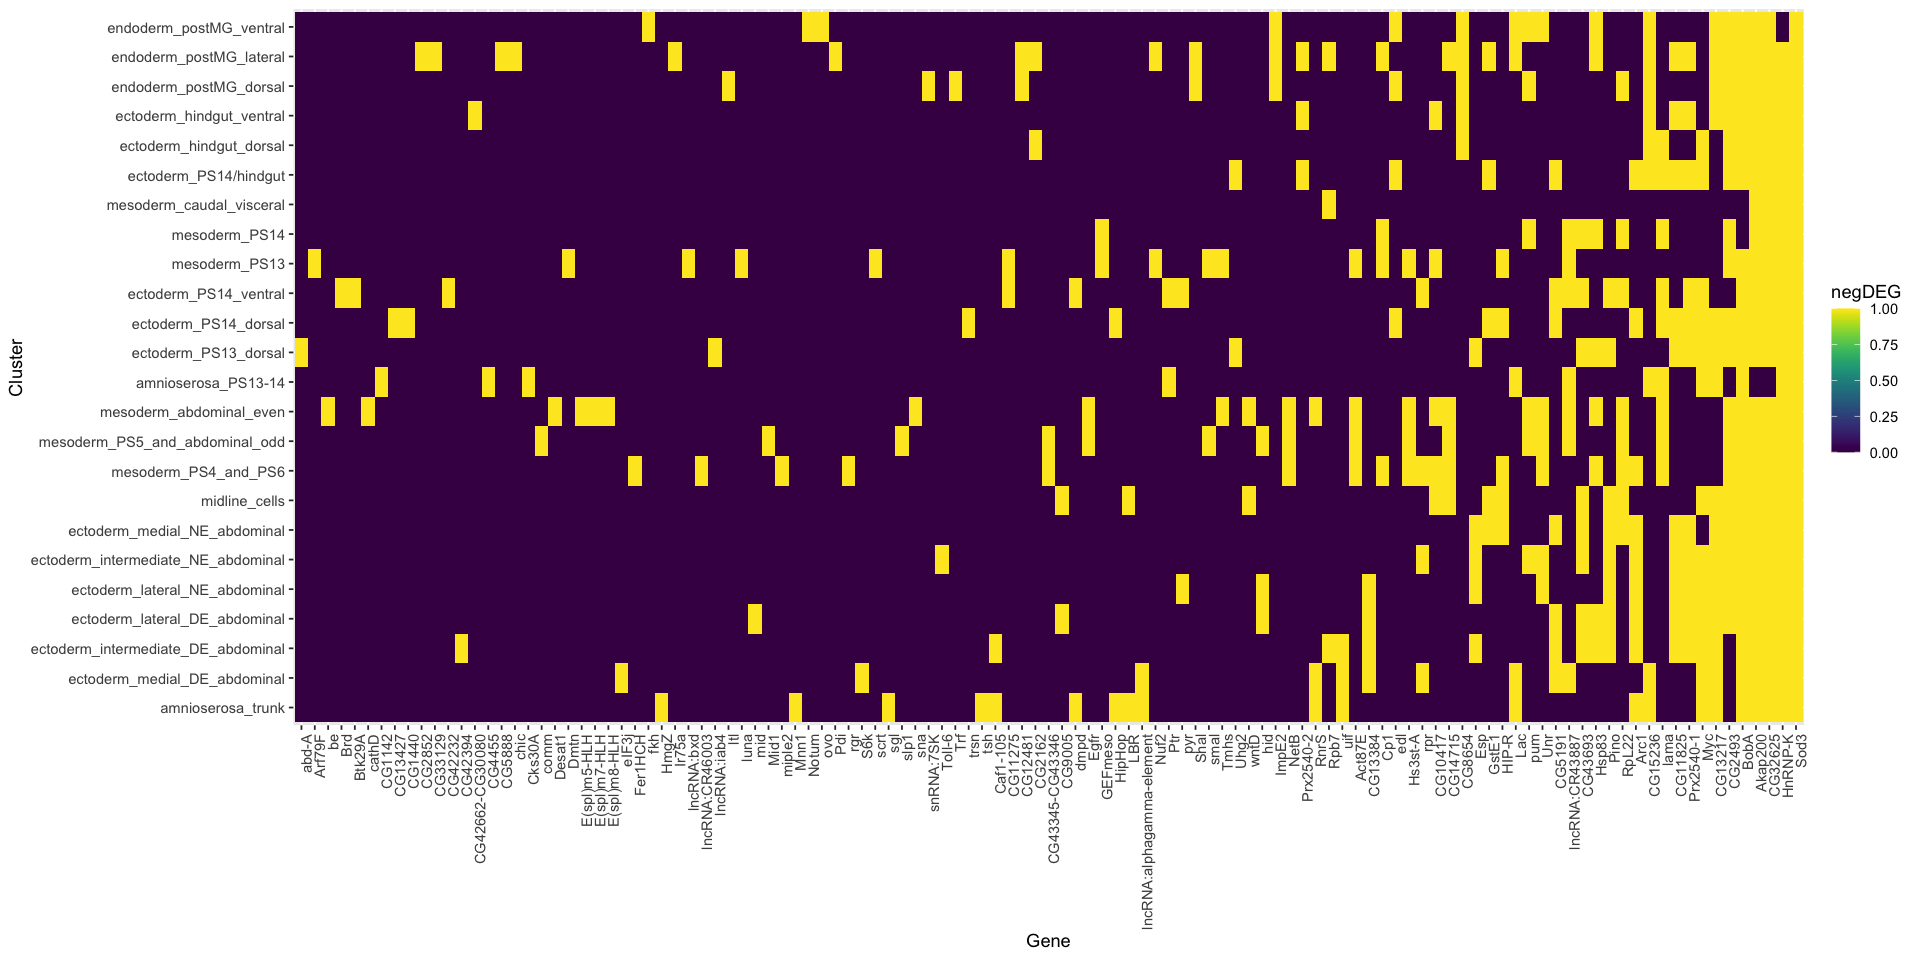

In [48]:
options(repr.plot.width=16, repr.plot.height=8)
g <- ggplot(avg.logFC.neg, aes(x = Gene, y = Cluster, fill = negDEG))
g <- g + geom_tile() + scale_fill_viridis(limits = c(0, 1))
g <- g + theme(axis.text.x = element_text(angle = 90, hjust = 1))
g

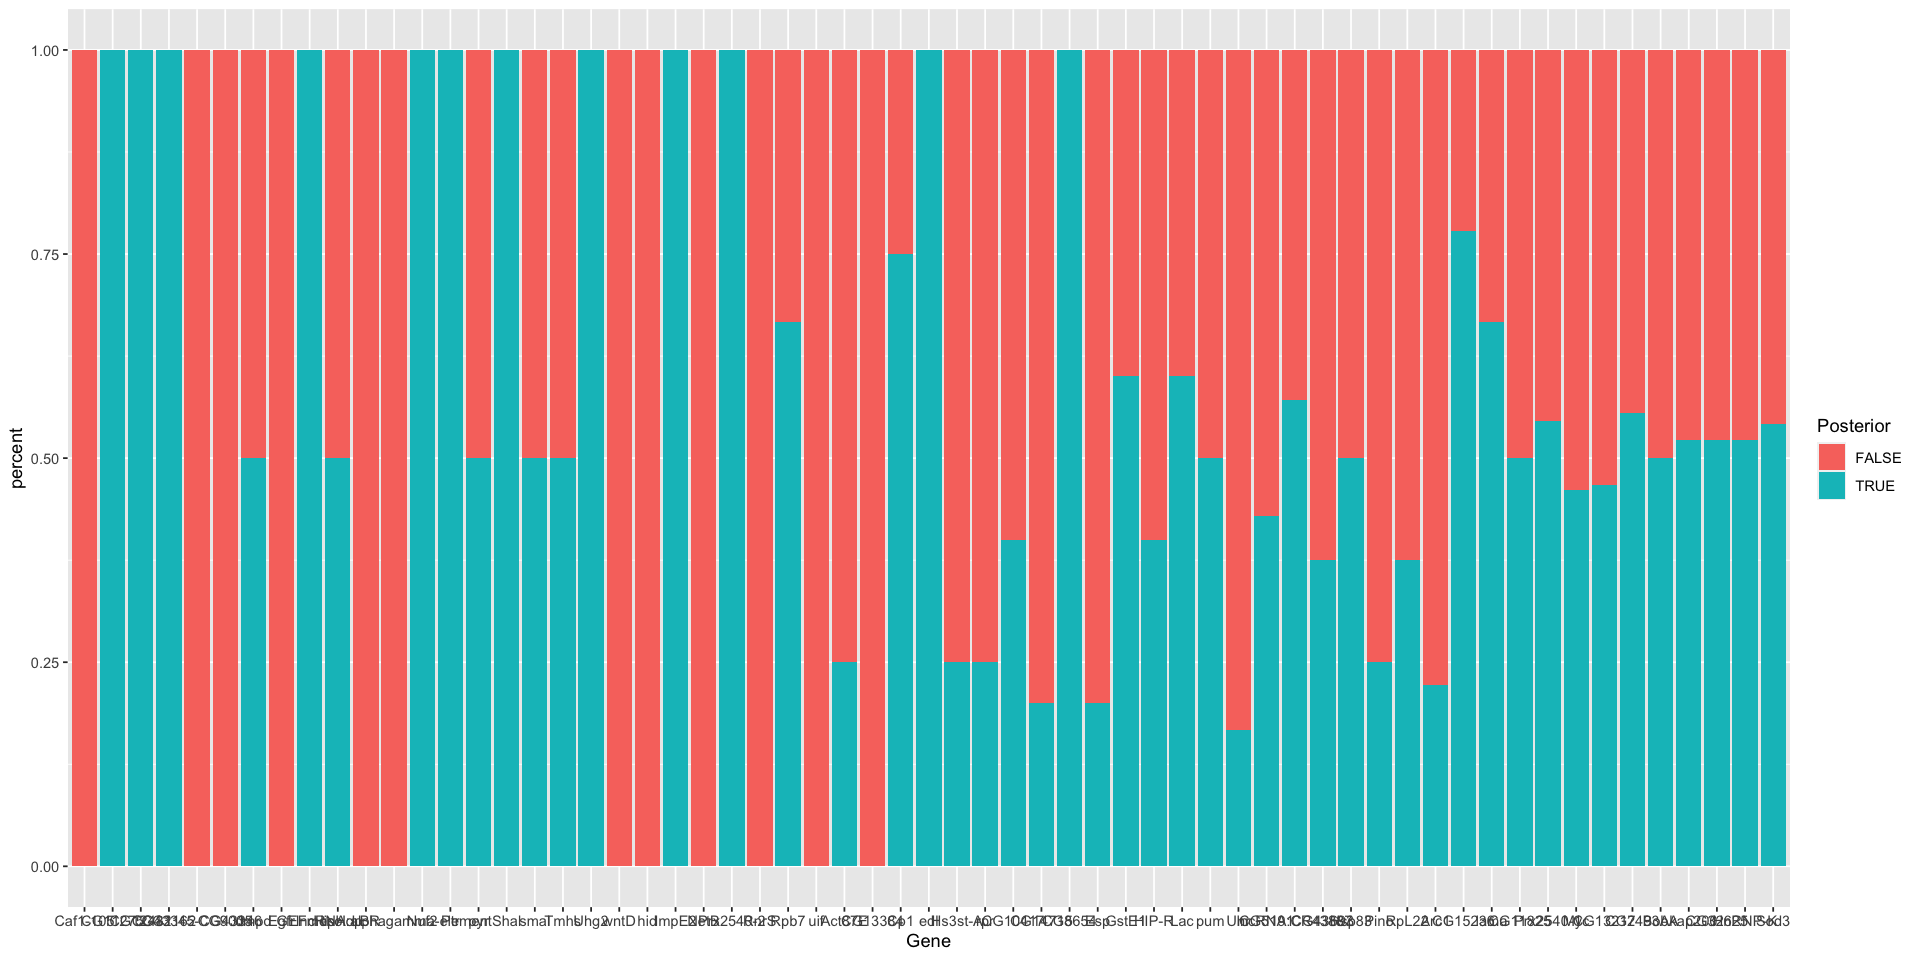

In [49]:
avg.logFC.neg <- transform(avg.logFC.neg, 
                           Cluster = factor(Cluster, levels = levels))
avg.logFC.neg$Posterior <- avg.logFC.neg$Cluster %in% post.levels
d <- as.matrix(table(avg.logFC.neg[avg.logFC.neg$negDEG==1, c('Gene','Posterior')]))
tot <- apply(d,1,sum)
d <- as.data.frame(d)
d$total <- tot
d <- d[d$total > 1,]
d$percent <- d$Freq/d$total
# d
# d <- melt(d[c('Gene','percent','Poseterior')])
options(repr.plot.width=16, repr.plot.height=8)
g <- ggplot(d, aes(x = Gene, y = percent, fill = Posterior))
g <- g + geom_bar(stat = "identity")
g

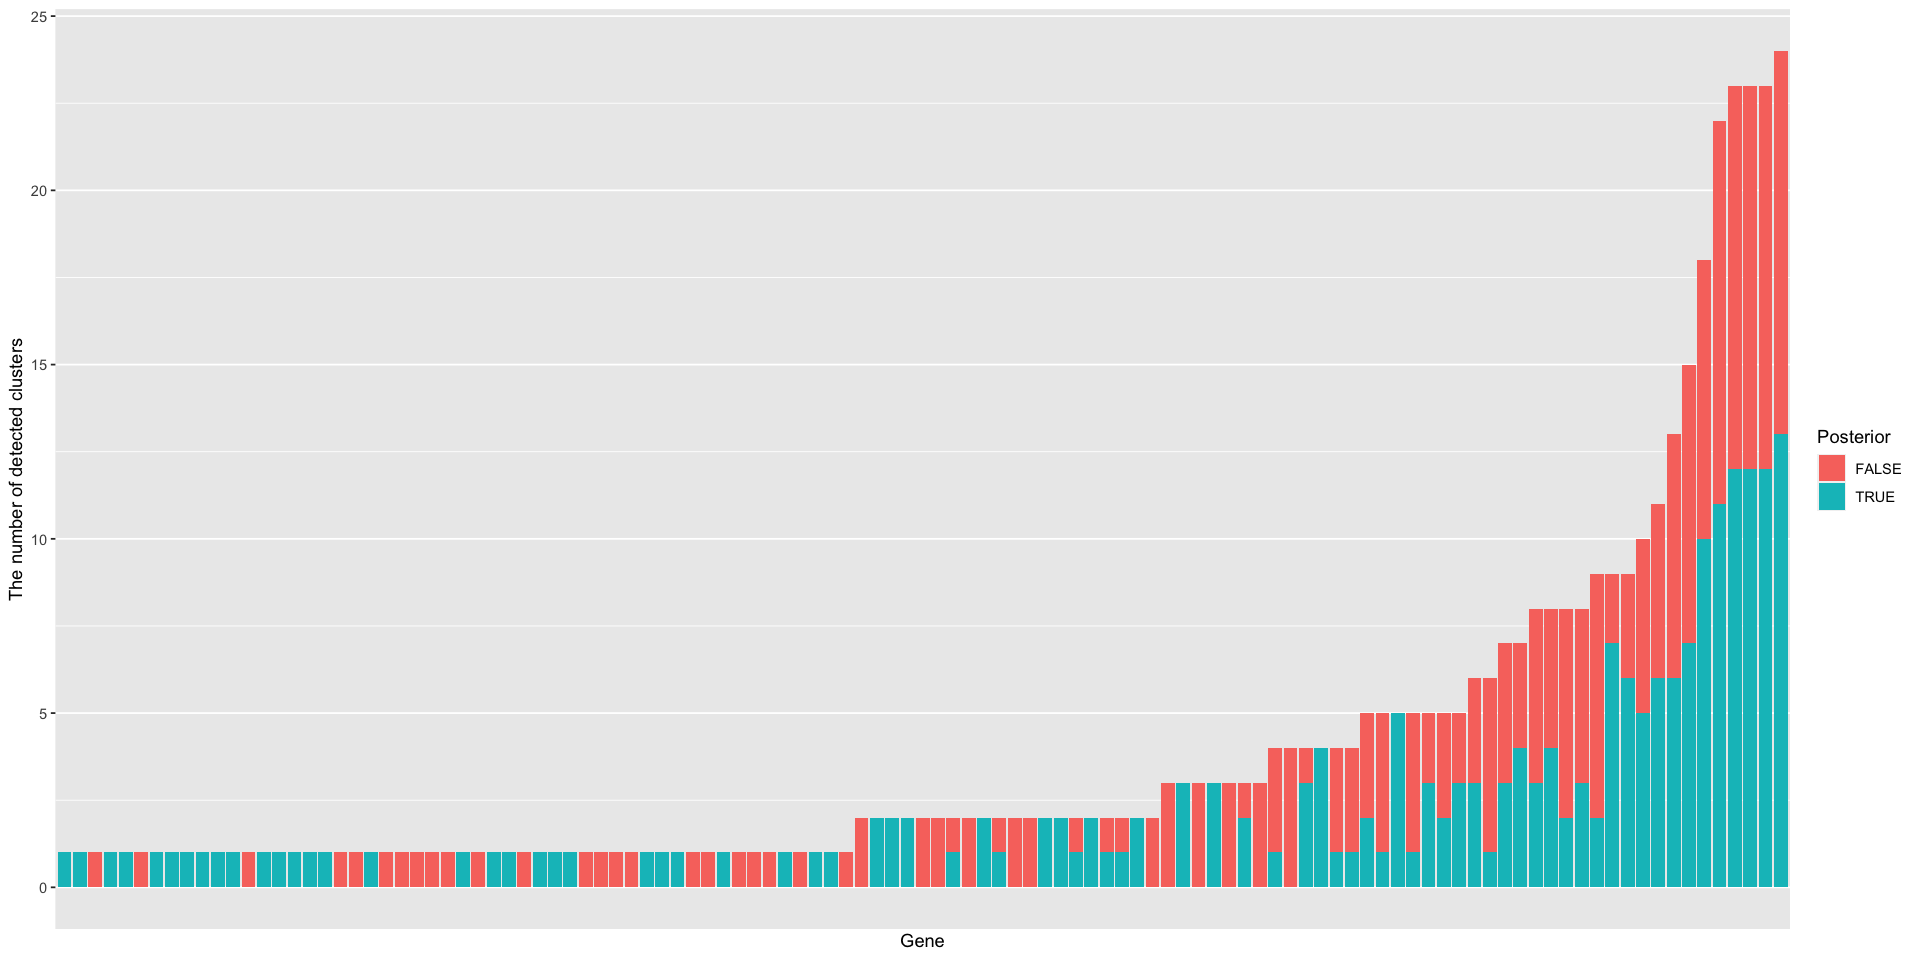

In [50]:
avg.logFC.neg <- transform(avg.logFC.neg, 
                           Cluster = factor(Cluster, levels = levels))
avg.logFC.neg$Posterior <- avg.logFC.neg$Cluster %in% post.levels
d <- as.matrix(table(avg.logFC.neg[avg.logFC.neg$negDEG==1, c('Gene','Posterior')]))
tot <- apply(d,1,sum)
d <- as.data.frame(d)
d$total <- tot
d$percent <- d$Freq/d$total


options(repr.plot.width=16, repr.plot.height=8)
g <- ggplot(d, aes(x = Gene, y = Freq, fill = Posterior))
g <- g + geom_bar(stat = "identity")
g <- g + scale_x_discrete(breaks = NULL)
g <- g + ylab('The number of detected clusters')
g
ggsave(g, file = "./figures/2_bcdRNAi_DEGs/negative_markers_posterior_or_trunk.eps", dpi = 300, width = 16, height = 8)

In [51]:
post.specific.neg <- d$Gene[(d$percent == 1)]
length(post.specific.neg)
post.specific.neg

[1] 76

[1] be                        cathD                    
 [3] CG42394                   comm                     
 [5] Desat1                    E(spl)m5-HLH             
 [7] E(spl)m7-HLH              E(spl)m8-HLH             
 [9] eIF3j                     Fer1HCH                  
[11] HmgZ                      lncRNA:CR46003           
[13] mid                       Mid1                     
[15] miple2                    Mnn1                     
[17] rgr                       S6k                      
[19] sgl                       slp1                     
[21] sna                       Toll-6                   
[23] tsh                       Caf1-105                 
[25] CG43345-CG43346           CG9005                   
[27] Egfr                      LBR                      
[29] lncRNA:alphagamma-element wntD                     
[31] hid                       NetB                     
[33] RnrS                      uif                      
[35] CG13384                   abd-A                    
[37] Arf79F                    Brd                      
[39] Btk29A                    CG1142                   
[41] CG13427                   CG1440                   
[43] CG2852                    CG33129                  
[45] CG42232                   CG42662-CG30080          
[47] CG4455                    CG5888                   
[49] chic                      Cks30A                   
[51] Dmtn                      fkh                      
[53] Ir75a                     lncRNA:bxd               
[55] lncRNA:iab4               ltl                      
[57] luna                      Notum                    
[59] ovo                       Pdi                      
[61] scrt                      snRNA:7SK                
[63] Trf                       trsn                     
[65] CG11275                   CG12481                  
[67] CG2162                    GEFmeso                  
[69] Nuf2                      Ptr                      
[71] Shal                      Uhg2                     
[73] ImpE2                     Prx2540-2                
[75] edl                       CG8654                   
113 Levels: abd-A Arf79F be Brd Btk29A cathD CG1142 CG13427 CG1440 ... Sod3

113-76=37 genes were detected both in trunk and posterior 

In [52]:
post.specific.neg <- d$Gene[(d$Posterior == 'TRUE')&(d$percent == 1)]
length(post.specific.neg)
post.specific.neg

[1] 41

[1] abd-A           Arf79F          Brd             Btk29A         
 [5] CG1142          CG13427         CG1440          CG2852         
 [9] CG33129         CG42232         CG42662-CG30080 CG4455         
[13] CG5888          chic            Cks30A          Dmtn           
[17] fkh             Ir75a           lncRNA:bxd      lncRNA:iab4    
[21] ltl             luna            Notum           ovo            
[25] Pdi             scrt            snRNA:7SK       Trf            
[29] trsn            CG11275         CG12481         CG2162         
[33] GEFmeso         Nuf2            Ptr             Shal           
[37] Uhg2            ImpE2           Prx2540-2       edl            
[41] CG8654         
113 Levels: abd-A Arf79F be Brd Btk29A cathD CG1142 CG13427 CG1440 ... Sod3

Only 41 of 113 genes were specific to posteriors.  
Others were shared by both of trunk and posteior clusters

In [53]:
write(unique(degs.neg.unlist), file = './DEGs/DEGs_neg.txt')
write(post.specific.neg, file = './DEGs_neg_post_specific.txt')

In [54]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] ja_JP.UTF-8/ja_JP.UTF-8/ja_JP.UTF-8/C/ja_JP.UTF-8/ja_JP.UTF-8

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scales_1.1.1                MAST_1.16.0                
 [3] SingleCellExperiment_1.12.0 SummarizedExperiment_1.20.0
 [5] Biobase_2.50.0              GenomicRanges_1.42.0       
 [7] GenomeInfoDb_1.26.2         IRanges_2.24.1             
 [9] S4Vectors_0.28.1            BiocGenerics_0.36.0        
[11] MatrixGenerics_1.2.0        matrixStats_0.57.0         
[13] tibble_3.0.5                dplyr_1.0.3                
[15] Matrix_1.3-2                reshape2_1.4.4